In [26]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.optimization.applications.ising import max_cut, tsp
#from qiskit.aqua.operators import Z2Symmetries
#from qiskit.aqua.input import EnergyInput
from qiskit.aqua.algorithms import VQE, ExactEigensolver, NumPyEigensolver, NumPyMinimumEigensolver 
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.circuit.library import EfficientSU2, TwoLocal
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.converters import IsingToQuadraticProgram
from qiskit.optimization.problems import QuadraticProgram
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.device.basic_device_model import basic_device_noise_model

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.INFO)  # choose INFO, DEBUG to see the log
from qiskit.providers.jobstatus import JobStatus

In [27]:
from qiskit import IBMQ
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-10-12 22:57:58,437: Credentials are already in use. The existing account in the session will be replaced.


This supports only "TSP" type. Actual:  TSP

This supports only "EUC_2D" edge weight. Actual:  EUC_2D



distance
 [[0. 5. 5.]
 [5. 0. 6.]
 [5. 6. 0.]]


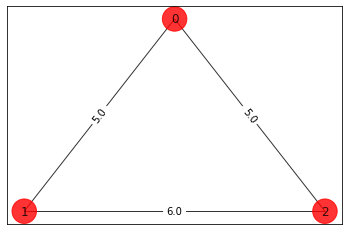

In [37]:
# Generating a graph of 3 nodes
n = 3
num_qubits = n ** 2

#ins = tsp.random_tsp(n, seed=123)
ins = tsp.parse_tsplib_format('/home/pui/tsp_sample/3cities.tsp')
print('distance\n', ins.w)

G = nx.Graph()
G.add_nodes_from(np.arange(0, ins.dim, 1))
colors = ['r' for node in G.nodes()]
for i in range(0, ins.dim):
    for j in range(i+1, ins.dim):
        G.add_edge(i, j, weight=ins.w[i,j])
pos = {k: v for k, v in enumerate(ins.coord)}

#default_axes = plt.axes(frameon=True)
#nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
#print(ins)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    
draw_graph(G, colors, pos)


Brute force approach

order = (0, 1, 2) Distance = 16.0
Best order from brute force = (0, 1, 2) with total distance = 16.0


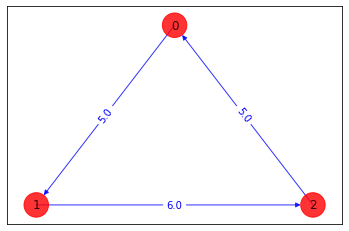

In [38]:
from itertools import permutations

def brute_force_tsp(w, N):
    a=list(permutations(range(1,N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j,pre_j]
            pre_j = j
        distance = distance + w[pre_j,0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print('order = ' + str(order) + ' Distance = ' + str(distance))
    return last_best_distance, best_order
  
best_distance, best_order = brute_force_tsp(ins.w, ins.dim)
print('Best order from brute force = ' + str(best_order) + ' with total distance = ' + str(best_distance))

def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]['weight'])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, edge_color='b', node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, font_color='b', edge_labels=edge_labels)
    
draw_tsp_solution(G, best_order, colors, pos)

Mapping to the Ising problem
-Generate Hamiltonian for TSP of a graph
 Input : ins (TspData) : TSP data including coordinates and distances.
 Return : tuple(WeightedPauliOperator, float): operator for the Hamiltonian and a constant shift for the obj function.

In [39]:
#qubitOp, offset = tsp.get_operator(ins)
#algo_input = Z2Symmetries(qubitOp)
qubitOp, offset = tsp.get_operator(ins)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

Offset: 600024.0
Ising Hamiltonian:
IIIIIIIIZ	(-100005+0j)
IIIIZIIII	(-100005.5+0j)
IIIIZIIIZ	(1.25+0j)
IIIIIIIZI	(-100005+0j)
IIIZIIIII	(-100005.5+0j)
IIIZIIIZI	(1.25+0j)
IIIIIIZII	(-100005+0j)
IIIIIZIII	(-100005.5+0j)
IIIIIZZII	(1.25+0j)
IZIIIIIII	(-100005.5+0j)
IZIIIIIIZ	(1.25+0j)
ZIIIIIIII	(-100005.5+0j)
ZIIIIIIZI	(1.25+0j)
IIZIIIIII	(-100005.5+0j)
IIZIIIZII	(1.25+0j)
IIIIIZIZI	(1.25+0j)
IIIIZIZII	(1.25+0j)
IIIZIIIIZ	(1.25+0j)
IZIIIZIII	(1.5+0j)
ZIIIZIIII	(1.5+0j)
IIZZIIIII	(1.5+0j)
IIZIIIIZI	(1.25+0j)
IZIIIIZII	(1.25+0j)
ZIIIIIIIZ	(1.25+0j)
IIZIZIIII	(1.5+0j)
IZIZIIIII	(1.5+0j)
ZIIIIZIII	(1.5+0j)
IIIIIZIIZ	(50000+0j)
IIZIIIIIZ	(50000+0j)
IIZIIZIII	(50000+0j)
IIIIZIIZI	(50000+0j)
IZIIIIIZI	(50000+0j)
IZIIZIIII	(50000+0j)
IIIZIIZII	(50000+0j)
ZIIIIIZII	(50000+0j)
ZIIZIIIII	(50000+0j)
IIIIIIIZZ	(50000+0j)
IIIIIIZIZ	(50000+0j)
IIIIIIZZI	(50000+0j)
IIIIZZIII	(50000+0j)
IIIZIZIII	(50000+0j)
IIIZZIIII	(50000+0j)
IZZIIIIII	(50000+0j)
ZIZIIIIII	(50000+0j)
ZZIIIIIII	(50000+0j)



In [40]:
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset, linear=True)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;
dvar bool x_5;
dvar bool x_6;
dvar bool x_7;
dvar bool x_8;

minimize
 - 200000 x_0 - 200000 x_1 - 200000 x_2 - 200000 x_3 - 200000 x_4 - 200000 x_5
 - 200000 x_6 - 200000 x_7 - 200000 x_8 [ 200000 x_0*x_1 + 200000 x_0*x_2
 + 200000 x_0*x_3 + 5 x_0*x_4 + 5 x_0*x_5 + 200000 x_0*x_6 + 5 x_0*x_7
 + 5 x_0*x_8 + 200000 x_1*x_2 + 5 x_1*x_3 + 200000 x_1*x_4 + 5 x_1*x_5
 + 5 x_1*x_6 + 200000 x_1*x_7 + 5 x_1*x_8 + 5 x_2*x_3 + 5 x_2*x_4
 + 200000 x_2*x_5 + 5 x_2*x_6 + 5 x_2*x_7 + 200000 x_2*x_8 + 200000 x_3*x_4
 + 200000 x_3*x_5 + 200000 x_3*x_6 + 6 x_3*x_7 + 6 x_3*x_8 + 200000 x_4*x_5
 + 6 x_4*x_6 + 200000 x_4*x_7 + 6 x_4*x_8 + 6 x_5*x_6 + 6 x_5*x_7
 + 200000 x_5*x_8 + 200000 x_6*x_7 + 200000 x_6*x_8 + 200000 x_7*x_8 ] +
 600000;
 
subject to {

}


Checking that the full Hamiltonian gives the right cost

In [41]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

optimal function value: 16.0
optimal value: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
status: SUCCESS


energy: -600008.0
tsp objective: 16.0
feasible: True
solution: [1, 2, 0]
solution objective: 16.0


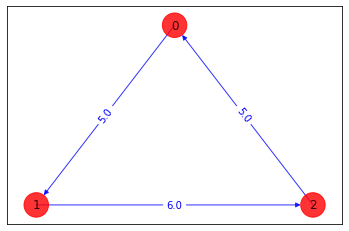

In [42]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

print('energy:', result.eigenvalue.real)
print('tsp objective:', result.eigenvalue.real + offset)
x = sample_most_likely(result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)


In [ ]:
print(result)

Running it on quantum computer

We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, 𝑈single(𝜃)=∏𝑛𝑖=1𝑌(𝜃𝑖)
, and entangler steps 𝑈entangler.

Run on statevector simulator

In [ ]:
seed = 10598
#seed = 1
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

spsa = SPSA(max_trials=200)
#ry = RY.(qubitOp.num_qubits, depth=5, entanglement='linear')
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
#form = EfficientSU2(qubitOp.num_qubits, su2_gates=['ry'], entanglement='linear')
#vqe = VQE(qubitOp, ry, spsa)
#vqe = VQE(qubitOp, form, spsa)
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)

result = vqe.run(quantum_instance)
#display(form.draw())
#print(form.qasm())

print('energy:', result.eigenvalue.real)
print('tsp objective:', result.eigenvalue.real + offset)
x = sample_most_likely(result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)


In [ ]:
print(result)

In [ ]:
#create minimum eigen optimizer based on VQE and solve quadratic program

seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)

Run on qasm simulator

2020-10-13 00:05:35,582:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.15.2
Backend: 'qasm_simulator (AerProvider)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None
/home/pui/miniconda3/envs/qiskit/lib/python3.8/site-packages/qiskit/aqua/components/optimizers/spsa.py:95: DeprecationWarning: The max_trials parameter is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use maxiter instead.
  warnings.warn('The max_trials parameter is deprecated as of '
202

2020-10-13 00:05:35,673:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, Non

2020-10-13 00:10:02,741:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [585751.51855469] - 6952.58904 (ms), eval count: 37
2020-10-13 00:10:10,232:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [528726.08007812] - 7490.09562 (ms), eval count: 38
2020-10-13 00:10:17,671:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [535750.20507812] - 7437.92129 (ms), eval count: 39
2020-10-13 00:10:24,603:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [612524.92382812] - 6931.40316 (ms), eval count: 40
2020-10-13 00:10:31,648:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [573049.08496094] - 7043.28299 (ms), eval count: 41
2020-10-13 00:10:38,797:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [566040.93945312] - 7148.88430 (ms), eval count: 42
2020-10-13 00:10:46,157:qiskit.aqua.algorithms.minim

2020-10-13 00:16:10,048:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-601903.55859375] - 6958.26912 (ms), eval count: 89
2020-10-13 00:16:17,474:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-518470.16796875] - 7425.16875 (ms), eval count: 90
2020-10-13 00:16:24,232:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-540775.06152344] - 6756.96540 (ms), eval count: 91
2020-10-13 00:16:31,602:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-510233.03125] - 7369.36450 (ms), eval count: 92
2020-10-13 00:16:38,835:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-529038.53027344] - 7231.23264 (ms), eval count: 93
2020-10-13 00:16:45,542:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-511820.18359375] - 6706.53176 (ms), eval count: 94
2020-10-13 00:16:52,258:qiskit.aqua.algorithms.mi

2020-10-13 00:21:46,022:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-849477.3359375] - 5700.34432 (ms), eval count: 141
2020-10-13 00:21:51,627:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-958933.37695312] - 5603.86753 (ms), eval count: 142
2020-10-13 00:21:57,483:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-866517.68847656] - 5854.80857 (ms), eval count: 143
2020-10-13 00:22:02,916:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1030656.17089844] - 5431.97250 (ms), eval count: 144
2020-10-13 00:22:09,131:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-965580.54003906] - 6213.99641 (ms), eval count: 145
2020-10-13 00:22:15,071:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-940345.63671875] - 5939.31270 (ms), eval count: 146
2020-10-13 00:22:21,004:qiskit.aqua.algo

2020-10-13 00:26:12,635:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1101000.26367188] - 4611.09471 (ms), eval count: 193
2020-10-13 00:26:17,036:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1127588.76855469] - 4399.83821 (ms), eval count: 194
2020-10-13 00:26:21,813:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1106079.29003906] - 4775.83408 (ms), eval count: 195
2020-10-13 00:26:26,175:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1124636.9296875] - 4361.24206 (ms), eval count: 196
2020-10-13 00:26:30,540:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1108629.15332031] - 4363.27219 (ms), eval count: 197
2020-10-13 00:26:35,143:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1116639.19433594] - 4601.99881 (ms), eval count: 198
2020-10-13 00:26:39,881:qiskit.aqua

2020-10-13 00:29:25,010:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1203800.56835938] - 2920.66979 (ms), eval count: 244
2020-10-13 00:29:28,186:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1178208.90429688] - 3175.17519 (ms), eval count: 245
2020-10-13 00:29:31,462:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1177410.87109375] - 3274.66369 (ms), eval count: 246
2020-10-13 00:29:34,252:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1194040.00585938] - 2788.92255 (ms), eval count: 247
2020-10-13 00:29:37,677:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1183456.27539062] - 3423.29645 (ms), eval count: 248
2020-10-13 00:29:40,421:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1209648.80566406] - 2742.82455 (ms), eval count: 249
2020-10-13 00:29:43,828:qiskit.aqu

2020-10-13 00:31:58,175:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1202592.28808594] - 3118.86334 (ms), eval count: 295
2020-10-13 00:32:00,884:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1230554.09472656] - 2708.33397 (ms), eval count: 296
2020-10-13 00:32:04,279:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1197321.35742188] - 3394.39487 (ms), eval count: 297
2020-10-13 00:32:06,952:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1216675.78027344] - 2671.22412 (ms), eval count: 298
2020-10-13 00:32:09,605:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1235239.56835938] - 2651.99828 (ms), eval count: 299
2020-10-13 00:32:12,730:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1208269.3515625] - 3124.75944 (ms), eval count: 300
2020-10-13 00:32:15,371:qiskit.aqua

2020-10-13 00:34:19,707:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1248496.80859375] - 2718.35613 (ms), eval count: 346
2020-10-13 00:34:21,957:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1256716.79003906] - 2249.38464 (ms), eval count: 347
2020-10-13 00:34:24,911:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1218995.79101562] - 2952.67892 (ms), eval count: 348
2020-10-13 00:34:27,320:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1247726.39746094] - 2407.48048 (ms), eval count: 349
2020-10-13 00:34:29,986:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1235614.29101562] - 2664.83593 (ms), eval count: 350
2020-10-13 00:34:32,274:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1233676.84960938] - 2286.67212 (ms), eval count: 351
2020-10-13 00:34:34,891:qiskit.aqu

2020-10-13 00:36:29,050:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1239121.8515625] - 2574.57423 (ms), eval count: 397
2020-10-13 00:36:31,408:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1266665.55664062] - 2357.01585 (ms), eval count: 398
2020-10-13 00:36:33,794:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1248500.7265625] - 2384.78541 (ms), eval count: 399
2020-10-13 00:36:36,407:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1250833.92089844] - 2612.30659 (ms), eval count: 400
2020-10-13 00:36:39,092:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1246533.06835938] - 2683.55775 (ms), eval count: 401
2020-10-13 00:36:41,378:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1238156.72167969] - 2285.06517 (ms), eval count: 402
2020-10-13 00:36:44,102:qiskit.aqua.

2020-10-13 00:38:32,949:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1251423.07324219] - 2533.79703 (ms), eval count: 448
2020-10-13 00:38:35,059:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1289120.13183594] - 2108.75797 (ms), eval count: 449
2020-10-13 00:38:37,668:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1250256.51660156] - 2607.78856 (ms), eval count: 450
2020-10-13 00:38:39,906:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1266479.34082031] - 2236.80735 (ms), eval count: 451
2020-10-13 00:38:42,161:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1278564.015625] - 2254.39572 (ms), eval count: 452
2020-10-13 00:38:44,276:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1271358.10351562] - 2114.26258 (ms), eval count: 453
2020-10-13 00:38:46,598:qiskit.aqua.

2020-10-13 00:40:26,182:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1274091.08007812] - 2298.95973 (ms), eval count: 500
2020-10-13 00:40:28,529:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1257457.99023438] - 2345.70336 (ms), eval count: 501
2020-10-13 00:40:30,343:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1295376.68261719] - 1813.09390 (ms), eval count: 502
2020-10-13 00:40:32,410:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1274471.72070312] - 2066.21981 (ms), eval count: 503
2020-10-13 00:40:34,492:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1282856.03027344] - 2080.46269 (ms), eval count: 504
2020-10-13 00:40:36,366:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1269401.4765625] - 1872.79701 (ms), eval count: 505
2020-10-13 00:40:38,433:qiskit.aqua

2020-10-13 00:42:07,448:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1309605.21972656] - 1749.11213 (ms), eval count: 551
2020-10-13 00:42:09,753:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1286162.74609375] - 2303.97558 (ms), eval count: 552
2020-10-13 00:42:11,345:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1309412.92089844] - 1590.10291 (ms), eval count: 553
2020-10-13 00:42:13,243:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1301976.98242188] - 1897.52102 (ms), eval count: 554
2020-10-13 00:42:15,081:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1303348.25097656] - 1836.62081 (ms), eval count: 555
2020-10-13 00:42:16,949:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1299640.56445312] - 1867.31267 (ms), eval count: 556
2020-10-13 00:42:18,818:qiskit.aqu

2020-10-13 00:43:39,042:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1315058.30957031] - 1807.97029 (ms), eval count: 602
2020-10-13 00:43:40,833:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1304904.1015625] - 1789.96682 (ms), eval count: 603
2020-10-13 00:43:42,525:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1327360.71777344] - 1691.28108 (ms), eval count: 604
2020-10-13 00:43:44,367:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1305296.91601562] - 1840.20567 (ms), eval count: 605
2020-10-13 00:43:46,062:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1313487.32226562] - 1694.64612 (ms), eval count: 606
2020-10-13 00:43:47,731:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1325413.92578125] - 1667.33718 (ms), eval count: 607
2020-10-13 00:43:49,816:qiskit.aqua

2020-10-13 00:45:03,627:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1345724.25878906] - 1344.26403 (ms), eval count: 653
2020-10-13 00:45:05,296:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1338102.72363281] - 1667.75918 (ms), eval count: 654
2020-10-13 00:45:06,870:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1337307.94238281] - 1572.91603 (ms), eval count: 655
2020-10-13 00:45:08,400:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1333044.40820312] - 1529.16408 (ms), eval count: 656
2020-10-13 00:45:09,786:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1329911.89355469] - 1385.39267 (ms), eval count: 657
2020-10-13 00:45:11,480:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1331247.43164062] - 1692.40880 (ms), eval count: 658
2020-10-13 00:45:13,237:qiskit.aqu

2020-10-13 00:46:23,187:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1340641.97558594] - 1456.86913 (ms), eval count: 704
2020-10-13 00:46:24,619:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1352730.39550781] - 1430.02248 (ms), eval count: 705
2020-10-13 00:46:26,192:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1359772.5234375] - 1572.84260 (ms), eval count: 706
2020-10-13 00:46:27,539:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1350018.60644531] - 1345.94870 (ms), eval count: 707
2020-10-13 00:46:29,051:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1374020.04785156] - 1511.07407 (ms), eval count: 708
2020-10-13 00:46:30,639:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1350769.02050781] - 1586.96723 (ms), eval count: 709
2020-10-13 00:46:32,172:qiskit.aqua

2020-10-13 00:47:35,099:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1378093.98144531] - 1391.78872 (ms), eval count: 755
2020-10-13 00:47:36,395:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1398830.98242188] - 1295.00198 (ms), eval count: 756
2020-10-13 00:47:37,630:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1391207.40136719] - 1234.65157 (ms), eval count: 757
2020-10-13 00:47:39,088:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1393532.38769531] - 1456.35986 (ms), eval count: 758
2020-10-13 00:47:40,624:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1383383.02734375] - 1534.57260 (ms), eval count: 759
2020-10-13 00:47:41,868:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1405264.10253906] - 1243.49308 (ms), eval count: 760
2020-10-13 00:47:43,280:qiskit.aqu

2020-10-13 00:48:41,615:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1419108.16796875] - 1212.75806 (ms), eval count: 806
2020-10-13 00:48:42,707:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1434519.9296875] - 1091.00032 (ms), eval count: 807
2020-10-13 00:48:43,945:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1415601.80273438] - 1237.70332 (ms), eval count: 808
2020-10-13 00:48:45,224:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1421844.97949219] - 1277.75049 (ms), eval count: 809
2020-10-13 00:48:46,409:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1418688.28808594] - 1184.73268 (ms), eval count: 810
2020-10-13 00:48:47,779:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1398405.49609375] - 1368.09087 (ms), eval count: 811
2020-10-13 00:48:48,940:qiskit.aqua

2020-10-13 00:49:42,805:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1461274.15722656] - 1031.94261 (ms), eval count: 858
2020-10-13 00:49:43,941:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1432174.05273438] - 1134.71603 (ms), eval count: 859
2020-10-13 00:49:45,002:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1449952.234375] - 1060.16111 (ms), eval count: 860
2020-10-13 00:49:46,059:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1451893.96484375] - 1056.09965 (ms), eval count: 861
2020-10-13 00:49:47,343:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1430430.87792969] - 1282.36556 (ms), eval count: 862
2020-10-13 00:49:48,343:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1448194.60351562] - 998.53396 (ms), eval count: 863
2020-10-13 00:49:49,490:qiskit.aqua.a

2020-10-13 00:50:39,070:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1471232.65722656] - 912.63628 (ms), eval count: 910
2020-10-13 00:50:40,094:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1461657.00195312] - 1022.72892 (ms), eval count: 911
2020-10-13 00:50:41,041:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1450336.02246094] - 945.91928 (ms), eval count: 912
2020-10-13 00:50:42,008:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1470446.546875] - 966.64333 (ms), eval count: 913
2020-10-13 00:50:43,075:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1449558.64453125] - 1066.24103 (ms), eval count: 914
2020-10-13 00:50:43,913:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1471419.40039062] - 836.80987 (ms), eval count: 915
2020-10-13 00:50:45,136:qiskit.aqua.algo

2020-10-13 00:51:29,129:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1477661.51953125] - 852.65779 (ms), eval count: 962
2020-10-13 00:51:29,932:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1489193.70898438] - 802.31690 (ms), eval count: 963
2020-10-13 00:51:30,689:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1484506.66503906] - 755.49102 (ms), eval count: 964
2020-10-13 00:51:31,714:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1472394.07910156] - 1023.95010 (ms), eval count: 965
2020-10-13 00:51:32,544:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1492121.70117187] - 828.43518 (ms), eval count: 966
2020-10-13 00:51:33,412:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1489960.33007812] - 867.62404 (ms), eval count: 967
2020-10-13 00:51:34,377:qiskit.aqua.alg

2020-10-13 00:52:12,904:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1474930.24609375] - 930.24254 (ms), eval count: 1014
2020-10-13 00:52:13,606:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1495441.16699219] - 701.11370 (ms), eval count: 1015
2020-10-13 00:52:14,488:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1475107.59082031] - 881.25801 (ms), eval count: 1016
2020-10-13 00:52:15,229:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1481581.81640625] - 739.80284 (ms), eval count: 1017
2020-10-13 00:52:15,948:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1507731.86328125] - 718.11366 (ms), eval count: 1018
2020-10-13 00:52:16,713:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1492903.98242188] - 764.15372 (ms), eval count: 1019
2020-10-13 00:52:17,502:qiskit.aqu

energy: -1541917.424804687
tsp objective: 58878.575195312966
feasible: True
solution: [2, 0, 1, 3]
solution objective: 302.0


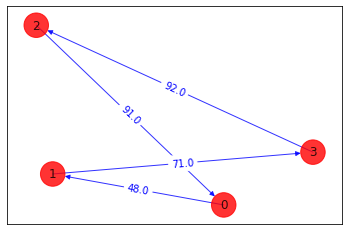

In [35]:
# run quantum algorithm with shots

seed = 10598
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

spsa = SPSA(max_trials=500)
#ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
#form = EfficientSU2(qubitOp.num_qubits, su2_gates=['ry'], entanglement='linear')
#vqe = VQE(qubitOp, ry, spsa)
#vqe = VQE(qubitOp, form, spsa)
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)

result = vqe.run(quantum_instance)

print('energy:', result.eigenvalue.real)
print('tsp objective:', result.eigenvalue.real + offset)
x = sample_most_likely(result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)


In [ ]:
print(result)

In [ ]:
result['eigenstate']

In [ ]:
plot_histogram(result['eigenstate'])

In [ ]:
ry.qasm(filename='/home/pui/tsp.txt')

In [ ]:
#create minimum eigen optimizer based on VQE and solve quadratic program

seed = 10598
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)

Run on real device

In [43]:
# run quantum algorithm with shots

seed = 10598
backend = provider.get_backend('ibmq_qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

spsa = SPSA(max_trials=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)


#ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
#form = EfficientSU2(qubitOp.num_qubits, su2_gates=['ry'], entanglement='linear')
#vqe = VQE(qubitOp, ry, spsa)
#vqe = VQE(qubitOp, form, spsa)

result = vqe.run(quantum_instance)

print('energy:', result.eigenvalue.real)
print('tsp objective:', result.eigenvalue.real + offset)
x = sample_most_likely(result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)

2020-10-13 10:35:38,813:qiskit.aqua.quantum_instance:WARNING: The skip Qobj validation does not work for IBMQ provider. Disable it.
2020-10-13 10:35:38,814:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.15.2
Backend: 'ibmq_qasm_simulator (<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'ccx', 'swap', 'unitary', 'initialize', 'kraus'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1024)
{'timeout': None, 'wait': 5}
{}
{}
Measurement mitigation: None
/home/pui/miniconda3/envs/qiskit/lib/python3.8/site-packages/qiskit/aqua/components/optimizers/spsa.py:95: DeprecationWarning: The max_trials parameter is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use m

2020-10-13 10:35:38,853:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
initial point=[ 3.37618266  0.25176504 -0.88952584  2.5830433   5.19185413 -0.67104186
  2.54830705 -4.26975018 -5.95123904 -4.366442    2.84760378  3

KeyboardInterrupt: 

In [ ]:
result['eigenstate']

In [ ]:
plot_histogram(result['eigenstate'])

In [44]:
# run quantum algorithm with shots

seed = 10598
backend = provider.get_backend('ibmq_16_melbourne')
#noise_model = basic_device_noise_model(provider.get_backend('ibmq_16_melbourne').properties())
noise_model = NoiseModel.from_backend(backend)
basis_gates = noise_model.basis_gates
coupling_map = backend.configuration().coupling_map
simulator = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(simulator, noise_model=noise_model, basis_gates=basis_gates, coupling_map=coupling_map, shots=1024, seed_simulator=seed, seed_transpiler=seed, skip_qobj_validation=False)

spsa = SPSA(max_trials=10000)
#ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
#vqe = VQE(qubitOp, ry, spsa)
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)

#backend = provider.get_backend('ibmq_16_melbourne')

#noise_model = NoiseModel.from_backend(backend)
#basis_gates = noise_model.basis_gates
#coupling_map = backend.configuration().coupling_map


result = vqe.run(quantum_instance)

print('energy:', result['eigenvalue'])
print('time:', result['optimizer_time'])
#print('tsp objective:', result['energy'] + offset)
x = sample_most_likely(result['eigenstate'])
#x = tsp.sample_most_likely(result['eigvecs'][0])
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))

draw_tsp_solution(G, z, colors, pos)

2020-10-13 10:36:17,262:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.15.2
Backend: 'qasm_simulator (AerProvider)', with following setting:
{'basis_gates': ['cx', 'id', 'u2', 'u3'], 'coupling_map': [[0, 1], [0, 14], [1, 0], [1, 2], [1, 13], [2, 1], [2, 3], [2, 12], [3, 2], [3, 4], [3, 11], [4, 3], [4, 5], [4, 10], [5, 4], [5, 6], [5, 9], [6, 5], [6, 8], [7, 8], [8, 6], [8, 7], [8, 9], [9, 5], [9, 8], [9, 10], [10, 4], [10, 9], [10, 11], [11, 3], [11, 10], [11, 12], [12, 2], [12, 11], [12, 13], [13, 1], [13, 12], [13, 14], [14, 0], [14, 13]]}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1024)
{'timeout': None}
{}
{'noise_model': NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['cx', 'u2', 'id', 'u3', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  Specific qubit errors: [('id', [0]), ('id', [1]), (

2020-10-13 10:36:17,299:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
initial point=[ 3.16457122  5.31264158  5.76256795  0.47079311 -0.5683033   0.95299901
 -4.81676808 -3.57729012  2.39174932  0.49063204  0.19471378  4

2020-10-13 10:38:00,060:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [137506.77929688] - 2340.97314 (ms), eval count: 44
2020-10-13 10:38:02,367:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [129889.70507812] - 2306.00262 (ms), eval count: 45
2020-10-13 10:38:04,767:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [108013.21484375] - 2399.00756 (ms), eval count: 46
2020-10-13 10:38:07,152:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [118365.68066406] - 2384.48477 (ms), eval count: 47
2020-10-13 10:38:09,458:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [114263.89648438] - 2304.78954 (ms), eval count: 48
2020-10-13 10:38:11,777:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [77934.01171875] - 2318.05158 (ms), eval count: 49
2020-10-13 10:38:14,091:qiskit.aqua.algorithms.minimu

2020-10-13 10:40:06,282:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-116802.65039062] - 2533.94461 (ms), eval count: 96
2020-10-13 10:40:08,854:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-128716.83691406] - 2571.45596 (ms), eval count: 97
2020-10-13 10:40:11,358:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-148053.54101562] - 2502.31218 (ms), eval count: 98
2020-10-13 10:40:13,898:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-147272.03808594] - 2539.61635 (ms), eval count: 99
2020-10-13 10:40:16,398:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-148053.75878906] - 2498.60215 (ms), eval count: 100
2020-10-13 10:40:18,933:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-141803.13964844] - 2534.43956 (ms), eval count: 101
2020-10-13 10:40:21,556:qiskit.aqua.algorith

2020-10-13 10:42:18,077:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-175202.21777344] - 2470.57247 (ms), eval count: 148
2020-10-13 10:42:20,589:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-181062.375] - 2510.88452 (ms), eval count: 149
2020-10-13 10:42:23,071:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-178131.69726562] - 2481.08983 (ms), eval count: 150
2020-10-13 10:42:25,666:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-180866.80761719] - 2593.38284 (ms), eval count: 151
2020-10-13 10:42:28,156:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-180866.44628906] - 2489.00795 (ms), eval count: 152
2020-10-13 10:42:30,654:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-190046.73046875] - 2497.06578 (ms), eval count: 153
2020-10-13 10:42:33,195:qiskit.aqua.algorithm

2020-10-13 10:44:26,553:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-191218.72753906] - 2447.99852 (ms), eval count: 200
2020-10-13 10:44:28,971:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-184187.31152344] - 2416.82673 (ms), eval count: 201
2020-10-13 10:44:31,464:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-203328.98828125] - 2492.33770 (ms), eval count: 202
2020-10-13 10:44:33,929:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-188289.453125] - 2463.44686 (ms), eval count: 203
2020-10-13 10:44:36,346:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-200984.77050781] - 2415.81988 (ms), eval count: 204
2020-10-13 10:44:38,791:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-190828.24511719] - 2444.47517 (ms), eval count: 205
2020-10-13 10:44:41,189:qiskit.aqua.algori

2020-10-13 10:46:31,558:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-211142.51953125] - 2392.31038 (ms), eval count: 252
2020-10-13 10:46:33,993:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-210947.32128906] - 2433.80094 (ms), eval count: 253
2020-10-13 10:46:36,345:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-215438.83300781] - 2351.11213 (ms), eval count: 254
2020-10-13 10:46:38,725:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-212509.44335938] - 2379.05097 (ms), eval count: 255
2020-10-13 10:46:41,114:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-204696.75097656] - 2387.42352 (ms), eval count: 256
2020-10-13 10:46:43,456:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-210946.99707031] - 2341.43996 (ms), eval count: 257
2020-10-13 10:46:45,886:qiskit.aqua.algo

2020-10-13 10:48:35,681:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-217978.73242188] - 2381.51860 (ms), eval count: 304
2020-10-13 10:48:38,137:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-213876.91699219] - 2455.06263 (ms), eval count: 305
2020-10-13 10:48:40,464:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-214658.30371094] - 2326.07603 (ms), eval count: 306
2020-10-13 10:48:42,866:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-208798.82128906] - 2400.89965 (ms), eval count: 307
2020-10-13 10:48:45,190:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-225009.88378906] - 2322.45517 (ms), eval count: 308
2020-10-13 10:48:47,515:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-215439.93457031] - 2323.77958 (ms), eval count: 309
2020-10-13 10:48:49,888:qiskit.aqua.algo

2020-10-13 10:50:38,560:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-220517.78710938] - 2336.57932 (ms), eval count: 356
2020-10-13 10:50:41,025:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-219345.49804688] - 2463.91273 (ms), eval count: 357
2020-10-13 10:50:43,388:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-219345.86035156] - 2361.79852 (ms), eval count: 358
2020-10-13 10:50:45,722:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-223447.47753906] - 2332.56936 (ms), eval count: 359
2020-10-13 10:50:48,100:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-221689.29882812] - 2377.06780 (ms), eval count: 360
2020-10-13 10:50:50,514:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-217587.3671875] - 2413.39326 (ms), eval count: 361
2020-10-13 10:50:53,000:qiskit.aqua.algor

2020-10-13 10:52:42,108:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-217978.27148438] - 2384.64975 (ms), eval count: 408
2020-10-13 10:52:44,514:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-224815.44433594] - 2404.64330 (ms), eval count: 409
2020-10-13 10:52:46,819:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-225399.92578125] - 2303.67017 (ms), eval count: 410
2020-10-13 10:52:49,190:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-219931.484375] - 2370.35751 (ms), eval count: 411
2020-10-13 10:52:51,547:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-213291.44921875] - 2355.72076 (ms), eval count: 412
2020-10-13 10:52:53,885:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-225791.57910156] - 2337.12149 (ms), eval count: 413
2020-10-13 10:52:56,250:qiskit.aqua.algori

2020-10-13 10:54:44,833:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-228330.40429688] - 2338.29880 (ms), eval count: 460
2020-10-13 10:54:47,176:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-221103.53710938] - 2342.66400 (ms), eval count: 461
2020-10-13 10:54:49,515:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-222080.40234375] - 2337.67843 (ms), eval count: 462
2020-10-13 10:54:51,959:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-216025.02246094] - 2443.22681 (ms), eval count: 463
2020-10-13 10:54:54,307:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-223057.01171875] - 2346.99249 (ms), eval count: 464
2020-10-13 10:54:56,649:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-224814.87207031] - 2339.99729 (ms), eval count: 465
2020-10-13 10:54:59,005:qiskit.aqua.algo

2020-10-13 10:56:47,524:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-229307.33496094] - 2360.11767 (ms), eval count: 512
2020-10-13 10:56:49,920:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-228525.62011719] - 2395.03050 (ms), eval count: 513
2020-10-13 10:56:52,238:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-221494.57421875] - 2317.03424 (ms), eval count: 514
2020-10-13 10:56:54,628:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-227159.14453125] - 2389.27960 (ms), eval count: 515
2020-10-13 10:56:56,988:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-225595.44921875] - 2358.93083 (ms), eval count: 516
2020-10-13 10:56:59,417:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-224424.02734375] - 2426.94736 (ms), eval count: 517
2020-10-13 10:57:01,734:qiskit.aqua.algo

2020-10-13 10:58:50,272:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-226181.7734375] - 2326.61963 (ms), eval count: 564
2020-10-13 10:58:52,608:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-225205.72265625] - 2335.12831 (ms), eval count: 565
2020-10-13 10:58:54,963:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-227744.48339844] - 2353.04952 (ms), eval count: 566
2020-10-13 10:58:57,394:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-223252.52050781] - 2430.98116 (ms), eval count: 567
2020-10-13 10:58:59,727:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-230479.19726562] - 2331.09426 (ms), eval count: 568
2020-10-13 10:59:02,110:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-227744.76464844] - 2382.62844 (ms), eval count: 569
2020-10-13 10:59:04,456:qiskit.aqua.algor

2020-10-13 11:00:52,495:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-229503.04003906] - 2409.40690 (ms), eval count: 616
2020-10-13 11:00:54,882:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-232236.95800781] - 2386.73544 (ms), eval count: 617
2020-10-13 11:00:57,221:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-226573.02539062] - 2337.86297 (ms), eval count: 618
2020-10-13 11:00:59,551:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-232237.18164062] - 2328.86100 (ms), eval count: 619
2020-10-13 11:01:01,907:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-229502.50585938] - 2354.65169 (ms), eval count: 620
2020-10-13 11:01:04,382:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-222666.50585938] - 2473.65975 (ms), eval count: 621
2020-10-13 11:01:06,716:qiskit.aqua.algo

2020-10-13 11:02:54,922:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-227158.91796875] - 2353.87969 (ms), eval count: 668
2020-10-13 11:02:57,248:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-231064.85351562] - 2324.79143 (ms), eval count: 669
2020-10-13 11:02:59,630:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-227354.65722656] - 2380.49841 (ms), eval count: 670
2020-10-13 11:03:01,964:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-227940.16113281] - 2332.81112 (ms), eval count: 671
2020-10-13 11:03:04,276:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-235361.88964844] - 2312.11472 (ms), eval count: 672
2020-10-13 11:03:06,634:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-230088.51660156] - 2356.31275 (ms), eval count: 673
2020-10-13 11:03:08,950:qiskit.aqua.algo

2020-10-13 11:04:57,273:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-225791.43652344] - 2362.42199 (ms), eval count: 720
2020-10-13 11:04:59,605:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-233604.07324219] - 2331.38490 (ms), eval count: 721
2020-10-13 11:05:02,023:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-230870.24609375] - 2417.19532 (ms), eval count: 722
2020-10-13 11:05:04,330:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-231065.765625] - 2305.96614 (ms), eval count: 723
2020-10-13 11:05:06,697:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-230869.43457031] - 2365.24844 (ms), eval count: 724
2020-10-13 11:05:08,978:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-227940.39453125] - 2280.62081 (ms), eval count: 725
2020-10-13 11:05:11,326:qiskit.aqua.algori

2020-10-13 11:06:59,474:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-227744.97753906] - 2366.92476 (ms), eval count: 772
2020-10-13 11:07:01,819:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-227940.08984375] - 2343.26982 (ms), eval count: 773
2020-10-13 11:07:04,195:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-224033.95800781] - 2375.39864 (ms), eval count: 774
2020-10-13 11:07:06,498:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-228916.71875] - 2302.22964 (ms), eval count: 775
2020-10-13 11:07:08,835:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-235557.51855469] - 2336.04264 (ms), eval count: 776
2020-10-13 11:07:11,163:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-227549.46777344] - 2326.78509 (ms), eval count: 777
2020-10-13 11:07:13,549:qiskit.aqua.algorit

2020-10-13 11:09:02,084:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-226963.13769531] - 2385.76102 (ms), eval count: 824
2020-10-13 11:09:04,399:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-233018.71679688] - 2314.71682 (ms), eval count: 825
2020-10-13 11:09:06,768:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-226377.41015625] - 2368.13402 (ms), eval count: 826
2020-10-13 11:09:09,167:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-232042.15234375] - 2397.85528 (ms), eval count: 827
2020-10-13 11:09:11,581:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-228330.63476562] - 2412.96768 (ms), eval count: 828
2020-10-13 11:09:13,968:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-231065.56738281] - 2385.83589 (ms), eval count: 829
2020-10-13 11:09:16,397:qiskit.aqua.algo

2020-10-13 11:11:04,207:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-232432.87890625] - 2344.80953 (ms), eval count: 876
2020-10-13 11:11:06,553:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-234581.10058594] - 2344.85316 (ms), eval count: 877
2020-10-13 11:11:08,848:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-233018.14355469] - 2293.90240 (ms), eval count: 878
2020-10-13 11:11:11,274:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-228721.30175781] - 2425.42505 (ms), eval count: 879
2020-10-13 11:11:13,622:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-224229.25585938] - 2346.67730 (ms), eval count: 880
2020-10-13 11:11:16,004:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-229111.73925781] - 2381.23441 (ms), eval count: 881
2020-10-13 11:11:18,325:qiskit.aqua.algo

2020-10-13 11:13:05,786:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-227744.97363281] - 2297.73474 (ms), eval count: 928
2020-10-13 11:13:08,087:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-232237.28808594] - 2299.73650 (ms), eval count: 929
2020-10-13 11:13:10,462:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-234971.32421875] - 2373.88515 (ms), eval count: 930
2020-10-13 11:13:12,752:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-234581.21582031] - 2288.74326 (ms), eval count: 931
2020-10-13 11:13:15,113:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-230088.30175781] - 2360.02135 (ms), eval count: 932
2020-10-13 11:13:17,469:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-233018.609375] - 2354.83098 (ms), eval count: 933
2020-10-13 11:13:19,759:qiskit.aqua.algori

2020-10-13 11:15:07,206:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-230088.40039062] - 2384.83882 (ms), eval count: 980
2020-10-13 11:15:09,540:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-233214.24414062] - 2332.90863 (ms), eval count: 981
2020-10-13 11:15:11,865:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-232823.06445312] - 2323.92049 (ms), eval count: 982
2020-10-13 11:15:14,210:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-234581.04296875] - 2343.81342 (ms), eval count: 983
2020-10-13 11:15:16,551:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-231260.52929688] - 2339.78152 (ms), eval count: 984
2020-10-13 11:15:18,984:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-227745.27246094] - 2431.84185 (ms), eval count: 985
2020-10-13 11:15:21,298:qiskit.aqua.algo

2020-10-13 11:17:09,019:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-233604.53125] - 2403.37706 (ms), eval count: 1032
2020-10-13 11:17:11,427:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-236729.78222656] - 2406.52323 (ms), eval count: 1033
2020-10-13 11:17:13,744:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-234971.56054688] - 2315.98544 (ms), eval count: 1034
2020-10-13 11:17:16,070:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-235752.92480469] - 2325.01054 (ms), eval count: 1035
2020-10-13 11:17:18,370:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237706.41308594] - 2298.82884 (ms), eval count: 1036
2020-10-13 11:17:20,706:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-233995.17675781] - 2335.83570 (ms), eval count: 1037
2020-10-13 11:17:23,031:qiskit.aqua.a

2020-10-13 11:19:08,101:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-233213.88378906] - 2291.19062 (ms), eval count: 1083
2020-10-13 11:19:10,500:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-232823.38671875] - 2398.36931 (ms), eval count: 1084
2020-10-13 11:19:12,893:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237120.12695312] - 2391.21962 (ms), eval count: 1085
2020-10-13 11:19:15,194:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-233214.24804688] - 2300.48323 (ms), eval count: 1086
2020-10-13 11:19:17,475:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-235167.24902344] - 2279.72221 (ms), eval count: 1087
2020-10-13 11:19:19,809:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-236729.49316406] - 2333.38380 (ms), eval count: 1088
2020-10-13 11:19:22,139:qiskit.aqu

2020-10-13 11:21:07,610:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-236925.08007812] - 2346.52185 (ms), eval count: 1134
2020-10-13 11:21:09,897:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-233018.54882812] - 2286.57031 (ms), eval count: 1135
2020-10-13 11:21:12,278:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-230088.66601562] - 2380.18680 (ms), eval count: 1136
2020-10-13 11:21:14,595:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-231846.54394531] - 2315.34195 (ms), eval count: 1137
2020-10-13 11:21:16,933:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-232432.73730469] - 2336.84087 (ms), eval count: 1138
2020-10-13 11:21:19,224:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-236534.36523438] - 2290.55166 (ms), eval count: 1139
2020-10-13 11:21:21,554:qiskit.aqu

2020-10-13 11:23:06,798:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-232823.20703125] - 2328.91607 (ms), eval count: 1185
2020-10-13 11:23:09,106:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-232823.33886719] - 2307.49631 (ms), eval count: 1186
2020-10-13 11:23:11,446:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-229698.3828125] - 2338.06443 (ms), eval count: 1187
2020-10-13 11:23:13,823:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-236729.46875] - 2376.03235 (ms), eval count: 1188
2020-10-13 11:23:16,227:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-235557.46679688] - 2402.91786 (ms), eval count: 1189
2020-10-13 11:23:18,500:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-234776.72949219] - 2272.86553 (ms), eval count: 1190
2020-10-13 11:23:20,897:qiskit.aqua.al

2020-10-13 11:25:06,064:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-235362.234375] - 2340.75356 (ms), eval count: 1236
2020-10-13 11:25:08,334:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-234971.89941406] - 2268.35299 (ms), eval count: 1237
2020-10-13 11:25:10,657:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-233799.72363281] - 2322.47996 (ms), eval count: 1238
2020-10-13 11:25:12,967:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-230284.07226562] - 2308.38561 (ms), eval count: 1239
2020-10-13 11:25:15,302:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-233409.35058594] - 2335.10852 (ms), eval count: 1240
2020-10-13 11:25:17,628:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-233604.6484375] - 2324.68104 (ms), eval count: 1241
2020-10-13 11:25:19,968:qiskit.aqua.a

2020-10-13 11:27:05,820:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-233604.18847656] - 2336.66635 (ms), eval count: 1287
2020-10-13 11:27:08,148:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237511.21386719] - 2326.57504 (ms), eval count: 1288
2020-10-13 11:27:10,492:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-232432.43066406] - 2343.24050 (ms), eval count: 1289
2020-10-13 11:27:12,801:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237510.97949219] - 2308.18415 (ms), eval count: 1290
2020-10-13 11:27:15,225:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-239659.515625] - 2422.43552 (ms), eval count: 1291
2020-10-13 11:27:17,632:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237901.46484375] - 2405.79224 (ms), eval count: 1292
2020-10-13 11:27:20,012:qiskit.aqua.

2020-10-13 11:29:05,743:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237706.23632812] - 2332.67355 (ms), eval count: 1338
2020-10-13 11:29:08,132:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-235167.4921875] - 2388.13210 (ms), eval count: 1339
2020-10-13 11:29:10,493:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-238291.65332031] - 2359.78007 (ms), eval count: 1340
2020-10-13 11:29:12,807:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-234971.50976562] - 2312.84475 (ms), eval count: 1341
2020-10-13 11:29:15,120:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237706.12207031] - 2311.66196 (ms), eval count: 1342
2020-10-13 11:29:17,500:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-238096.73730469] - 2378.87573 (ms), eval count: 1343
2020-10-13 11:29:19,838:qiskit.aqua

2020-10-13 11:31:05,654:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-233408.84960938] - 2375.95558 (ms), eval count: 1389
2020-10-13 11:31:07,974:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-235167.42773438] - 2318.69984 (ms), eval count: 1390
2020-10-13 11:31:10,325:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-235948.37304688] - 2349.54047 (ms), eval count: 1391
2020-10-13 11:31:12,738:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-234385.7578125] - 2411.95965 (ms), eval count: 1392
2020-10-13 11:31:15,153:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-238096.59082031] - 2414.63923 (ms), eval count: 1393
2020-10-13 11:31:17,486:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-235948.42578125] - 2331.33149 (ms), eval count: 1394
2020-10-13 11:31:19,804:qiskit.aqua

2020-10-13 11:33:05,577:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-235752.6875] - 2314.63003 (ms), eval count: 1440
2020-10-13 11:33:07,908:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237901.35839844] - 2329.74863 (ms), eval count: 1441
2020-10-13 11:33:10,234:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-236534.29101562] - 2325.12522 (ms), eval count: 1442
2020-10-13 11:33:12,556:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-235557.65722656] - 2320.40501 (ms), eval count: 1443
2020-10-13 11:33:14,932:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-233409.43457031] - 2375.43917 (ms), eval count: 1444
2020-10-13 11:33:17,257:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237901.32910156] - 2323.42386 (ms), eval count: 1445
2020-10-13 11:33:19,577:qiskit.aqua.al

2020-10-13 11:35:04,996:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-235752.51953125] - 2436.14101 (ms), eval count: 1491
2020-10-13 11:35:07,392:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-231651.82226562] - 2395.17713 (ms), eval count: 1492
2020-10-13 11:35:09,703:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-234776.24316406] - 2309.54671 (ms), eval count: 1493
2020-10-13 11:35:12,055:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-234776.58007812] - 2351.74465 (ms), eval count: 1494
2020-10-13 11:35:14,371:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-235362.39941406] - 2314.35704 (ms), eval count: 1495
2020-10-13 11:35:16,694:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-240635.82910156] - 2322.42441 (ms), eval count: 1496
2020-10-13 11:35:18,993:qiskit.aqu

2020-10-13 11:37:04,915:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-236729.67285156] - 2369.99846 (ms), eval count: 1542
2020-10-13 11:37:07,235:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-231455.73828125] - 2318.96853 (ms), eval count: 1543
2020-10-13 11:37:09,663:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-243370.31542969] - 2428.01046 (ms), eval count: 1544
2020-10-13 11:37:12,056:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-238682.78222656] - 2391.76416 (ms), eval count: 1545
2020-10-13 11:37:14,397:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-241416.99902344] - 2339.60080 (ms), eval count: 1546
2020-10-13 11:37:16,724:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-240049.90625] - 2326.29609 (ms), eval count: 1547
2020-10-13 11:37:19,039:qiskit.aqua.a

2020-10-13 11:39:07,052:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237705.91503906] - 2303.22909 (ms), eval count: 1594
2020-10-13 11:39:09,380:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237901.36621094] - 2326.59841 (ms), eval count: 1595
2020-10-13 11:39:11,717:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237120.08691406] - 2336.51376 (ms), eval count: 1596
2020-10-13 11:39:14,077:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237706.06738281] - 2358.22845 (ms), eval count: 1597
2020-10-13 11:39:16,440:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-236924.69824219] - 2362.58388 (ms), eval count: 1598
2020-10-13 11:39:18,764:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-230869.99609375] - 2323.10772 (ms), eval count: 1599
2020-10-13 11:39:21,095:qiskit.aqu

2020-10-13 11:41:07,388:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-231065.60742188] - 2358.97017 (ms), eval count: 1645
2020-10-13 11:41:09,740:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-233994.84472656] - 2350.88348 (ms), eval count: 1646
2020-10-13 11:41:12,108:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-238487.70214844] - 2367.02323 (ms), eval count: 1647
2020-10-13 11:41:14,440:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237705.99511719] - 2331.52032 (ms), eval count: 1648
2020-10-13 11:41:16,793:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-240635.8671875] - 2351.68552 (ms), eval count: 1649
2020-10-13 11:41:19,129:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-238291.94238281] - 2335.33859 (ms), eval count: 1650
2020-10-13 11:41:21,455:qiskit.aqua

2020-10-13 11:43:07,420:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-236925.55761719] - 2354.51388 (ms), eval count: 1696
2020-10-13 11:43:09,824:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-240245.49023438] - 2402.71783 (ms), eval count: 1697
2020-10-13 11:43:12,196:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-234971.55957031] - 2371.67406 (ms), eval count: 1698
2020-10-13 11:43:14,539:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-239659.65820312] - 2341.03632 (ms), eval count: 1699
2020-10-13 11:43:16,894:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-232432.19433594] - 2353.99985 (ms), eval count: 1700
2020-10-13 11:43:19,302:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-241612.60742188] - 2407.27735 (ms), eval count: 1701
2020-10-13 11:43:21,621:qiskit.aqu

2020-10-13 11:45:07,736:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237315.328125] - 2378.32284 (ms), eval count: 1747
2020-10-13 11:45:10,050:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237511.01660156] - 2313.41457 (ms), eval count: 1748
2020-10-13 11:45:12,484:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-238878.40234375] - 2432.76358 (ms), eval count: 1749
2020-10-13 11:45:14,866:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-240049.8203125] - 2381.03795 (ms), eval count: 1750
2020-10-13 11:45:17,184:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-244932.94238281] - 2316.59961 (ms), eval count: 1751
2020-10-13 11:45:19,506:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-241417.13867188] - 2321.26093 (ms), eval count: 1752
2020-10-13 11:45:21,915:qiskit.aqua.a

2020-10-13 11:47:08,258:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-234385.44726562] - 2600.77667 (ms), eval count: 1798
2020-10-13 11:47:10,711:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-241026.46972656] - 2452.29053 (ms), eval count: 1799
2020-10-13 11:47:13,602:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-236729.640625] - 2889.62650 (ms), eval count: 1800
2020-10-13 11:47:16,224:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-239659.29101562] - 2620.22328 (ms), eval count: 1801
2020-10-13 11:47:18,871:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-236729.59082031] - 2645.75934 (ms), eval count: 1802
2020-10-13 11:47:21,421:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-239073.70019531] - 2548.75278 (ms), eval count: 1803
2020-10-13 11:47:23,902:qiskit.aqua.

2020-10-13 11:49:12,950:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-235362.43066406] - 2427.02174 (ms), eval count: 1849
2020-10-13 11:49:15,327:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237120.45898438] - 2376.74809 (ms), eval count: 1850
2020-10-13 11:49:17,702:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-235362.45800781] - 2373.97790 (ms), eval count: 1851
2020-10-13 11:49:20,049:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-240245.14746094] - 2346.14158 (ms), eval count: 1852
2020-10-13 11:49:22,447:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237120.59667969] - 2396.90590 (ms), eval count: 1853
2020-10-13 11:49:24,797:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-243956.00878906] - 2348.44780 (ms), eval count: 1854
2020-10-13 11:49:27,202:qiskit.aqu

2020-10-13 11:51:14,777:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-241612.66699219] - 2350.36302 (ms), eval count: 1900
2020-10-13 11:51:17,149:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-243370.27832031] - 2370.28599 (ms), eval count: 1901
2020-10-13 11:51:19,552:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-245519.11328125] - 2402.85969 (ms), eval count: 1902
2020-10-13 11:51:21,895:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-242393.99902344] - 2342.13448 (ms), eval count: 1903
2020-10-13 11:51:24,413:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-240440.54199219] - 2516.03794 (ms), eval count: 1904
2020-10-13 11:51:26,892:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-232823.16601562] - 2478.19877 (ms), eval count: 1905
2020-10-13 11:51:29,264:qiskit.aqu

2020-10-13 11:53:17,704:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-244347.46582031] - 2317.85941 (ms), eval count: 1951
2020-10-13 11:53:20,104:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-241221.59765625] - 2398.98157 (ms), eval count: 1952
2020-10-13 11:53:22,544:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-241612.58984375] - 2438.19880 (ms), eval count: 1953
2020-10-13 11:53:24,993:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-238097.12207031] - 2447.98231 (ms), eval count: 1954
2020-10-13 11:53:27,425:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-245518.72460938] - 2431.63085 (ms), eval count: 1955
2020-10-13 11:53:29,828:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-240831.58886719] - 2402.25601 (ms), eval count: 1956
2020-10-13 11:53:32,265:qiskit.aqu

2020-10-13 11:55:22,256:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-239463.91796875] - 2379.26793 (ms), eval count: 2003
2020-10-13 11:55:24,631:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237706.33886719] - 2373.71206 (ms), eval count: 2004
2020-10-13 11:55:27,150:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-237511.0546875] - 2518.17799 (ms), eval count: 2005
2020-10-13 11:55:29,510:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-240831.421875] - 2359.79652 (ms), eval count: 2006
2020-10-13 11:55:31,884:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-244737.9453125] - 2373.18444 (ms), eval count: 2007
2020-10-13 11:55:34,247:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-246690.8046875] - 2361.68480 (ms), eval count: 2008
2020-10-13 11:55:36,645:qiskit.aqua.alg

2020-10-13 11:57:23,805:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-241026.53710938] - 2347.65720 (ms), eval count: 2054
2020-10-13 11:57:26,133:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-241808.06738281] - 2327.21758 (ms), eval count: 2055
2020-10-13 11:57:28,542:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-242784.32617188] - 2407.76515 (ms), eval count: 2056
2020-10-13 11:57:31,042:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-242589.24902344] - 2499.82929 (ms), eval count: 2057
2020-10-13 11:57:33,414:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-244346.9609375] - 2370.49365 (ms), eval count: 2058
2020-10-13 11:57:35,748:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-245128.09277344] - 2332.71694 (ms), eval count: 2059
2020-10-13 11:57:38,109:qiskit.aqua

2020-10-13 11:59:27,852:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-242003.22265625] - 2396.61264 (ms), eval count: 2106
2020-10-13 11:59:30,286:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-245128.02050781] - 2433.46620 (ms), eval count: 2107
2020-10-13 11:59:32,733:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-242589.47070312] - 2445.46008 (ms), eval count: 2108
2020-10-13 11:59:35,108:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-245323.41015625] - 2373.58975 (ms), eval count: 2109
2020-10-13 11:59:37,450:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-242198.44042969] - 2341.82858 (ms), eval count: 2110
2020-10-13 11:59:39,857:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-244737.9453125] - 2405.89547 (ms), eval count: 2111
2020-10-13 11:59:42,193:qiskit.aqua

2020-10-13 12:01:29,435:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-244151.77636719] - 2338.66429 (ms), eval count: 2157
2020-10-13 12:01:31,820:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-246495.37207031] - 2383.70132 (ms), eval count: 2158
2020-10-13 12:01:34,170:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-246300.2265625] - 2349.08319 (ms), eval count: 2159
2020-10-13 12:01:36,747:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-246300.27148438] - 2575.55079 (ms), eval count: 2160
2020-10-13 12:01:39,148:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-240440.60058594] - 2400.10428 (ms), eval count: 2161
2020-10-13 12:01:41,509:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248058.078125] - 2359.80344 (ms), eval count: 2162
2020-10-13 12:01:43,889:qiskit.aqua.a

2020-10-13 12:03:30,440:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-245909.21484375] - 2328.07064 (ms), eval count: 2208
2020-10-13 12:03:32,779:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247081.34375] - 2337.96477 (ms), eval count: 2209
2020-10-13 12:03:35,119:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250402.03613281] - 2339.69021 (ms), eval count: 2210
2020-10-13 12:03:37,535:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-245714.11621094] - 2415.17496 (ms), eval count: 2211
2020-10-13 12:03:39,875:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-245714.34375] - 2338.64570 (ms), eval count: 2212
2020-10-13 12:03:42,245:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-239464.3359375] - 2369.60554 (ms), eval count: 2213
2020-10-13 12:03:44,582:qiskit.aqua.algor

2020-10-13 12:05:30,808:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-246495.4609375] - 2345.20292 (ms), eval count: 2259
2020-10-13 12:05:33,140:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247667.55761719] - 2330.99222 (ms), eval count: 2260
2020-10-13 12:05:35,505:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248253.51855469] - 2363.76643 (ms), eval count: 2261
2020-10-13 12:05:37,874:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-239268.65917969] - 2368.26277 (ms), eval count: 2262
2020-10-13 12:05:40,236:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-242589.39746094] - 2360.71014 (ms), eval count: 2263
2020-10-13 12:05:42,678:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-235557.6640625] - 2441.25724 (ms), eval count: 2264
2020-10-13 12:05:45,035:qiskit.aqua.

2020-10-13 12:07:33,385:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-242589.515625] - 2342.95225 (ms), eval count: 2310
2020-10-13 12:07:35,734:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-244542.42675781] - 2348.37008 (ms), eval count: 2311
2020-10-13 12:07:38,183:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-246104.95898438] - 2447.85500 (ms), eval count: 2312
2020-10-13 12:07:40,531:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249034.60644531] - 2346.82059 (ms), eval count: 2313
2020-10-13 12:07:42,882:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251964.72265625] - 2350.20256 (ms), eval count: 2314
2020-10-13 12:07:45,253:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-240636.18652344] - 2369.97390 (ms), eval count: 2315
2020-10-13 12:07:47,704:qiskit.aqua.

2020-10-13 12:09:38,070:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247472.03417969] - 2384.57680 (ms), eval count: 2362
2020-10-13 12:09:40,459:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-244152.16992188] - 2388.04531 (ms), eval count: 2363
2020-10-13 12:09:42,845:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249229.77832031] - 2384.55415 (ms), eval count: 2364
2020-10-13 12:09:45,219:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-246886.54492188] - 2373.01898 (ms), eval count: 2365
2020-10-13 12:09:47,543:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-240049.97558594] - 2322.70765 (ms), eval count: 2366
2020-10-13 12:09:49,917:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248839.24902344] - 2373.14415 (ms), eval count: 2367
2020-10-13 12:09:52,324:qiskit.aqu

2020-10-13 12:11:39,907:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-246495.61035156] - 2432.28889 (ms), eval count: 2413
2020-10-13 12:11:42,260:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248448.96875] - 2351.94278 (ms), eval count: 2414
2020-10-13 12:11:44,617:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247277.11914062] - 2355.94153 (ms), eval count: 2415
2020-10-13 12:11:47,041:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248839.34667969] - 2422.60718 (ms), eval count: 2416
2020-10-13 12:11:49,398:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-245714.60253906] - 2356.59313 (ms), eval count: 2417
2020-10-13 12:11:51,756:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-242393.87695312] - 2356.57501 (ms), eval count: 2418
2020-10-13 12:11:54,187:qiskit.aqua.a

2020-10-13 12:13:43,582:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247472.57617188] - 2345.50834 (ms), eval count: 2465
2020-10-13 12:13:45,928:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250792.18945312] - 2345.23773 (ms), eval count: 2466
2020-10-13 12:13:48,279:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250207.21289062] - 2349.89905 (ms), eval count: 2467
2020-10-13 12:13:50,618:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-244932.6328125] - 2337.82458 (ms), eval count: 2468
2020-10-13 12:13:53,028:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248839.96679688] - 2408.90503 (ms), eval count: 2469
2020-10-13 12:13:55,408:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251769.06542969] - 2378.97301 (ms), eval count: 2470
2020-10-13 12:13:57,836:qiskit.aqua

2020-10-13 12:15:44,719:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-246495.68066406] - 2350.76594 (ms), eval count: 2516
2020-10-13 12:15:47,178:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-246885.99609375] - 2456.93183 (ms), eval count: 2517
2020-10-13 12:15:49,564:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250011.80761719] - 2385.31423 (ms), eval count: 2518
2020-10-13 12:15:51,951:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250792.6484375] - 2386.35230 (ms), eval count: 2519
2020-10-13 12:15:54,443:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-246496.18847656] - 2490.84234 (ms), eval count: 2520
2020-10-13 12:15:56,746:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248058.21289062] - 2301.78213 (ms), eval count: 2521
2020-10-13 12:15:59,193:qiskit.aqua

2020-10-13 12:17:47,578:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249034.96289062] - 2366.19973 (ms), eval count: 2568
2020-10-13 12:17:49,933:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251768.93261719] - 2353.89042 (ms), eval count: 2569
2020-10-13 12:17:52,358:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-246300.390625] - 2423.74396 (ms), eval count: 2570
2020-10-13 12:17:54,783:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-245909.39941406] - 2424.06702 (ms), eval count: 2571
2020-10-13 12:17:57,087:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250011.86328125] - 2303.25174 (ms), eval count: 2572
2020-10-13 12:17:59,458:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251964.59863281] - 2369.98367 (ms), eval count: 2573
2020-10-13 12:18:01,823:qiskit.aqua.

2020-10-13 12:19:48,357:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249620.9296875] - 2364.00080 (ms), eval count: 2619
2020-10-13 12:19:50,672:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-245714.69824219] - 2314.56280 (ms), eval count: 2620
2020-10-13 12:19:52,990:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247472.4296875] - 2316.99061 (ms), eval count: 2621
2020-10-13 12:19:55,353:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248839.63964844] - 2361.77301 (ms), eval count: 2622
2020-10-13 12:19:57,690:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250597.52246094] - 2336.05623 (ms), eval count: 2623
2020-10-13 12:20:00,005:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248449.015625] - 2314.19945 (ms), eval count: 2624
2020-10-13 12:20:02,352:qiskit.aqua.al

2020-10-13 12:21:51,361:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253136.37304688] - 2320.40787 (ms), eval count: 2671
2020-10-13 12:21:53,673:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247472.55175781] - 2310.89568 (ms), eval count: 2672
2020-10-13 12:21:56,079:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-244347.38085938] - 2405.56431 (ms), eval count: 2673
2020-10-13 12:21:58,399:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249426.06347656] - 2318.94922 (ms), eval count: 2674
2020-10-13 12:22:00,807:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250206.9921875] - 2406.94380 (ms), eval count: 2675
2020-10-13 12:22:03,187:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249816.16992188] - 2378.98350 (ms), eval count: 2676
2020-10-13 12:22:05,509:qiskit.aqua

2020-10-13 12:23:50,105:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-246886.40136719] - 2308.34794 (ms), eval count: 2722
2020-10-13 12:23:52,422:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-245128.92480469] - 2316.27607 (ms), eval count: 2723
2020-10-13 12:23:54,787:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249425.63671875] - 2364.24661 (ms), eval count: 2724
2020-10-13 12:23:57,157:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252159.86132812] - 2368.47377 (ms), eval count: 2725
2020-10-13 12:23:59,601:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247863.41113281] - 2443.09616 (ms), eval count: 2726
2020-10-13 12:24:01,958:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-244151.74804688] - 2355.48711 (ms), eval count: 2727
2020-10-13 12:24:04,272:qiskit.aqu

2020-10-13 12:25:49,375:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248058.53125] - 2307.10673 (ms), eval count: 2773
2020-10-13 12:25:51,699:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-245128.78417969] - 2322.27230 (ms), eval count: 2774
2020-10-13 12:25:54,043:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251183.21582031] - 2343.20045 (ms), eval count: 2775
2020-10-13 12:25:56,414:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-245519.39941406] - 2370.02730 (ms), eval count: 2776
2020-10-13 12:25:58,750:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253136.59667969] - 2334.92613 (ms), eval count: 2777
2020-10-13 12:26:01,057:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248840.06445312] - 2305.71246 (ms), eval count: 2778
2020-10-13 12:26:03,425:qiskit.aqua.a

2020-10-13 12:27:49,343:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-243175.83203125] - 2308.19941 (ms), eval count: 2824
2020-10-13 12:27:51,691:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247277.23632812] - 2347.22447 (ms), eval count: 2825
2020-10-13 12:27:54,101:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248448.9765625] - 2409.22451 (ms), eval count: 2826
2020-10-13 12:27:56,586:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248644.50585938] - 2483.33406 (ms), eval count: 2827
2020-10-13 12:27:58,930:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248253.89550781] - 2343.44649 (ms), eval count: 2828
2020-10-13 12:28:01,293:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-244542.22558594] - 2361.31811 (ms), eval count: 2829
2020-10-13 12:28:03,694:qiskit.aqua

2020-10-13 12:29:51,383:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248449.08105469] - 2317.07406 (ms), eval count: 2876
2020-10-13 12:29:53,691:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247862.86523438] - 2306.98419 (ms), eval count: 2877
2020-10-13 12:29:56,027:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-245714.97558594] - 2335.30474 (ms), eval count: 2878
2020-10-13 12:29:58,365:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251769.5546875] - 2337.37373 (ms), eval count: 2879
2020-10-13 12:30:00,713:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251378.62011719] - 2346.26389 (ms), eval count: 2880
2020-10-13 12:30:03,051:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-244347.18847656] - 2337.81147 (ms), eval count: 2881
2020-10-13 12:30:05,368:qiskit.aqua

2020-10-13 12:31:52,777:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249425.71191406] - 2305.37963 (ms), eval count: 2928
2020-10-13 12:31:55,143:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-246300.71191406] - 2365.39674 (ms), eval count: 2929
2020-10-13 12:31:57,524:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249620.96777344] - 2380.00560 (ms), eval count: 2930
2020-10-13 12:32:00,088:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249620.94335938] - 2563.16733 (ms), eval count: 2931
2020-10-13 12:32:02,478:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250597.66894531] - 2388.50975 (ms), eval count: 2932
2020-10-13 12:32:04,793:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251964.97949219] - 2314.53776 (ms), eval count: 2933
2020-10-13 12:32:07,183:qiskit.aqu

2020-10-13 12:33:52,621:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248058.8046875] - 2318.30335 (ms), eval count: 2979
2020-10-13 12:33:54,934:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247472.36230469] - 2311.65671 (ms), eval count: 2980
2020-10-13 12:33:57,410:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249816.36523438] - 2474.98512 (ms), eval count: 2981
2020-10-13 12:33:59,879:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249035.05175781] - 2468.37306 (ms), eval count: 2982
2020-10-13 12:34:02,226:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248644.44726562] - 2345.80612 (ms), eval count: 2983
2020-10-13 12:34:04,566:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251378.828125] - 2338.61399 (ms), eval count: 2984
2020-10-13 12:34:06,908:qiskit.aqua.a

2020-10-13 12:35:53,920:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253332.20996094] - 2321.90514 (ms), eval count: 3030
2020-10-13 12:35:56,272:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252160.28027344] - 2350.93236 (ms), eval count: 3031
2020-10-13 12:35:58,624:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249816.38867188] - 2350.85011 (ms), eval count: 3032
2020-10-13 12:36:00,959:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252745.89355469] - 2333.46796 (ms), eval count: 3033
2020-10-13 12:36:03,284:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254504.15820312] - 2324.63717 (ms), eval count: 3034
2020-10-13 12:36:05,593:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248449.20800781] - 2307.43790 (ms), eval count: 3035
2020-10-13 12:36:07,914:qiskit.aqu

2020-10-13 12:37:55,306:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251183.73828125] - 2321.40851 (ms), eval count: 3082
2020-10-13 12:37:57,639:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248644.46777344] - 2331.95376 (ms), eval count: 3083
2020-10-13 12:37:59,995:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247863.2734375] - 2355.25823 (ms), eval count: 3084
2020-10-13 12:38:02,313:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248840.02441406] - 2317.35396 (ms), eval count: 3085
2020-10-13 12:38:04,634:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251574.00488281] - 2319.81921 (ms), eval count: 3086
2020-10-13 12:38:06,955:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249230.20214844] - 2319.29755 (ms), eval count: 3087
2020-10-13 12:38:09,289:qiskit.aqua

2020-10-13 12:39:57,225:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248253.78027344] - 2546.81492 (ms), eval count: 3134
2020-10-13 12:39:59,861:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254503.73339844] - 2634.53841 (ms), eval count: 3135
2020-10-13 12:40:02,191:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252746.40136719] - 2329.12040 (ms), eval count: 3136
2020-10-13 12:40:04,515:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250988.36132812] - 2322.80946 (ms), eval count: 3137
2020-10-13 12:40:06,898:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251964.91308594] - 2382.15065 (ms), eval count: 3138
2020-10-13 12:40:09,283:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250987.89941406] - 2384.01389 (ms), eval count: 3139
2020-10-13 12:40:11,592:qiskit.aqu

2020-10-13 12:41:56,908:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249035.15722656] - 2439.40258 (ms), eval count: 3185
2020-10-13 12:41:59,236:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248644.64355469] - 2326.67661 (ms), eval count: 3186
2020-10-13 12:42:01,663:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248839.9609375] - 2425.52185 (ms), eval count: 3187
2020-10-13 12:42:04,011:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249230.41210938] - 2347.11790 (ms), eval count: 3188
2020-10-13 12:42:06,429:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247863.19335938] - 2417.47212 (ms), eval count: 3189
2020-10-13 12:42:08,812:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250597.66796875] - 2381.33740 (ms), eval count: 3190
2020-10-13 12:42:11,188:qiskit.aqua

2020-10-13 12:43:56,413:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254113.671875] - 2384.80163 (ms), eval count: 3236
2020-10-13 12:43:58,754:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251183.30078125] - 2340.31844 (ms), eval count: 3237
2020-10-13 12:44:01,028:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247863.67480469] - 2273.40293 (ms), eval count: 3238
2020-10-13 12:44:03,357:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252550.80761719] - 2326.97892 (ms), eval count: 3239
2020-10-13 12:44:05,697:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248254.15039062] - 2339.06865 (ms), eval count: 3240
2020-10-13 12:44:08,048:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247082.02539062] - 2350.58022 (ms), eval count: 3241
2020-10-13 12:44:10,359:qiskit.aqua.

2020-10-13 12:45:55,805:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249034.91992188] - 2434.85832 (ms), eval count: 3287
2020-10-13 12:45:58,136:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252355.43847656] - 2329.98991 (ms), eval count: 3288
2020-10-13 12:46:00,468:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251379.20996094] - 2331.07996 (ms), eval count: 3289
2020-10-13 12:46:02,788:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247667.4609375] - 2318.83812 (ms), eval count: 3290
2020-10-13 12:46:05,119:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249426.22558594] - 2330.08122 (ms), eval count: 3291
2020-10-13 12:46:07,454:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-246691.02246094] - 2334.00559 (ms), eval count: 3292
2020-10-13 12:46:09,797:qiskit.aqua

2020-10-13 12:47:55,617:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247081.65332031] - 2338.97948 (ms), eval count: 3338
2020-10-13 12:47:57,957:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253136.9609375] - 2338.74655 (ms), eval count: 3339
2020-10-13 12:48:00,285:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251183.4375] - 2326.73168 (ms), eval count: 3340
2020-10-13 12:48:02,630:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253136.67675781] - 2344.26713 (ms), eval count: 3341
2020-10-13 12:48:04,942:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250988.34863281] - 2311.46145 (ms), eval count: 3342
2020-10-13 12:48:07,306:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256652.28027344] - 2362.25772 (ms), eval count: 3343
2020-10-13 12:48:09,595:qiskit.aqua.alg

2020-10-13 12:50:19,691:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255870.98046875] - 3376.79410 (ms), eval count: 3389
2020-10-13 12:50:22,667:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251769.57617188] - 2975.70467 (ms), eval count: 3390
2020-10-13 12:50:25,758:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252942.00390625] - 3089.71739 (ms), eval count: 3391
2020-10-13 12:50:28,858:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254308.26660156] - 3099.07889 (ms), eval count: 3392
2020-10-13 12:50:31,952:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252160.25195312] - 3092.93556 (ms), eval count: 3393
2020-10-13 12:50:35,119:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255089.8046875] - 3165.58623 (ms), eval count: 3394
2020-10-13 12:50:37,760:qiskit.aqua

2020-10-13 12:53:03,296:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248449.28613281] - 2994.70735 (ms), eval count: 3440
2020-10-13 12:53:06,284:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253722.89746094] - 2986.55534 (ms), eval count: 3441
2020-10-13 12:53:09,382:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251573.90039062] - 3096.68112 (ms), eval count: 3442
2020-10-13 12:53:12,187:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252746.17578125] - 2803.44653 (ms), eval count: 3443
2020-10-13 12:53:15,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253332.02441406] - 2969.86008 (ms), eval count: 3444
2020-10-13 12:53:18,031:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250988.28320312] - 2872.35713 (ms), eval count: 3445
2020-10-13 12:53:21,033:qiskit.aqu

2020-10-13 12:55:20,209:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247863.04492188] - 2436.59544 (ms), eval count: 3492
2020-10-13 12:55:22,617:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252355.359375] - 2407.67050 (ms), eval count: 3493
2020-10-13 12:55:25,019:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252550.77148438] - 2400.24495 (ms), eval count: 3494
2020-10-13 12:55:27,371:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253722.89648438] - 2350.97718 (ms), eval count: 3495
2020-10-13 12:55:29,717:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250988.20214844] - 2345.12043 (ms), eval count: 3496
2020-10-13 12:55:32,081:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251183.99414062] - 2363.35731 (ms), eval count: 3497
2020-10-13 12:55:34,419:qiskit.aqua.

2020-10-13 12:57:20,473:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247863.17480469] - 2366.04214 (ms), eval count: 3543
2020-10-13 12:57:22,824:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256261.69726562] - 2350.18349 (ms), eval count: 3544
2020-10-13 12:57:25,160:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249425.4296875] - 2334.94020 (ms), eval count: 3545
2020-10-13 12:57:27,517:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250207.38476562] - 2355.46279 (ms), eval count: 3546
2020-10-13 12:57:29,869:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251379.08105469] - 2350.89803 (ms), eval count: 3547
2020-10-13 12:57:32,215:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254308.60351562] - 2345.73102 (ms), eval count: 3548
2020-10-13 12:57:34,557:qiskit.aqua

2020-10-13 12:59:20,798:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249230.46777344] - 2347.79429 (ms), eval count: 3594
2020-10-13 12:59:23,193:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-246691.62207031] - 2393.82792 (ms), eval count: 3595
2020-10-13 12:59:25,546:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249816.29980469] - 2351.52483 (ms), eval count: 3596
2020-10-13 12:59:27,989:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248644.578125] - 2442.22546 (ms), eval count: 3597
2020-10-13 12:59:30,314:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251378.78027344] - 2324.35489 (ms), eval count: 3598
2020-10-13 12:59:32,665:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251379.03710938] - 2349.68805 (ms), eval count: 3599
2020-10-13 12:59:35,014:qiskit.aqua.

2020-10-13 13:01:21,343:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250793.04199219] - 2306.96511 (ms), eval count: 3645
2020-10-13 13:01:23,715:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254698.94140625] - 2371.98424 (ms), eval count: 3646
2020-10-13 13:01:26,116:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252941.55371094] - 2399.25599 (ms), eval count: 3647
2020-10-13 13:01:28,469:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-247277.06445312] - 2352.22816 (ms), eval count: 3648
2020-10-13 13:01:30,821:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254113.15234375] - 2350.68035 (ms), eval count: 3649
2020-10-13 13:01:33,128:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252160.37890625] - 2305.97043 (ms), eval count: 3650
2020-10-13 13:01:35,421:qiskit.aqu

2020-10-13 13:03:21,007:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253136.61230469] - 2312.22415 (ms), eval count: 3696
2020-10-13 13:03:23,411:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250792.85058594] - 2402.55642 (ms), eval count: 3697
2020-10-13 13:03:25,731:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252355.796875] - 2319.26060 (ms), eval count: 3698
2020-10-13 13:03:28,036:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253332.15234375] - 2304.05045 (ms), eval count: 3699
2020-10-13 13:03:30,403:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255285.15625] - 2365.45300 (ms), eval count: 3700
2020-10-13 13:03:32,831:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252941.56835938] - 2427.15549 (ms), eval count: 3701
2020-10-13 13:03:35,162:qiskit.aqua.alg

2020-10-13 13:05:20,610:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252551.17285156] - 2310.47678 (ms), eval count: 3747
2020-10-13 13:05:22,964:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253331.69433594] - 2353.49131 (ms), eval count: 3748
2020-10-13 13:05:25,274:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257629.09082031] - 2308.59733 (ms), eval count: 3749
2020-10-13 13:05:27,680:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-248058.21875] - 2404.67644 (ms), eval count: 3750
2020-10-13 13:05:29,960:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252550.8359375] - 2278.79906 (ms), eval count: 3751
2020-10-13 13:05:32,384:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.59179688] - 2423.44522 (ms), eval count: 3752
2020-10-13 13:05:34,737:qiskit.aqua.al

2020-10-13 13:07:22,399:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250402.40722656] - 2300.24004 (ms), eval count: 3799
2020-10-13 13:07:24,752:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255480.31347656] - 2351.90225 (ms), eval count: 3800
2020-10-13 13:07:27,173:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253136.66992188] - 2420.19105 (ms), eval count: 3801
2020-10-13 13:07:29,507:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251183.62988281] - 2333.05621 (ms), eval count: 3802
2020-10-13 13:07:31,793:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250597.82421875] - 2284.66725 (ms), eval count: 3803
2020-10-13 13:07:34,136:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252355.48242188] - 2342.40079 (ms), eval count: 3804
2020-10-13 13:07:36,491:qiskit.aqu

2020-10-13 13:09:22,175:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254113.46582031] - 2319.13328 (ms), eval count: 3850
2020-10-13 13:09:24,514:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249425.46875] - 2338.02605 (ms), eval count: 3851
2020-10-13 13:09:26,835:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252746.32714844] - 2319.99397 (ms), eval count: 3852
2020-10-13 13:09:29,144:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250597.92382812] - 2307.26123 (ms), eval count: 3853
2020-10-13 13:09:31,470:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254308.56152344] - 2324.91446 (ms), eval count: 3854
2020-10-13 13:09:33,772:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250402.45410156] - 2301.00489 (ms), eval count: 3855
2020-10-13 13:09:36,097:qiskit.aqua.a

2020-10-13 13:11:23,700:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250402.26074219] - 2348.20843 (ms), eval count: 3902
2020-10-13 13:11:26,012:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255285.16015625] - 2311.51700 (ms), eval count: 3903
2020-10-13 13:11:28,331:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252160.36816406] - 2317.22021 (ms), eval count: 3904
2020-10-13 13:11:30,643:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251379.54785156] - 2311.97357 (ms), eval count: 3905
2020-10-13 13:11:32,987:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252355.08691406] - 2342.25130 (ms), eval count: 3906
2020-10-13 13:11:35,313:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255089.89355469] - 2325.09637 (ms), eval count: 3907
2020-10-13 13:11:37,805:qiskit.aqu

2020-10-13 13:13:23,189:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249815.99511719] - 2332.95608 (ms), eval count: 3953
2020-10-13 13:13:25,501:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251770.15136719] - 2310.77552 (ms), eval count: 3954
2020-10-13 13:13:27,869:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251378.5] - 2367.05208 (ms), eval count: 3955
2020-10-13 13:13:30,162:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251379.34667969] - 2291.99195 (ms), eval count: 3956
2020-10-13 13:13:32,572:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254894.47363281] - 2409.39999 (ms), eval count: 3957
2020-10-13 13:13:34,914:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249035.20703125] - 2340.16418 (ms), eval count: 3958
2020-10-13 13:13:37,274:qiskit.aqua.algor

2020-10-13 13:15:22,732:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256261.90917969] - 2324.31507 (ms), eval count: 4004
2020-10-13 13:15:25,186:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254504.03027344] - 2452.80623 (ms), eval count: 4005
2020-10-13 13:15:27,502:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254308.6015625] - 2315.52148 (ms), eval count: 4006
2020-10-13 13:15:29,848:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251378.77929688] - 2344.21158 (ms), eval count: 4007
2020-10-13 13:15:32,174:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250207.0234375] - 2325.71864 (ms), eval count: 4008
2020-10-13 13:15:34,523:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252160.22949219] - 2347.98360 (ms), eval count: 4009
2020-10-13 13:15:36,866:qiskit.aqua.

2020-10-13 13:17:24,781:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252550.96191406] - 2319.16618 (ms), eval count: 4056
2020-10-13 13:17:27,105:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252160.3125] - 2323.11320 (ms), eval count: 4057
2020-10-13 13:17:29,457:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252160.08105469] - 2350.85750 (ms), eval count: 4058
2020-10-13 13:17:31,749:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253918.34179688] - 2290.68518 (ms), eval count: 4059
2020-10-13 13:17:34,133:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252355.42773438] - 2383.89111 (ms), eval count: 4060
2020-10-13 13:17:36,433:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249035.05566406] - 2299.27683 (ms), eval count: 4061
2020-10-13 13:17:38,752:qiskit.aqua.al

2020-10-13 13:19:24,232:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253136.78417969] - 2325.14453 (ms), eval count: 4107
2020-10-13 13:19:26,572:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252941.54492188] - 2339.28323 (ms), eval count: 4108
2020-10-13 13:19:28,893:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255480.35449219] - 2319.49162 (ms), eval count: 4109
2020-10-13 13:19:31,226:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254309.01074219] - 2331.88772 (ms), eval count: 4110
2020-10-13 13:19:33,560:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256847.55761719] - 2332.45659 (ms), eval count: 4111
2020-10-13 13:19:35,938:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253918.37695312] - 2377.21419 (ms), eval count: 4112
2020-10-13 13:19:38,366:qiskit.aqu

2020-10-13 13:21:23,866:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254113.33398438] - 2417.35744 (ms), eval count: 4158
2020-10-13 13:21:26,187:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253917.79394531] - 2320.27578 (ms), eval count: 4159
2020-10-13 13:21:28,543:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252355.65429688] - 2354.52414 (ms), eval count: 4160
2020-10-13 13:21:30,879:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253918.12792969] - 2335.61707 (ms), eval count: 4161
2020-10-13 13:21:33,251:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254113.06542969] - 2371.14954 (ms), eval count: 4162
2020-10-13 13:21:35,649:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249620.97070312] - 2396.90351 (ms), eval count: 4163
2020-10-13 13:21:37,968:qiskit.aqu

2020-10-13 13:23:23,685:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253527.56445312] - 2334.73039 (ms), eval count: 4209
2020-10-13 13:23:26,036:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255675.71582031] - 2349.69568 (ms), eval count: 4210
2020-10-13 13:23:28,378:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252941.66894531] - 2341.41946 (ms), eval count: 4211
2020-10-13 13:23:30,732:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256652.08886719] - 2352.69594 (ms), eval count: 4212
2020-10-13 13:23:33,118:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253917.71289062] - 2385.32615 (ms), eval count: 4213
2020-10-13 13:23:35,445:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253332.359375] - 2325.92130 (ms), eval count: 4214
2020-10-13 13:23:37,766:qiskit.aqua.

2020-10-13 13:25:23,295:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254113.31445312] - 2306.41270 (ms), eval count: 4260
2020-10-13 13:25:25,606:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253527.15234375] - 2310.39000 (ms), eval count: 4261
2020-10-13 13:25:27,891:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255676.03808594] - 2283.17308 (ms), eval count: 4262
2020-10-13 13:25:30,257:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253332.32519531] - 2365.27824 (ms), eval count: 4263
2020-10-13 13:25:32,566:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.328125] - 2308.39181 (ms), eval count: 4264
2020-10-13 13:25:34,866:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257238.87695312] - 2298.80428 (ms), eval count: 4265
2020-10-13 13:25:37,197:qiskit.aqua.

2020-10-13 13:27:22,634:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254699.41992188] - 2376.87182 (ms), eval count: 4311
2020-10-13 13:27:24,958:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254894.58300781] - 2323.16923 (ms), eval count: 4312
2020-10-13 13:27:27,285:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257042.93261719] - 2325.91772 (ms), eval count: 4313
2020-10-13 13:27:29,651:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254113.48925781] - 2364.25495 (ms), eval count: 4314
2020-10-13 13:27:32,029:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249230.5859375] - 2377.68126 (ms), eval count: 4315
2020-10-13 13:27:34,415:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254308.6953125] - 2385.15878 (ms), eval count: 4316
2020-10-13 13:27:36,713:qiskit.aqua.

2020-10-13 13:29:24,129:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254308.53710938] - 2295.11905 (ms), eval count: 4363
2020-10-13 13:29:26,457:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253918.37695312] - 2327.04186 (ms), eval count: 4364
2020-10-13 13:29:28,795:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254504.10839844] - 2336.78293 (ms), eval count: 4365
2020-10-13 13:29:31,120:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254699.23046875] - 2324.28479 (ms), eval count: 4366
2020-10-13 13:29:33,510:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253527.77734375] - 2389.12129 (ms), eval count: 4367
2020-10-13 13:29:35,930:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253331.64160156] - 2419.15274 (ms), eval count: 4368
2020-10-13 13:29:38,361:qiskit.aqu

2020-10-13 13:31:23,448:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252941.49121094] - 2296.19622 (ms), eval count: 4414
2020-10-13 13:31:25,776:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254113.35449219] - 2326.70140 (ms), eval count: 4415
2020-10-13 13:31:28,142:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256066.41699219] - 2365.55910 (ms), eval count: 4416
2020-10-13 13:31:30,497:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254308.57128906] - 2354.00677 (ms), eval count: 4417
2020-10-13 13:31:32,765:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255090.20605469] - 2266.64186 (ms), eval count: 4418
2020-10-13 13:31:35,179:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253527.4375] - 2413.18631 (ms), eval count: 4419
2020-10-13 13:31:37,503:qiskit.aqua.al

2020-10-13 13:33:22,886:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251378.88085938] - 2364.04181 (ms), eval count: 4465
2020-10-13 13:33:25,251:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252550.9609375] - 2363.76286 (ms), eval count: 4466
2020-10-13 13:33:27,571:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253136.68261719] - 2319.36431 (ms), eval count: 4467
2020-10-13 13:33:29,911:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253722.70410156] - 2338.61947 (ms), eval count: 4468
2020-10-13 13:33:32,247:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254503.98144531] - 2335.17838 (ms), eval count: 4469
2020-10-13 13:33:34,569:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252941.55957031] - 2320.40858 (ms), eval count: 4470
2020-10-13 13:33:36,940:qiskit.aqua

2020-10-13 13:35:22,474:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249816.5703125] - 2380.31745 (ms), eval count: 4516
2020-10-13 13:35:24,820:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254699.41699219] - 2344.93446 (ms), eval count: 4517
2020-10-13 13:35:27,129:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251574.09277344] - 2307.49965 (ms), eval count: 4518
2020-10-13 13:35:29,460:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253527.52636719] - 2330.81746 (ms), eval count: 4519
2020-10-13 13:35:31,764:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254503.9609375] - 2302.62280 (ms), eval count: 4520
2020-10-13 13:35:34,065:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255480.54394531] - 2299.91698 (ms), eval count: 4521
2020-10-13 13:35:36,358:qiskit.aqua.

2020-10-13 13:37:21,685:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255480.63671875] - 2299.60775 (ms), eval count: 4567
2020-10-13 13:37:23,981:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254504.0546875] - 2296.15307 (ms), eval count: 4568
2020-10-13 13:37:26,328:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255480.42871094] - 2345.87359 (ms), eval count: 4569
2020-10-13 13:37:28,668:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254113.25195312] - 2339.00809 (ms), eval count: 4570
2020-10-13 13:37:31,039:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258019.52050781] - 2369.45724 (ms), eval count: 4571
2020-10-13 13:37:33,381:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257433.71972656] - 2340.71612 (ms), eval count: 4572
2020-10-13 13:37:35,704:qiskit.aqua

2020-10-13 13:39:21,151:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254503.89648438] - 2333.77886 (ms), eval count: 4618
2020-10-13 13:39:23,465:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252550.85351562] - 2312.68287 (ms), eval count: 4619
2020-10-13 13:39:25,748:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254113.26660156] - 2283.02526 (ms), eval count: 4620
2020-10-13 13:39:28,071:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252355.42675781] - 2321.27666 (ms), eval count: 4621
2020-10-13 13:39:30,416:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255090.02148438] - 2344.07449 (ms), eval count: 4622
2020-10-13 13:39:32,759:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251965.29394531] - 2342.25321 (ms), eval count: 4623
2020-10-13 13:39:35,081:qiskit.aqu

2020-10-13 13:41:20,404:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256066.49023438] - 2292.95778 (ms), eval count: 4669
2020-10-13 13:41:22,754:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255480.70117188] - 2349.12848 (ms), eval count: 4670
2020-10-13 13:41:25,074:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252941.45214844] - 2318.74347 (ms), eval count: 4671
2020-10-13 13:41:27,385:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254699.28320312] - 2309.91387 (ms), eval count: 4672
2020-10-13 13:41:29,674:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253331.90527344] - 2288.09953 (ms), eval count: 4673
2020-10-13 13:41:31,962:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255676.29589844] - 2287.30178 (ms), eval count: 4674
2020-10-13 13:41:34,270:qiskit.aqu

2020-10-13 13:43:19,646:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250988.51269531] - 2305.94563 (ms), eval count: 4720
2020-10-13 13:43:21,964:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255480.56933594] - 2317.09194 (ms), eval count: 4721
2020-10-13 13:43:24,285:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257043.26464844] - 2319.48733 (ms), eval count: 4722
2020-10-13 13:43:26,619:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254699.05078125] - 2333.02355 (ms), eval count: 4723
2020-10-13 13:43:28,932:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.73144531] - 2312.80470 (ms), eval count: 4724
2020-10-13 13:43:31,232:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254309.05566406] - 2298.73991 (ms), eval count: 4725
2020-10-13 13:43:33,566:qiskit.aqu

2020-10-13 13:45:18,324:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251964.73730469] - 2291.57782 (ms), eval count: 4771
2020-10-13 13:45:20,648:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-249426.07421875] - 2323.55404 (ms), eval count: 4772
2020-10-13 13:45:22,989:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251964.82324219] - 2339.69045 (ms), eval count: 4773
2020-10-13 13:45:25,307:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253918.22363281] - 2317.27958 (ms), eval count: 4774
2020-10-13 13:45:27,653:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255285.49023438] - 2344.95974 (ms), eval count: 4775
2020-10-13 13:45:29,978:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255285.03613281] - 2323.43006 (ms), eval count: 4776
2020-10-13 13:45:32,328:qiskit.aqu

2020-10-13 13:47:19,647:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253332.20898438] - 2301.26309 (ms), eval count: 4823
2020-10-13 13:47:21,978:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254503.95605469] - 2330.50680 (ms), eval count: 4824
2020-10-13 13:47:24,275:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255871.51464844] - 2295.34817 (ms), eval count: 4825
2020-10-13 13:47:26,573:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255089.609375] - 2297.05596 (ms), eval count: 4826
2020-10-13 13:47:28,873:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252746.34960938] - 2299.42369 (ms), eval count: 4827
2020-10-13 13:47:31,198:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252941.35058594] - 2324.18847 (ms), eval count: 4828
2020-10-13 13:47:33,559:qiskit.aqua.

2020-10-13 13:49:18,100:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255089.96582031] - 2345.92628 (ms), eval count: 4874
2020-10-13 13:49:20,456:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254894.98828125] - 2355.32975 (ms), eval count: 4875
2020-10-13 13:49:22,762:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255480.22753906] - 2304.98314 (ms), eval count: 4876
2020-10-13 13:49:25,061:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.51757812] - 2297.93739 (ms), eval count: 4877
2020-10-13 13:49:27,375:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256261.72558594] - 2312.95323 (ms), eval count: 4878
2020-10-13 13:49:29,674:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257043.19726562] - 2298.83313 (ms), eval count: 4879
2020-10-13 13:49:32,003:qiskit.aqu

2020-10-13 13:51:16,636:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250988.58398438] - 2302.83380 (ms), eval count: 4925
2020-10-13 13:51:18,973:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252550.8671875] - 2336.89761 (ms), eval count: 4926
2020-10-13 13:51:21,267:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256262.14257812] - 2293.05100 (ms), eval count: 4927
2020-10-13 13:51:23,555:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256066.52636719] - 2286.28945 (ms), eval count: 4928
2020-10-13 13:51:25,889:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257042.94433594] - 2332.65948 (ms), eval count: 4929
2020-10-13 13:51:28,201:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253137.10058594] - 2311.34915 (ms), eval count: 4930
2020-10-13 13:51:30,518:qiskit.aqua

2020-10-13 13:53:15,168:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256066.62304688] - 2368.85476 (ms), eval count: 4976
2020-10-13 13:53:17,504:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255676.07617188] - 2334.54943 (ms), eval count: 4977
2020-10-13 13:53:19,874:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254308.70117188] - 2368.91270 (ms), eval count: 4978
2020-10-13 13:53:22,187:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256652.52832031] - 2312.13403 (ms), eval count: 4979
2020-10-13 13:53:24,482:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252160.30175781] - 2293.65969 (ms), eval count: 4980
2020-10-13 13:53:26,785:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256066.58300781] - 2302.21367 (ms), eval count: 4981
2020-10-13 13:53:29,112:qiskit.aqu

2020-10-13 13:55:16,936:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252550.92382812] - 2349.35856 (ms), eval count: 5028
2020-10-13 13:55:19,252:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254504.3828125] - 2315.24396 (ms), eval count: 5029
2020-10-13 13:55:21,550:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255089.79589844] - 2297.71399 (ms), eval count: 5030
2020-10-13 13:55:23,932:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253527.09277344] - 2380.68199 (ms), eval count: 5031
2020-10-13 13:55:26,223:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254309.1328125] - 2290.00282 (ms), eval count: 5032
2020-10-13 13:55:28,584:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256066.74902344] - 2360.04734 (ms), eval count: 5033
2020-10-13 13:55:30,941:qiskit.aqua.

2020-10-13 13:57:15,947:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257433.60058594] - 2343.83821 (ms), eval count: 5079
2020-10-13 13:57:18,233:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253918.33886719] - 2284.50751 (ms), eval count: 5080
2020-10-13 13:57:20,571:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.44726562] - 2337.12125 (ms), eval count: 5081
2020-10-13 13:57:22,876:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.94042969] - 2304.36134 (ms), eval count: 5082
2020-10-13 13:57:25,180:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255480.65039062] - 2302.62375 (ms), eval count: 5083
2020-10-13 13:57:27,502:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255090.14648438] - 2321.17152 (ms), eval count: 5084
2020-10-13 13:57:29,829:qiskit.aqu

2020-10-13 13:59:15,080:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254308.70214844] - 2336.46798 (ms), eval count: 5130
2020-10-13 13:59:17,443:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257628.90722656] - 2362.01620 (ms), eval count: 5131
2020-10-13 13:59:19,767:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257433.91992188] - 2323.16160 (ms), eval count: 5132
2020-10-13 13:59:22,156:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.27246094] - 2388.22460 (ms), eval count: 5133
2020-10-13 13:59:24,479:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255480.27832031] - 2321.79832 (ms), eval count: 5134
2020-10-13 13:59:26,829:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257043.1796875] - 2348.43135 (ms), eval count: 5135
2020-10-13 13:59:29,104:qiskit.aqua

2020-10-13 14:01:14,207:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253527.71386719] - 2288.40208 (ms), eval count: 5181
2020-10-13 14:01:16,532:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254503.96679688] - 2324.02706 (ms), eval count: 5182
2020-10-13 14:01:18,883:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258411.00488281] - 2349.15829 (ms), eval count: 5183
2020-10-13 14:01:21,190:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260558.35058594] - 2306.75530 (ms), eval count: 5184
2020-10-13 14:01:23,473:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254894.79101562] - 2281.53419 (ms), eval count: 5185
2020-10-13 14:01:25,808:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253918.10644531] - 2334.04398 (ms), eval count: 5186
2020-10-13 14:01:28,167:qiskit.aqu

2020-10-13 14:03:12,708:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257238.33886719] - 2325.11592 (ms), eval count: 5232
2020-10-13 14:03:15,090:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254113.48730469] - 2381.11997 (ms), eval count: 5233
2020-10-13 14:03:17,388:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255285.57910156] - 2297.41168 (ms), eval count: 5234
2020-10-13 14:03:19,759:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250011.52148438] - 2369.47322 (ms), eval count: 5235
2020-10-13 14:03:22,042:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-251769.91503906] - 2282.88865 (ms), eval count: 5236
2020-10-13 14:03:24,377:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.66503906] - 2332.90458 (ms), eval count: 5237
2020-10-13 14:03:26,753:qiskit.aqu

2020-10-13 14:05:11,694:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253917.82714844] - 2293.43152 (ms), eval count: 5283
2020-10-13 14:05:14,024:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255480.9609375] - 2329.88691 (ms), eval count: 5284
2020-10-13 14:05:16,385:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256652.78222656] - 2360.05211 (ms), eval count: 5285
2020-10-13 14:05:18,698:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254308.59570312] - 2311.64646 (ms), eval count: 5286
2020-10-13 14:05:21,040:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254699.36132812] - 2340.31415 (ms), eval count: 5287
2020-10-13 14:05:23,379:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256066.63769531] - 2338.71698 (ms), eval count: 5288
2020-10-13 14:05:25,714:qiskit.aqua

2020-10-13 14:07:09,980:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260753.97070312] - 2281.05831 (ms), eval count: 5334
2020-10-13 14:07:12,300:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257628.91601562] - 2319.31424 (ms), eval count: 5335
2020-10-13 14:07:14,590:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.12695312] - 2289.62016 (ms), eval count: 5336
2020-10-13 14:07:16,937:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256066.28027344] - 2345.36290 (ms), eval count: 5337
2020-10-13 14:07:19,315:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256848.46484375] - 2377.50101 (ms), eval count: 5338
2020-10-13 14:07:21,639:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250597.69140625] - 2322.69359 (ms), eval count: 5339
2020-10-13 14:07:23,999:qiskit.aqu

2020-10-13 14:09:08,994:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259191.53027344] - 2295.10403 (ms), eval count: 5385
2020-10-13 14:09:11,379:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254699.74707031] - 2384.79710 (ms), eval count: 5386
2020-10-13 14:09:13,711:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255089.92578125] - 2330.28936 (ms), eval count: 5387
2020-10-13 14:09:16,064:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259777.85742188] - 2352.18048 (ms), eval count: 5388
2020-10-13 14:09:18,389:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256457.51660156] - 2324.01252 (ms), eval count: 5389
2020-10-13 14:09:20,728:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255285.05859375] - 2338.14240 (ms), eval count: 5390
2020-10-13 14:09:23,113:qiskit.aqu

2020-10-13 14:11:08,362:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254113.62207031] - 2406.75569 (ms), eval count: 5436
2020-10-13 14:11:10,655:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255090.07421875] - 2291.24951 (ms), eval count: 5437
2020-10-13 14:11:12,982:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.37402344] - 2326.75171 (ms), eval count: 5438
2020-10-13 14:11:15,300:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.90527344] - 2316.76698 (ms), eval count: 5439
2020-10-13 14:11:17,668:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255285.32324219] - 2367.58399 (ms), eval count: 5440
2020-10-13 14:11:20,059:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256066.52636719] - 2389.19973 (ms), eval count: 5441
2020-10-13 14:11:22,353:qiskit.aqu

2020-10-13 14:13:07,362:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255285.17480469] - 2348.18387 (ms), eval count: 5487
2020-10-13 14:13:09,701:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252551.13476562] - 2337.85415 (ms), eval count: 5488
2020-10-13 14:13:12,027:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256847.7734375] - 2325.47259 (ms), eval count: 5489
2020-10-13 14:13:14,378:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255285.44628906] - 2349.70546 (ms), eval count: 5490
2020-10-13 14:13:16,703:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254308.91894531] - 2323.91906 (ms), eval count: 5491
2020-10-13 14:13:18,993:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256261.86621094] - 2288.84673 (ms), eval count: 5492
2020-10-13 14:13:21,323:qiskit.aqua

2020-10-13 14:15:06,336:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255676.13183594] - 2339.44345 (ms), eval count: 5538
2020-10-13 14:15:08,665:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258019.86230469] - 2327.23212 (ms), eval count: 5539
2020-10-13 14:15:11,002:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256066.6640625] - 2336.20453 (ms), eval count: 5540
2020-10-13 14:15:13,327:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258800.70898438] - 2323.79627 (ms), eval count: 5541
2020-10-13 14:15:15,627:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255871.54882812] - 2299.16358 (ms), eval count: 5542
2020-10-13 14:15:17,956:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256261.62597656] - 2328.00961 (ms), eval count: 5543
2020-10-13 14:15:20,284:qiskit.aqua

2020-10-13 14:17:05,542:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254504.34472656] - 2331.16627 (ms), eval count: 5589
2020-10-13 14:17:07,892:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255480.62988281] - 2349.72548 (ms), eval count: 5590
2020-10-13 14:17:10,248:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255480.54199219] - 2354.87819 (ms), eval count: 5591
2020-10-13 14:17:12,553:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250793.37988281] - 2304.27146 (ms), eval count: 5592
2020-10-13 14:17:14,865:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253527.53515625] - 2310.35590 (ms), eval count: 5593
2020-10-13 14:17:17,176:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255676.08105469] - 2310.05836 (ms), eval count: 5594
2020-10-13 14:17:19,473:qiskit.aqu

2020-10-13 14:19:04,248:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257433.73242188] - 2380.04303 (ms), eval count: 5640
2020-10-13 14:19:06,533:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256652.74902344] - 2283.83160 (ms), eval count: 5641
2020-10-13 14:19:08,870:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259973.01757812] - 2336.32660 (ms), eval count: 5642
2020-10-13 14:19:11,155:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258410.32714844] - 2283.84018 (ms), eval count: 5643
2020-10-13 14:19:13,525:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259972.93554688] - 2368.36147 (ms), eval count: 5644
2020-10-13 14:19:15,883:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.12988281] - 2357.46646 (ms), eval count: 5645
2020-10-13 14:19:18,253:qiskit.aqu

2020-10-13 14:21:03,195:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259191.65039062] - 2325.87218 (ms), eval count: 5691
2020-10-13 14:21:05,518:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256262.00390625] - 2321.64288 (ms), eval count: 5692
2020-10-13 14:21:07,838:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.03320312] - 2318.68100 (ms), eval count: 5693
2020-10-13 14:21:10,145:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257629.20507812] - 2306.45204 (ms), eval count: 5694
2020-10-13 14:21:12,467:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259777.61328125] - 2320.56189 (ms), eval count: 5695
2020-10-13 14:21:14,878:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259387.20703125] - 2410.87627 (ms), eval count: 5696
2020-10-13 14:21:17,214:qiskit.aqu

2020-10-13 14:23:05,217:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257043.34179688] - 2309.78012 (ms), eval count: 5743
2020-10-13 14:23:07,517:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257628.99414062] - 2299.58963 (ms), eval count: 5744
2020-10-13 14:23:09,906:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255480.86914062] - 2387.98285 (ms), eval count: 5745
2020-10-13 14:23:12,203:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254308.64941406] - 2295.74037 (ms), eval count: 5746
2020-10-13 14:23:14,519:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-252551.11914062] - 2314.99004 (ms), eval count: 5747
2020-10-13 14:23:16,864:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256457.19628906] - 2344.43307 (ms), eval count: 5748
2020-10-13 14:23:19,192:qiskit.aqu

2020-10-13 14:25:03,770:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256456.95703125] - 2343.07528 (ms), eval count: 5794
2020-10-13 14:25:06,097:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257238.59765625] - 2326.56288 (ms), eval count: 5795
2020-10-13 14:25:08,438:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.55371094] - 2339.25390 (ms), eval count: 5796
2020-10-13 14:25:10,862:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.13671875] - 2422.95027 (ms), eval count: 5797
2020-10-13 14:25:13,166:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255676.25292969] - 2303.22146 (ms), eval count: 5798
2020-10-13 14:25:15,456:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259191.7421875] - 2288.50174 (ms), eval count: 5799
2020-10-13 14:25:17,766:qiskit.aqua

2020-10-13 14:27:03,082:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257043.40429688] - 2387.04467 (ms), eval count: 5845
2020-10-13 14:27:05,410:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257433.71777344] - 2327.48699 (ms), eval count: 5846
2020-10-13 14:27:07,767:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257043.42382812] - 2355.50547 (ms), eval count: 5847
2020-10-13 14:27:10,074:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255089.90234375] - 2306.14805 (ms), eval count: 5848
2020-10-13 14:27:12,423:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258996.50195312] - 2347.60189 (ms), eval count: 5849
2020-10-13 14:27:14,756:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262121.45214844] - 2332.89695 (ms), eval count: 5850
2020-10-13 14:27:17,132:qiskit.aqu

2020-10-13 14:29:02,521:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258214.67871094] - 2367.73872 (ms), eval count: 5896
2020-10-13 14:29:04,861:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257043.39648438] - 2338.31525 (ms), eval count: 5897
2020-10-13 14:29:07,269:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256847.84667969] - 2406.77953 (ms), eval count: 5898
2020-10-13 14:29:09,680:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.13378906] - 2410.37774 (ms), eval count: 5899
2020-10-13 14:29:11,996:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.42773438] - 2315.01365 (ms), eval count: 5900
2020-10-13 14:29:14,331:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259191.86035156] - 2333.88042 (ms), eval count: 5901
2020-10-13 14:29:16,660:qiskit.aqu

2020-10-13 14:31:01,985:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257629.56152344] - 2329.15211 (ms), eval count: 5947
2020-10-13 14:31:04,310:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254699.29492188] - 2324.02372 (ms), eval count: 5948
2020-10-13 14:31:06,624:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257629.1953125] - 2312.68430 (ms), eval count: 5949
2020-10-13 14:31:08,993:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257043.46777344] - 2368.41750 (ms), eval count: 5950
2020-10-13 14:31:11,313:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259973.04199219] - 2319.42582 (ms), eval count: 5951
2020-10-13 14:31:13,712:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259386.75878906] - 2397.51911 (ms), eval count: 5952
2020-10-13 14:31:16,062:qiskit.aqua

2020-10-13 14:33:00,989:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254699.64355469] - 2436.61761 (ms), eval count: 5998
2020-10-13 14:33:03,313:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253332.16601562] - 2322.92581 (ms), eval count: 5999
2020-10-13 14:33:05,592:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256457.49609375] - 2277.81367 (ms), eval count: 6000
2020-10-13 14:33:07,953:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255480.99121094] - 2360.59666 (ms), eval count: 6001
2020-10-13 14:33:10,243:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253918.015625] - 2288.82718 (ms), eval count: 6002
2020-10-13 14:33:12,521:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256262.17871094] - 2276.65091 (ms), eval count: 6003
2020-10-13 14:33:14,877:qiskit.aqua.

2020-10-13 14:35:02,204:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255675.86328125] - 2299.32761 (ms), eval count: 6050
2020-10-13 14:35:04,545:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256652.94042969] - 2339.82682 (ms), eval count: 6051
2020-10-13 14:35:06,853:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254699.28320312] - 2307.79171 (ms), eval count: 6052
2020-10-13 14:35:09,183:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256847.9375] - 2328.23420 (ms), eval count: 6053
2020-10-13 14:35:11,537:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255676.13964844] - 2353.27768 (ms), eval count: 6054
2020-10-13 14:35:13,814:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.47460938] - 2276.76058 (ms), eval count: 6055
2020-10-13 14:35:16,156:qiskit.aqua.al

2020-10-13 14:37:01,698:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250011.72363281] - 2379.94599 (ms), eval count: 6101
2020-10-13 14:37:04,052:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254699.62792969] - 2352.47946 (ms), eval count: 6102
2020-10-13 14:37:06,404:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257043.11132812] - 2351.13621 (ms), eval count: 6103
2020-10-13 14:37:08,716:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.58007812] - 2310.48250 (ms), eval count: 6104
2020-10-13 14:37:11,015:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.51367188] - 2298.54798 (ms), eval count: 6105
2020-10-13 14:37:13,314:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255285.421875] - 2297.99795 (ms), eval count: 6106
2020-10-13 14:37:15,651:qiskit.aqua.

2020-10-13 14:39:00,238:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.07714844] - 2322.24989 (ms), eval count: 6152
2020-10-13 14:39:02,640:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258020.24316406] - 2401.08967 (ms), eval count: 6153
2020-10-13 14:39:04,965:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254113.15136719] - 2324.46122 (ms), eval count: 6154
2020-10-13 14:39:07,311:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259972.79003906] - 2345.23749 (ms), eval count: 6155
2020-10-13 14:39:09,613:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258801.23242188] - 2301.08118 (ms), eval count: 6156
2020-10-13 14:39:11,969:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255285.03710938] - 2354.45976 (ms), eval count: 6157
2020-10-13 14:39:14,283:qiskit.aqu

2020-10-13 14:40:59,525:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253722.40234375] - 2334.63097 (ms), eval count: 6203
2020-10-13 14:41:01,849:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253723.47851562] - 2323.12965 (ms), eval count: 6204
2020-10-13 14:41:04,190:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259777.95996094] - 2339.50305 (ms), eval count: 6205
2020-10-13 14:41:06,545:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.18554688] - 2354.29740 (ms), eval count: 6206
2020-10-13 14:41:08,862:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259582.20507812] - 2316.17117 (ms), eval count: 6207
2020-10-13 14:41:11,187:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256652.70703125] - 2323.65131 (ms), eval count: 6208
2020-10-13 14:41:13,488:qiskit.aqu

2020-10-13 14:43:00,695:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257629.41308594] - 2311.01727 (ms), eval count: 6255
2020-10-13 14:43:03,018:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256652.609375] - 2321.66338 (ms), eval count: 6256
2020-10-13 14:43:05,366:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256457.05371094] - 2347.63908 (ms), eval count: 6257
2020-10-13 14:43:07,768:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258410.58007812] - 2400.84887 (ms), eval count: 6258
2020-10-13 14:43:10,454:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259582.18847656] - 2684.42225 (ms), eval count: 6259
2020-10-13 14:43:13,077:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.88183594] - 2622.10107 (ms), eval count: 6260
2020-10-13 14:43:15,655:qiskit.aqua.

2020-10-13 14:45:02,870:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.29492188] - 2381.71697 (ms), eval count: 6307
2020-10-13 14:45:05,142:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258996.40820312] - 2270.97893 (ms), eval count: 6308
2020-10-13 14:45:07,443:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256847.80664062] - 2299.94702 (ms), eval count: 6309
2020-10-13 14:45:09,771:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.80957031] - 2327.44861 (ms), eval count: 6310
2020-10-13 14:45:12,105:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255871.22167969] - 2333.06885 (ms), eval count: 6311
2020-10-13 14:45:14,410:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.86132812] - 2303.95460 (ms), eval count: 6312
2020-10-13 14:45:16,680:qiskit.aqu

2020-10-13 14:47:00,987:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258801.07226562] - 2270.39933 (ms), eval count: 6358
2020-10-13 14:47:03,292:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.35253906] - 2303.76744 (ms), eval count: 6359
2020-10-13 14:47:05,623:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257238.65039062] - 2329.89669 (ms), eval count: 6360
2020-10-13 14:47:07,954:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257042.99316406] - 2330.19733 (ms), eval count: 6361
2020-10-13 14:47:10,337:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254309.13964844] - 2382.16925 (ms), eval count: 6362
2020-10-13 14:47:12,662:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254699.75585938] - 2323.99106 (ms), eval count: 6363
2020-10-13 14:47:14,971:qiskit.aqu

2020-10-13 14:49:00,633:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259191.51953125] - 2341.13979 (ms), eval count: 6409
2020-10-13 14:49:02,929:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.54492188] - 2294.91353 (ms), eval count: 6410
2020-10-13 14:49:05,220:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255090.54394531] - 2290.54093 (ms), eval count: 6411
2020-10-13 14:49:07,531:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.16308594] - 2309.39245 (ms), eval count: 6412
2020-10-13 14:49:09,792:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257238.70703125] - 2259.78279 (ms), eval count: 6413
2020-10-13 14:49:12,105:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259191.77734375] - 2312.06632 (ms), eval count: 6414
2020-10-13 14:49:14,443:qiskit.aqu

2020-10-13 14:50:58,553:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.3671875] - 2277.85802 (ms), eval count: 6460
2020-10-13 14:51:00,815:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255675.72851562] - 2261.05785 (ms), eval count: 6461
2020-10-13 14:51:03,096:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254895.07519531] - 2280.18689 (ms), eval count: 6462
2020-10-13 14:51:05,392:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256457.35351562] - 2295.11976 (ms), eval count: 6463
2020-10-13 14:51:07,694:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254308.69921875] - 2301.15938 (ms), eval count: 6464
2020-10-13 14:51:09,987:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257628.83984375] - 2291.90874 (ms), eval count: 6465
2020-10-13 14:51:12,308:qiskit.aqua

2020-10-13 14:52:56,865:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.88085938] - 2311.66768 (ms), eval count: 6511
2020-10-13 14:52:59,200:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257043.24121094] - 2333.68731 (ms), eval count: 6512
2020-10-13 14:53:01,511:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255089.79785156] - 2310.03451 (ms), eval count: 6513
2020-10-13 14:53:03,900:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256848.24707031] - 2387.88915 (ms), eval count: 6514
2020-10-13 14:53:06,180:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256066.34179688] - 2279.15025 (ms), eval count: 6515
2020-10-13 14:53:08,467:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256848.39648438] - 2285.62546 (ms), eval count: 6516
2020-10-13 14:53:10,752:qiskit.aqu

2020-10-13 14:54:55,162:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.89257812] - 2284.76977 (ms), eval count: 6562
2020-10-13 14:54:57,515:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.29980469] - 2352.11921 (ms), eval count: 6563
2020-10-13 14:54:59,798:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259582.48046875] - 2281.82840 (ms), eval count: 6564
2020-10-13 14:55:02,106:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254699.29492188] - 2307.01399 (ms), eval count: 6565
2020-10-13 14:55:04,371:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-250793.53710938] - 2264.02998 (ms), eval count: 6566
2020-10-13 14:55:06,717:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.16503906] - 2344.95139 (ms), eval count: 6567
2020-10-13 14:55:09,010:qiskit.aqu

2020-10-13 14:56:53,404:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258020.21777344] - 2267.37332 (ms), eval count: 6613
2020-10-13 14:56:55,692:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262121.39257812] - 2286.16166 (ms), eval count: 6614
2020-10-13 14:56:57,994:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258410.5078125] - 2301.14031 (ms), eval count: 6615
2020-10-13 14:57:00,281:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257043.35742188] - 2286.11922 (ms), eval count: 6616
2020-10-13 14:57:02,574:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257434.11914062] - 2292.32311 (ms), eval count: 6617
2020-10-13 14:57:04,881:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257629.30273438] - 2306.39267 (ms), eval count: 6618
2020-10-13 14:57:07,199:qiskit.aqua

2020-10-13 14:58:53,513:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257629.16308594] - 2277.19903 (ms), eval count: 6665
2020-10-13 14:58:55,937:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259387.21972656] - 2423.64287 (ms), eval count: 6666
2020-10-13 14:58:58,227:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257628.97949219] - 2288.16438 (ms), eval count: 6667
2020-10-13 14:59:00,512:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259192.09375] - 2284.59191 (ms), eval count: 6668
2020-10-13 14:59:02,818:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259387.23339844] - 2304.27003 (ms), eval count: 6669
2020-10-13 14:59:05,150:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257629.27636719] - 2331.54559 (ms), eval count: 6670
2020-10-13 14:59:07,459:qiskit.aqua.a

2020-10-13 15:00:51,731:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.59472656] - 2310.47606 (ms), eval count: 6716
2020-10-13 15:00:54,017:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.62402344] - 2285.30574 (ms), eval count: 6717
2020-10-13 15:00:56,307:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258020.04589844] - 2289.29305 (ms), eval count: 6718
2020-10-13 15:00:58,563:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260363.80664062] - 2254.01449 (ms), eval count: 6719
2020-10-13 15:01:00,887:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261144.66113281] - 2323.63939 (ms), eval count: 6720
2020-10-13 15:01:03,203:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257629.05761719] - 2315.04416 (ms), eval count: 6721
2020-10-13 15:01:05,486:qiskit.aqu

2020-10-13 15:02:49,783:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253723.04589844] - 2305.57513 (ms), eval count: 6767
2020-10-13 15:02:52,079:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257433.45996094] - 2294.59858 (ms), eval count: 6768
2020-10-13 15:02:54,374:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.4140625] - 2294.18325 (ms), eval count: 6769
2020-10-13 15:02:56,688:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.68359375] - 2313.08556 (ms), eval count: 6770
2020-10-13 15:02:58,966:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258020.10449219] - 2276.85332 (ms), eval count: 6771
2020-10-13 15:03:01,270:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258996.34082031] - 2303.14708 (ms), eval count: 6772
2020-10-13 15:03:03,561:qiskit.aqua

2020-10-13 15:04:47,683:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260363.90820312] - 2290.32111 (ms), eval count: 6818
2020-10-13 15:04:49,965:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.23535156] - 2281.16822 (ms), eval count: 6819
2020-10-13 15:04:52,242:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258801.41210938] - 2275.58851 (ms), eval count: 6820
2020-10-13 15:04:54,558:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258019.80078125] - 2314.85128 (ms), eval count: 6821
2020-10-13 15:04:56,822:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262316.84667969] - 2263.39459 (ms), eval count: 6822
2020-10-13 15:04:59,189:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255090.18164062] - 2365.61298 (ms), eval count: 6823
2020-10-13 15:05:01,511:qiskit.aqu

2020-10-13 15:06:45,460:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255871.671875] - 2284.21688 (ms), eval count: 6869
2020-10-13 15:06:47,749:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259191.78417969] - 2287.99915 (ms), eval count: 6870
2020-10-13 15:06:50,185:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258996.47363281] - 2434.56769 (ms), eval count: 6871
2020-10-13 15:06:52,504:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258996.56542969] - 2318.97688 (ms), eval count: 6872
2020-10-13 15:06:54,843:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257238.62402344] - 2337.17537 (ms), eval count: 6873
2020-10-13 15:06:57,140:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257043.2265625] - 2296.26989 (ms), eval count: 6874
2020-10-13 15:06:59,427:qiskit.aqua.a

2020-10-13 15:08:43,288:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254504.1640625] - 2306.56481 (ms), eval count: 6920
2020-10-13 15:08:45,601:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255871.39648438] - 2311.05828 (ms), eval count: 6921
2020-10-13 15:08:47,910:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259387.15820312] - 2308.60925 (ms), eval count: 6922
2020-10-13 15:08:50,277:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259777.73925781] - 2365.78965 (ms), eval count: 6923
2020-10-13 15:08:52,592:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.4765625] - 2314.20755 (ms), eval count: 6924
2020-10-13 15:08:54,923:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257629.30078125] - 2329.75698 (ms), eval count: 6925
2020-10-13 15:08:57,194:qiskit.aqua.

2020-10-13 15:10:40,936:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256066.70605469] - 2314.90016 (ms), eval count: 6971
2020-10-13 15:10:43,326:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255871.58007812] - 2388.90290 (ms), eval count: 6972
2020-10-13 15:10:45,690:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259973.29003906] - 2362.30230 (ms), eval count: 6973
2020-10-13 15:10:48,004:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263097.82617188] - 2313.71069 (ms), eval count: 6974
2020-10-13 15:10:50,261:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.15917969] - 2255.71656 (ms), eval count: 6975
2020-10-13 15:10:52,547:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257629.09960938] - 2285.06351 (ms), eval count: 6976
2020-10-13 15:10:54,858:qiskit.aqu

2020-10-13 15:12:38,567:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.6796875] - 2305.02772 (ms), eval count: 7022
2020-10-13 15:12:40,883:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256457.58007812] - 2314.84532 (ms), eval count: 7023
2020-10-13 15:12:43,266:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258800.8515625] - 2381.76751 (ms), eval count: 7024
2020-10-13 15:12:45,525:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.40136719] - 2257.95603 (ms), eval count: 7025
2020-10-13 15:12:47,855:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256652.93652344] - 2329.55575 (ms), eval count: 7026
2020-10-13 15:12:50,156:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257238.64550781] - 2299.68166 (ms), eval count: 7027
2020-10-13 15:12:52,415:qiskit.aqua.

2020-10-13 15:14:36,306:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258996.95800781] - 2302.96731 (ms), eval count: 7073
2020-10-13 15:14:38,586:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259191.50585938] - 2278.87321 (ms), eval count: 7074
2020-10-13 15:14:40,872:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257043.29394531] - 2284.96909 (ms), eval count: 7075
2020-10-13 15:14:43,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255676.06347656] - 2285.14576 (ms), eval count: 7076
2020-10-13 15:14:45,456:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258410.56054688] - 2296.40150 (ms), eval count: 7077
2020-10-13 15:14:47,802:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.41015625] - 2345.56985 (ms), eval count: 7078
2020-10-13 15:14:50,073:qiskit.aqu

2020-10-13 15:16:33,762:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256457.33300781] - 2385.68735 (ms), eval count: 7124
2020-10-13 15:16:36,153:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253918.38964844] - 2389.70613 (ms), eval count: 7125
2020-10-13 15:16:38,429:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256848.0078125] - 2275.08926 (ms), eval count: 7126
2020-10-13 15:16:40,823:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258019.62597656] - 2392.19308 (ms), eval count: 7127
2020-10-13 15:16:43,106:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256652.85351562] - 2282.08184 (ms), eval count: 7128
2020-10-13 15:16:45,381:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257434.07324219] - 2274.10483 (ms), eval count: 7129
2020-10-13 15:16:47,686:qiskit.aqua

2020-10-13 15:18:31,383:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257434.12695312] - 2278.80502 (ms), eval count: 7175
2020-10-13 15:18:33,659:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.46484375] - 2274.63818 (ms), eval count: 7176
2020-10-13 15:18:35,949:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262121.42773438] - 2289.42800 (ms), eval count: 7177
2020-10-13 15:18:38,237:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259778.00195312] - 2286.75747 (ms), eval count: 7178
2020-10-13 15:18:40,533:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254699.60742188] - 2294.63673 (ms), eval count: 7179
2020-10-13 15:18:42,829:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.37988281] - 2295.04156 (ms), eval count: 7180
2020-10-13 15:18:45,206:qiskit.aqu

2020-10-13 15:20:31,344:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255676.28613281] - 2332.96609 (ms), eval count: 7227
2020-10-13 15:20:33,692:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257238.71386719] - 2346.94314 (ms), eval count: 7228
2020-10-13 15:20:35,941:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259386.98535156] - 2247.61200 (ms), eval count: 7229
2020-10-13 15:20:38,244:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258020.08105469] - 2302.24133 (ms), eval count: 7230
2020-10-13 15:20:40,541:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.56640625] - 2296.36574 (ms), eval count: 7231
2020-10-13 15:20:42,858:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256847.76171875] - 2315.85431 (ms), eval count: 7232
2020-10-13 15:20:45,187:qiskit.aqu

2020-10-13 15:22:31,560:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259387.09765625] - 2326.75242 (ms), eval count: 7279
2020-10-13 15:22:33,837:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.78808594] - 2276.31378 (ms), eval count: 7280
2020-10-13 15:22:36,179:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.48144531] - 2340.10100 (ms), eval count: 7281
2020-10-13 15:22:38,446:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258606.21484375] - 2266.75296 (ms), eval count: 7282
2020-10-13 15:22:40,832:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256262.39648438] - 2384.82237 (ms), eval count: 7283
2020-10-13 15:22:43,172:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259972.74902344] - 2339.03265 (ms), eval count: 7284
2020-10-13 15:22:45,427:qiskit.aqu

2020-10-13 15:24:29,162:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259387.22558594] - 2272.41659 (ms), eval count: 7330
2020-10-13 15:24:31,483:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259581.97167969] - 2320.02711 (ms), eval count: 7331
2020-10-13 15:24:33,740:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255285.91015625] - 2256.97160 (ms), eval count: 7332
2020-10-13 15:24:36,024:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256652.84960938] - 2282.66335 (ms), eval count: 7333
2020-10-13 15:24:38,371:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.37695312] - 2345.97898 (ms), eval count: 7334
2020-10-13 15:24:40,629:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259777.49511719] - 2256.39272 (ms), eval count: 7335
2020-10-13 15:24:42,925:qiskit.aqu

2020-10-13 15:26:26,860:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257238.61914062] - 2307.15132 (ms), eval count: 7381
2020-10-13 15:26:29,141:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255871.453125] - 2279.58584 (ms), eval count: 7382
2020-10-13 15:26:31,436:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.32617188] - 2294.28220 (ms), eval count: 7383
2020-10-13 15:26:33,708:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257238.55078125] - 2271.37280 (ms), eval count: 7384
2020-10-13 15:26:36,041:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258801.21679688] - 2332.32498 (ms), eval count: 7385
2020-10-13 15:26:38,370:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258801.17089844] - 2328.14717 (ms), eval count: 7386
2020-10-13 15:26:40,642:qiskit.aqua.

2020-10-13 15:28:24,455:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257043.15136719] - 2445.75310 (ms), eval count: 7432
2020-10-13 15:28:26,799:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258019.79296875] - 2342.98754 (ms), eval count: 7433
2020-10-13 15:28:29,069:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255090.16894531] - 2269.79256 (ms), eval count: 7434
2020-10-13 15:28:31,441:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.46875] - 2371.12474 (ms), eval count: 7435
2020-10-13 15:28:33,731:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.05566406] - 2288.07473 (ms), eval count: 7436
2020-10-13 15:28:36,030:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.21191406] - 2298.00010 (ms), eval count: 7437
2020-10-13 15:28:38,352:qiskit.aqua.a

2020-10-13 15:30:24,335:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258020.125] - 2441.50758 (ms), eval count: 7484
2020-10-13 15:30:26,629:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257629.10449219] - 2292.94062 (ms), eval count: 7485
2020-10-13 15:30:28,907:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258996.69726562] - 2277.09818 (ms), eval count: 7486
2020-10-13 15:30:31,215:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259191.36621094] - 2306.71501 (ms), eval count: 7487
2020-10-13 15:30:33,510:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257238.93066406] - 2293.95175 (ms), eval count: 7488
2020-10-13 15:30:35,790:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.94042969] - 2278.93758 (ms), eval count: 7489
2020-10-13 15:30:38,091:qiskit.aqua.alg

2020-10-13 15:32:21,877:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.66699219] - 2260.13279 (ms), eval count: 7535
2020-10-13 15:32:24,349:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258410.28710938] - 2471.50874 (ms), eval count: 7536
2020-10-13 15:32:26,659:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.421875] - 2308.40158 (ms), eval count: 7537
2020-10-13 15:32:28,942:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259777.40527344] - 2282.44424 (ms), eval count: 7538
2020-10-13 15:32:31,309:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.44238281] - 2365.83638 (ms), eval count: 7539
2020-10-13 15:32:33,607:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259972.74804688] - 2297.02950 (ms), eval count: 7540
2020-10-13 15:32:35,906:qiskit.aqua.

2020-10-13 15:34:19,354:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259582.31347656] - 2398.53954 (ms), eval count: 7586
2020-10-13 15:34:21,645:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257433.91015625] - 2290.22980 (ms), eval count: 7587
2020-10-13 15:34:24,108:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.609375] - 2462.14986 (ms), eval count: 7588
2020-10-13 15:34:26,505:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.35546875] - 2395.89524 (ms), eval count: 7589
2020-10-13 15:34:28,836:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256847.88183594] - 2330.66797 (ms), eval count: 7590
2020-10-13 15:34:31,124:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255480.62988281] - 2286.39770 (ms), eval count: 7591
2020-10-13 15:34:33,405:qiskit.aqua.

2020-10-13 15:36:17,171:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-253332.15332031] - 2287.94599 (ms), eval count: 7637
2020-10-13 15:36:19,458:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.31640625] - 2285.69293 (ms), eval count: 7638
2020-10-13 15:36:21,749:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258214.96777344] - 2290.62223 (ms), eval count: 7639
2020-10-13 15:36:24,229:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261145.22753906] - 2478.24740 (ms), eval count: 7640
2020-10-13 15:36:26,561:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259582.28320312] - 2331.19512 (ms), eval count: 7641
2020-10-13 15:36:28,874:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254699.75390625] - 2312.67071 (ms), eval count: 7642
2020-10-13 15:36:31,202:qiskit.aqu

2020-10-13 15:38:14,814:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258410.32421875] - 2323.66991 (ms), eval count: 7688
2020-10-13 15:38:17,113:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258996.22460938] - 2298.83885 (ms), eval count: 7689
2020-10-13 15:38:19,410:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259191.90234375] - 2295.94254 (ms), eval count: 7690
2020-10-13 15:38:21,695:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.62304688] - 2284.03354 (ms), eval count: 7691
2020-10-13 15:38:24,156:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.08007812] - 2459.57208 (ms), eval count: 7692
2020-10-13 15:38:26,426:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257629.453125] - 2268.81528 (ms), eval count: 7693
2020-10-13 15:38:28,735:qiskit.aqua.

2020-10-13 15:40:11,588:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.44921875] - 2303.42674 (ms), eval count: 7739
2020-10-13 15:40:13,867:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261730.62109375] - 2277.67086 (ms), eval count: 7740
2020-10-13 15:40:16,187:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.72949219] - 2319.05437 (ms), eval count: 7741
2020-10-13 15:40:18,465:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263488.89550781] - 2276.66616 (ms), eval count: 7742
2020-10-13 15:40:20,757:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259777.7109375] - 2291.21494 (ms), eval count: 7743
2020-10-13 15:40:23,087:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.11523438] - 2329.40292 (ms), eval count: 7744
2020-10-13 15:40:25,386:qiskit.aqua

2020-10-13 15:42:08,714:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.03808594] - 2298.26951 (ms), eval count: 7790
2020-10-13 15:42:11,050:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.06738281] - 2335.17075 (ms), eval count: 7791
2020-10-13 15:42:13,356:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258410.67382812] - 2305.07541 (ms), eval count: 7792
2020-10-13 15:42:15,679:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262316.82617188] - 2321.76304 (ms), eval count: 7793
2020-10-13 15:42:17,981:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.1484375] - 2300.30203 (ms), eval count: 7794
2020-10-13 15:42:20,276:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.29785156] - 2294.19565 (ms), eval count: 7795
2020-10-13 15:42:22,607:qiskit.aqua

2020-10-13 15:44:05,807:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259582.53808594] - 2268.49437 (ms), eval count: 7841
2020-10-13 15:44:08,094:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259777.53222656] - 2285.71582 (ms), eval count: 7842
2020-10-13 15:44:10,390:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257238.27050781] - 2294.98196 (ms), eval count: 7843
2020-10-13 15:44:12,686:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.4765625] - 2295.02153 (ms), eval count: 7844
2020-10-13 15:44:14,987:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.27246094] - 2300.35472 (ms), eval count: 7845
2020-10-13 15:44:17,267:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.58007812] - 2278.50842 (ms), eval count: 7846
2020-10-13 15:44:19,588:qiskit.aqua

2020-10-13 15:46:03,803:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.91894531] - 2250.13232 (ms), eval count: 7892
2020-10-13 15:46:06,114:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258801.15039062] - 2310.12368 (ms), eval count: 7893
2020-10-13 15:46:08,395:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254894.97753906] - 2280.25842 (ms), eval count: 7894
2020-10-13 15:46:10,688:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.13671875] - 2292.38653 (ms), eval count: 7895
2020-10-13 15:46:12,991:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261144.87695312] - 2302.38414 (ms), eval count: 7896
2020-10-13 15:46:15,262:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.9296875] - 2269.88411 (ms), eval count: 7897
2020-10-13 15:46:17,540:qiskit.aqua

2020-10-13 15:48:01,142:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260364.20410156] - 2321.39134 (ms), eval count: 7943
2020-10-13 15:48:03,461:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-255870.89160156] - 2317.52896 (ms), eval count: 7944
2020-10-13 15:48:05,768:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.0234375] - 2306.74696 (ms), eval count: 7945
2020-10-13 15:48:08,039:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.47265625] - 2270.00928 (ms), eval count: 7946
2020-10-13 15:48:10,343:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258020.16015625] - 2302.42729 (ms), eval count: 7947
2020-10-13 15:48:12,690:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258996.34863281] - 2346.09556 (ms), eval count: 7948
2020-10-13 15:48:15,022:qiskit.aqua

2020-10-13 15:49:58,828:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260363.93457031] - 2283.93054 (ms), eval count: 7994
2020-10-13 15:50:01,075:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262121.43261719] - 2245.99218 (ms), eval count: 7995
2020-10-13 15:50:03,342:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260363.640625] - 2265.71703 (ms), eval count: 7996
2020-10-13 15:50:05,710:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259582.39160156] - 2367.47766 (ms), eval count: 7997
2020-10-13 15:50:08,058:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259973.09570312] - 2346.56811 (ms), eval count: 7998
2020-10-13 15:50:10,348:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.62304688] - 2288.69009 (ms), eval count: 7999
2020-10-13 15:50:12,735:qiskit.aqua.

2020-10-13 15:51:56,713:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259387.40332031] - 2347.67747 (ms), eval count: 8045
2020-10-13 15:51:58,980:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260363.63183594] - 2266.40224 (ms), eval count: 8046
2020-10-13 15:52:01,315:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-254113.43164062] - 2333.50110 (ms), eval count: 8047
2020-10-13 15:52:03,657:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262317.18261719] - 2340.97838 (ms), eval count: 8048
2020-10-13 15:52:05,973:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257238.49609375] - 2314.70323 (ms), eval count: 8049
2020-10-13 15:52:08,206:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259973.2890625] - 2232.79667 (ms), eval count: 8050
2020-10-13 15:52:10,519:qiskit.aqua

2020-10-13 15:53:54,630:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.22460938] - 2343.38450 (ms), eval count: 8096
2020-10-13 15:53:56,992:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.56835938] - 2360.30841 (ms), eval count: 8097
2020-10-13 15:53:59,370:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.14941406] - 2377.64144 (ms), eval count: 8098
2020-10-13 15:54:01,653:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262316.99609375] - 2281.29244 (ms), eval count: 8099
2020-10-13 15:54:03,947:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257629.24804688] - 2293.45107 (ms), eval count: 8100
2020-10-13 15:54:06,229:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.65234375] - 2281.54778 (ms), eval count: 8101
2020-10-13 15:54:08,515:qiskit.aqu

2020-10-13 15:55:52,204:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258801.36523438] - 2293.07103 (ms), eval count: 8147
2020-10-13 15:55:54,574:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261730.96289062] - 2368.59512 (ms), eval count: 8148
2020-10-13 15:55:56,953:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.45507812] - 2378.56889 (ms), eval count: 8149
2020-10-13 15:55:59,330:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.31738281] - 2375.79417 (ms), eval count: 8150
2020-10-13 15:56:01,621:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258410.54785156] - 2289.97087 (ms), eval count: 8151
2020-10-13 15:56:03,925:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263879.59667969] - 2303.27821 (ms), eval count: 8152
2020-10-13 15:56:06,299:qiskit.aqu

2020-10-13 15:57:49,966:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.89550781] - 2272.01819 (ms), eval count: 8198
2020-10-13 15:57:52,322:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261925.7421875] - 2355.13186 (ms), eval count: 8199
2020-10-13 15:57:54,639:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258020.375] - 2315.82117 (ms), eval count: 8200
2020-10-13 15:57:56,912:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.98730469] - 2271.70587 (ms), eval count: 8201
2020-10-13 15:57:59,163:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258801.12402344] - 2250.60630 (ms), eval count: 8202
2020-10-13 15:58:01,479:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.26855469] - 2314.47554 (ms), eval count: 8203
2020-10-13 15:58:03,859:qiskit.aqua.algo

2020-10-13 15:59:47,282:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.44433594] - 2314.85820 (ms), eval count: 8249
2020-10-13 15:59:49,555:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259582.39550781] - 2272.42780 (ms), eval count: 8250
2020-10-13 15:59:51,840:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.72363281] - 2284.39140 (ms), eval count: 8251
2020-10-13 15:59:54,124:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.30664062] - 2283.22721 (ms), eval count: 8252
2020-10-13 15:59:56,384:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.54589844] - 2259.26948 (ms), eval count: 8253
2020-10-13 15:59:58,669:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257825.00976562] - 2283.10752 (ms), eval count: 8254
2020-10-13 16:00:00,952:qiskit.aqu

2020-10-13 16:01:45,045:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259777.61328125] - 2297.54567 (ms), eval count: 8300
2020-10-13 16:01:47,363:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.15136719] - 2316.54978 (ms), eval count: 8301
2020-10-13 16:01:49,604:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262316.88085938] - 2240.39340 (ms), eval count: 8302
2020-10-13 16:01:51,907:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260363.64453125] - 2301.26619 (ms), eval count: 8303
2020-10-13 16:01:54,201:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257238.94140625] - 2293.25986 (ms), eval count: 8304
2020-10-13 16:01:56,497:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.83300781] - 2295.32409 (ms), eval count: 8305
2020-10-13 16:01:58,821:qiskit.aqu

2020-10-13 16:03:42,271:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257238.89941406] - 2363.20710 (ms), eval count: 8351
2020-10-13 16:03:44,533:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256847.78613281] - 2260.82468 (ms), eval count: 8352
2020-10-13 16:03:46,882:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261145.18847656] - 2347.76735 (ms), eval count: 8353
2020-10-13 16:03:49,126:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259191.80566406] - 2243.32714 (ms), eval count: 8354
2020-10-13 16:03:51,385:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.81933594] - 2258.19397 (ms), eval count: 8355
2020-10-13 16:03:53,679:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258996.51953125] - 2293.18643 (ms), eval count: 8356
2020-10-13 16:03:55,990:qiskit.aqu

2020-10-13 16:05:42,062:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261730.6484375] - 2287.67204 (ms), eval count: 8403
2020-10-13 16:05:44,345:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257239.06347656] - 2282.24850 (ms), eval count: 8404
2020-10-13 16:05:46,594:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.26464844] - 2247.96009 (ms), eval count: 8405
2020-10-13 16:05:48,893:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.04199219] - 2297.83487 (ms), eval count: 8406
2020-10-13 16:05:51,208:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.11621094] - 2314.11767 (ms), eval count: 8407
2020-10-13 16:05:53,475:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.71777344] - 2265.78093 (ms), eval count: 8408
2020-10-13 16:05:55,887:qiskit.aqua

2020-10-13 16:07:39,422:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.51171875] - 2293.97464 (ms), eval count: 8454
2020-10-13 16:07:41,695:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.28515625] - 2271.40427 (ms), eval count: 8455
2020-10-13 16:07:43,989:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261145.1328125] - 2293.61033 (ms), eval count: 8456
2020-10-13 16:07:46,294:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260363.97070312] - 2303.73263 (ms), eval count: 8457
2020-10-13 16:07:48,574:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261730.68457031] - 2279.13332 (ms), eval count: 8458
2020-10-13 16:07:50,925:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258997.05957031] - 2349.42698 (ms), eval count: 8459
2020-10-13 16:07:53,213:qiskit.aqua

2020-10-13 16:09:38,826:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259972.77636719] - 2276.24369 (ms), eval count: 8506
2020-10-13 16:09:41,124:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.39550781] - 2297.03593 (ms), eval count: 8507
2020-10-13 16:09:43,469:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.11425781] - 2344.56682 (ms), eval count: 8508
2020-10-13 16:09:45,743:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.39648438] - 2272.73035 (ms), eval count: 8509
2020-10-13 16:09:48,079:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.88769531] - 2335.17194 (ms), eval count: 8510
2020-10-13 16:09:50,431:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262903.04296875] - 2351.21036 (ms), eval count: 8511
2020-10-13 16:09:52,812:qiskit.aqu

2020-10-13 16:11:36,450:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256848.25195312] - 2327.38996 (ms), eval count: 8557
2020-10-13 16:11:38,823:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.44433594] - 2372.54071 (ms), eval count: 8558
2020-10-13 16:11:41,116:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.39257812] - 2291.04328 (ms), eval count: 8559
2020-10-13 16:11:43,356:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.35742188] - 2239.67695 (ms), eval count: 8560
2020-10-13 16:11:45,646:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260558.81640625] - 2288.41829 (ms), eval count: 8561
2020-10-13 16:11:47,935:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.68554688] - 2288.60497 (ms), eval count: 8562
2020-10-13 16:11:50,236:qiskit.aqu

2020-10-13 16:13:33,809:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262902.7734375] - 2323.01331 (ms), eval count: 8608
2020-10-13 16:13:36,088:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.61230469] - 2277.38810 (ms), eval count: 8609
2020-10-13 16:13:38,363:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.63867188] - 2273.98753 (ms), eval count: 8610
2020-10-13 16:13:40,807:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.26171875] - 2443.00914 (ms), eval count: 8611
2020-10-13 16:13:43,088:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.54492188] - 2280.02810 (ms), eval count: 8612
2020-10-13 16:13:45,358:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.83300781] - 2268.42427 (ms), eval count: 8613
2020-10-13 16:13:47,611:qiskit.aqua

2020-10-13 16:15:31,857:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258019.88867188] - 2254.42886 (ms), eval count: 8659
2020-10-13 16:15:34,151:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.2421875] - 2293.12778 (ms), eval count: 8660
2020-10-13 16:15:36,450:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.27734375] - 2297.40548 (ms), eval count: 8661
2020-10-13 16:15:38,721:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.34179688] - 2269.95707 (ms), eval count: 8662
2020-10-13 16:15:41,009:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262121.73828125] - 2287.56237 (ms), eval count: 8663
2020-10-13 16:15:43,342:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264855.99121094] - 2331.62475 (ms), eval count: 8664
2020-10-13 16:15:45,628:qiskit.aqua

2020-10-13 16:17:29,207:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.30078125] - 2337.58712 (ms), eval count: 8710
2020-10-13 16:17:31,499:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259973.14550781] - 2291.18419 (ms), eval count: 8711
2020-10-13 16:17:33,785:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.37792969] - 2284.88064 (ms), eval count: 8712
2020-10-13 16:17:36,130:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257238.92285156] - 2344.51890 (ms), eval count: 8713
2020-10-13 16:17:38,424:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.55761719] - 2292.58060 (ms), eval count: 8714
2020-10-13 16:17:40,797:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259582.39453125] - 2371.56820 (ms), eval count: 8715
2020-10-13 16:17:43,117:qiskit.aqu

2020-10-13 16:19:26,784:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.54492188] - 2286.69095 (ms), eval count: 8761
2020-10-13 16:19:29,151:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.40039062] - 2366.18018 (ms), eval count: 8762
2020-10-13 16:19:31,462:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263488.70703125] - 2309.84688 (ms), eval count: 8763
2020-10-13 16:19:33,743:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259192.18261719] - 2279.67834 (ms), eval count: 8764
2020-10-13 16:19:36,021:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259387.45605469] - 2277.49133 (ms), eval count: 8765
2020-10-13 16:19:38,312:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.56933594] - 2289.81471 (ms), eval count: 8766
2020-10-13 16:19:40,604:qiskit.aqu

2020-10-13 16:21:23,939:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.41113281] - 2284.04093 (ms), eval count: 8812
2020-10-13 16:21:26,201:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258410.61914062] - 2261.43479 (ms), eval count: 8813
2020-10-13 16:21:28,608:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.55957031] - 2405.65300 (ms), eval count: 8814
2020-10-13 16:21:30,872:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.45019531] - 2263.63158 (ms), eval count: 8815
2020-10-13 16:21:33,179:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258410.45214844] - 2305.77064 (ms), eval count: 8816
2020-10-13 16:21:35,465:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260363.91992188] - 2284.66058 (ms), eval count: 8817
2020-10-13 16:21:37,785:qiskit.aqu

2020-10-13 16:23:21,598:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.63476562] - 2293.98704 (ms), eval count: 8863
2020-10-13 16:23:23,930:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259191.65917969] - 2331.13098 (ms), eval count: 8864
2020-10-13 16:23:26,224:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.82324219] - 2293.06436 (ms), eval count: 8865
2020-10-13 16:23:28,476:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.2109375] - 2251.32799 (ms), eval count: 8866
2020-10-13 16:23:30,740:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257043.35546875] - 2263.36336 (ms), eval count: 8867
2020-10-13 16:23:33,043:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258606.13183594] - 2302.01125 (ms), eval count: 8868
2020-10-13 16:23:35,368:qiskit.aqua

2020-10-13 16:25:18,754:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.22851562] - 2279.51169 (ms), eval count: 8914
2020-10-13 16:25:21,045:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265832.52246094] - 2290.14492 (ms), eval count: 8915
2020-10-13 16:25:23,318:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262121.96191406] - 2271.23189 (ms), eval count: 8916
2020-10-13 16:25:25,599:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.20117188] - 2280.70998 (ms), eval count: 8917
2020-10-13 16:25:27,859:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.31445312] - 2259.05442 (ms), eval count: 8918
2020-10-13 16:25:30,124:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.16503906] - 2263.94391 (ms), eval count: 8919
2020-10-13 16:25:32,377:qiskit.aqu

2020-10-13 16:27:15,942:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.44628906] - 2306.65207 (ms), eval count: 8965
2020-10-13 16:27:18,226:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.34863281] - 2283.05626 (ms), eval count: 8966
2020-10-13 16:27:20,522:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256652.79296875] - 2294.72780 (ms), eval count: 8967
2020-10-13 16:27:22,789:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259973.32910156] - 2265.93137 (ms), eval count: 8968
2020-10-13 16:27:25,089:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258801.37011719] - 2298.79403 (ms), eval count: 8969
2020-10-13 16:27:27,374:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.57421875] - 2284.39021 (ms), eval count: 8970
2020-10-13 16:27:29,672:qiskit.aqu

2020-10-13 16:29:13,027:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.49902344] - 2294.47889 (ms), eval count: 9016
2020-10-13 16:29:15,319:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259387.10742188] - 2290.58981 (ms), eval count: 9017
2020-10-13 16:29:17,607:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.47363281] - 2287.38189 (ms), eval count: 9018
2020-10-13 16:29:19,944:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.84765625] - 2335.96516 (ms), eval count: 9019
2020-10-13 16:29:22,219:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.36621094] - 2273.82565 (ms), eval count: 9020
2020-10-13 16:29:24,506:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262121.36230469] - 2286.61132 (ms), eval count: 9021
2020-10-13 16:29:26,785:qiskit.aqu

2020-10-13 16:31:10,253:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.71484375] - 2279.01149 (ms), eval count: 9067
2020-10-13 16:31:12,527:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261144.72949219] - 2273.47755 (ms), eval count: 9068
2020-10-13 16:31:14,793:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.24609375] - 2264.95504 (ms), eval count: 9069
2020-10-13 16:31:17,095:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258410.89160156] - 2301.11909 (ms), eval count: 9070
2020-10-13 16:31:19,383:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.27734375] - 2286.64684 (ms), eval count: 9071
2020-10-13 16:31:21,688:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.64746094] - 2303.51686 (ms), eval count: 9072
2020-10-13 16:31:24,065:qiskit.aqu

2020-10-13 16:33:07,693:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.40820312] - 2277.63581 (ms), eval count: 9118
2020-10-13 16:33:09,989:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262903.33789062] - 2295.26329 (ms), eval count: 9119
2020-10-13 16:33:12,317:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.59667969] - 2326.98989 (ms), eval count: 9120
2020-10-13 16:33:14,600:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.78125] - 2281.57663 (ms), eval count: 9121
2020-10-13 16:33:16,882:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.08789062] - 2280.80368 (ms), eval count: 9122
2020-10-13 16:33:19,218:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262121.703125] - 2335.50882 (ms), eval count: 9123
2020-10-13 16:33:21,489:qiskit.aqua.alg

2020-10-13 16:35:06,787:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.13867188] - 2237.91409 (ms), eval count: 9170
2020-10-13 16:35:09,068:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262122.06933594] - 2279.52385 (ms), eval count: 9171
2020-10-13 16:35:11,363:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256652.88964844] - 2294.35539 (ms), eval count: 9172
2020-10-13 16:35:13,618:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.09765625] - 2254.13418 (ms), eval count: 9173
2020-10-13 16:35:15,910:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.36132812] - 2290.31634 (ms), eval count: 9174
2020-10-13 16:35:18,223:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.09960938] - 2312.67357 (ms), eval count: 9175
2020-10-13 16:35:20,483:qiskit.aqu

2020-10-13 16:37:03,528:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.40234375] - 2297.74189 (ms), eval count: 9221
2020-10-13 16:37:05,795:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261730.75195312] - 2266.51621 (ms), eval count: 9222
2020-10-13 16:37:08,181:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.59179688] - 2384.89962 (ms), eval count: 9223
2020-10-13 16:37:10,508:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.16503906] - 2325.54793 (ms), eval count: 9224
2020-10-13 16:37:12,811:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263683.90234375] - 2301.54157 (ms), eval count: 9225
2020-10-13 16:37:15,077:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.39453125] - 2265.84792 (ms), eval count: 9226
2020-10-13 16:37:17,377:qiskit.aqu

2020-10-13 16:39:01,380:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.01171875] - 2296.75198 (ms), eval count: 9272
2020-10-13 16:39:03,636:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262121.62207031] - 2255.51176 (ms), eval count: 9273
2020-10-13 16:39:05,904:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.3203125] - 2266.15882 (ms), eval count: 9274
2020-10-13 16:39:08,176:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.87207031] - 2271.39187 (ms), eval count: 9275
2020-10-13 16:39:10,451:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262121.59277344] - 2274.36042 (ms), eval count: 9276
2020-10-13 16:39:12,733:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262316.90527344] - 2280.78699 (ms), eval count: 9277
2020-10-13 16:39:15,032:qiskit.aqua

2020-10-13 16:40:58,459:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257043.83496094] - 2328.91059 (ms), eval count: 9323
2020-10-13 16:41:00,762:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259973.21582031] - 2302.09565 (ms), eval count: 9324
2020-10-13 16:41:03,068:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.47753906] - 2305.19414 (ms), eval count: 9325
2020-10-13 16:41:05,370:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.4296875] - 2300.58527 (ms), eval count: 9326
2020-10-13 16:41:07,669:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.81152344] - 2298.01250 (ms), eval count: 9327
2020-10-13 16:41:09,937:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.49121094] - 2267.00830 (ms), eval count: 9328
2020-10-13 16:41:12,205:qiskit.aqua

2020-10-13 16:42:55,473:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259387.58203125] - 2273.57650 (ms), eval count: 9374
2020-10-13 16:42:57,834:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.60644531] - 2359.73167 (ms), eval count: 9375
2020-10-13 16:43:00,126:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.47460938] - 2290.97414 (ms), eval count: 9376
2020-10-13 16:43:02,452:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259387.21777344] - 2324.99313 (ms), eval count: 9377
2020-10-13 16:43:04,696:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.6640625] - 2242.83171 (ms), eval count: 9378
2020-10-13 16:43:06,960:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.61132812] - 2262.36224 (ms), eval count: 9379
2020-10-13 16:43:09,300:qiskit.aqua

2020-10-13 16:44:52,819:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.45019531] - 2320.71590 (ms), eval count: 9425
2020-10-13 16:44:55,112:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260950.22070312] - 2291.82506 (ms), eval count: 9426
2020-10-13 16:44:57,385:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.70996094] - 2272.07232 (ms), eval count: 9427
2020-10-13 16:44:59,678:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.64257812] - 2291.68200 (ms), eval count: 9428
2020-10-13 16:45:01,941:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259191.86328125] - 2262.47954 (ms), eval count: 9429
2020-10-13 16:45:04,224:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263488.92089844] - 2282.15718 (ms), eval count: 9430
2020-10-13 16:45:06,513:qiskit.aqu

2020-10-13 16:46:51,981:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.56054688] - 2393.97097 (ms), eval count: 9476
2020-10-13 16:46:54,256:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.29492188] - 2273.82660 (ms), eval count: 9477
2020-10-13 16:46:56,550:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.64941406] - 2292.39035 (ms), eval count: 9478
2020-10-13 16:46:58,842:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263879.49804688] - 2290.97342 (ms), eval count: 9479
2020-10-13 16:47:01,141:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264661.0546875] - 2298.69843 (ms), eval count: 9480
2020-10-13 16:47:03,421:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.47851562] - 2278.68390 (ms), eval count: 9481
2020-10-13 16:47:05,708:qiskit.aqua

2020-10-13 16:48:49,600:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.55175781] - 2379.53305 (ms), eval count: 9527
2020-10-13 16:48:51,887:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259387.49511719] - 2286.28683 (ms), eval count: 9528
2020-10-13 16:48:54,165:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.56835938] - 2276.20006 (ms), eval count: 9529
2020-10-13 16:48:56,451:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.33007812] - 2284.95932 (ms), eval count: 9530
2020-10-13 16:48:58,812:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.04199219] - 2360.62026 (ms), eval count: 9531
2020-10-13 16:49:01,097:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264661.16015625] - 2284.04427 (ms), eval count: 9532
2020-10-13 16:49:03,381:qiskit.aqu

2020-10-13 16:50:49,257:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263683.85839844] - 2259.59992 (ms), eval count: 9579
2020-10-13 16:50:51,563:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259387.69433594] - 2304.39973 (ms), eval count: 9580
2020-10-13 16:50:53,851:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.01464844] - 2287.97078 (ms), eval count: 9581
2020-10-13 16:50:56,165:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.828125] - 2312.90531 (ms), eval count: 9582
2020-10-13 16:50:58,440:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259778.09082031] - 2273.21219 (ms), eval count: 9583
2020-10-13 16:51:00,736:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.65917969] - 2295.71795 (ms), eval count: 9584
2020-10-13 16:51:03,018:qiskit.aqua.

2020-10-13 16:52:47,221:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.26953125] - 2351.82333 (ms), eval count: 9630
2020-10-13 16:52:49,510:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.22167969] - 2287.85586 (ms), eval count: 9631
2020-10-13 16:52:51,781:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.25] - 2270.05458 (ms), eval count: 9632
2020-10-13 16:52:54,054:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.2109375] - 2272.32695 (ms), eval count: 9633
2020-10-13 16:52:56,318:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265833.11132812] - 2263.09085 (ms), eval count: 9634
2020-10-13 16:52:58,603:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262903.07910156] - 2283.65064 (ms), eval count: 9635
2020-10-13 16:53:00,911:qiskit.aqua.algor

2020-10-13 16:54:46,068:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259583.07910156] - 2275.99406 (ms), eval count: 9682
2020-10-13 16:54:48,362:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259387.27148438] - 2292.65237 (ms), eval count: 9683
2020-10-13 16:54:50,652:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259192.08203125] - 2289.83521 (ms), eval count: 9684
2020-10-13 16:54:52,915:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.54296875] - 2261.68394 (ms), eval count: 9685
2020-10-13 16:54:55,199:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262122.0234375] - 2282.86839 (ms), eval count: 9686
2020-10-13 16:54:57,494:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.38769531] - 2294.50536 (ms), eval count: 9687
2020-10-13 16:54:59,770:qiskit.aqua

2020-10-13 16:56:42,687:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.7734375] - 2251.93429 (ms), eval count: 9733
2020-10-13 16:56:45,049:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261536.04785156] - 2360.93140 (ms), eval count: 9734
2020-10-13 16:56:47,298:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261927.01269531] - 2247.84780 (ms), eval count: 9735
2020-10-13 16:56:49,583:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264269.86425781] - 2284.74975 (ms), eval count: 9736
2020-10-13 16:56:51,944:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261145.45898438] - 2360.17442 (ms), eval count: 9737
2020-10-13 16:56:54,219:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.75976562] - 2273.78511 (ms), eval count: 9738
2020-10-13 16:56:56,594:qiskit.aqua

2020-10-13 16:58:41,851:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262317.10253906] - 2243.74247 (ms), eval count: 9785
2020-10-13 16:58:44,169:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.53027344] - 2317.33060 (ms), eval count: 9786
2020-10-13 16:58:46,448:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261145.09960938] - 2278.12219 (ms), eval count: 9787
2020-10-13 16:58:48,737:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.41308594] - 2287.71544 (ms), eval count: 9788
2020-10-13 16:58:51,051:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.64648438] - 2312.65974 (ms), eval count: 9789
2020-10-13 16:58:53,310:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.6796875] - 2258.04090 (ms), eval count: 9790
2020-10-13 16:58:55,614:qiskit.aqua

2020-10-13 17:00:38,594:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.18164062] - 2288.16199 (ms), eval count: 9836
2020-10-13 17:00:40,851:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261536.09179688] - 2255.24426 (ms), eval count: 9837
2020-10-13 17:00:43,214:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.52539062] - 2362.65612 (ms), eval count: 9838
2020-10-13 17:00:45,513:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262121.72949219] - 2297.23644 (ms), eval count: 9839
2020-10-13 17:00:47,778:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.68164062] - 2264.49466 (ms), eval count: 9840
2020-10-13 17:00:50,071:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259973.52929688] - 2291.78762 (ms), eval count: 9841
2020-10-13 17:00:52,423:qiskit.aqu

2020-10-13 17:02:35,351:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258606.19335938] - 2276.28374 (ms), eval count: 9887
2020-10-13 17:02:37,643:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.98925781] - 2290.33422 (ms), eval count: 9888
2020-10-13 17:02:39,927:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259191.82324219] - 2282.92441 (ms), eval count: 9889
2020-10-13 17:02:42,211:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263879.91894531] - 2283.41627 (ms), eval count: 9890
2020-10-13 17:02:44,517:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.37207031] - 2304.81005 (ms), eval count: 9891
2020-10-13 17:02:46,804:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.88574219] - 2286.41248 (ms), eval count: 9892
2020-10-13 17:02:49,100:qiskit.aqu

2020-10-13 17:04:32,274:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.65527344] - 2250.25010 (ms), eval count: 9938
2020-10-13 17:04:34,568:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.7890625] - 2292.58680 (ms), eval count: 9939
2020-10-13 17:04:36,925:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264660.68945312] - 2356.87733 (ms), eval count: 9940
2020-10-13 17:04:39,163:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.57128906] - 2236.53865 (ms), eval count: 9941
2020-10-13 17:04:41,462:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264074.94628906] - 2298.08545 (ms), eval count: 9942
2020-10-13 17:04:43,746:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262903.07226562] - 2282.85074 (ms), eval count: 9943
2020-10-13 17:04:46,086:qiskit.aqua

2020-10-13 17:06:29,628:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.02441406] - 2304.24595 (ms), eval count: 9989
2020-10-13 17:06:31,917:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.53320312] - 2288.45835 (ms), eval count: 9990
2020-10-13 17:06:34,181:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257825.328125] - 2263.56912 (ms), eval count: 9991
2020-10-13 17:06:36,486:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260363.86523438] - 2303.65729 (ms), eval count: 9992
2020-10-13 17:06:38,778:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-256066.82128906] - 2290.72547 (ms), eval count: 9993
2020-10-13 17:06:41,076:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.84960938] - 2297.72091 (ms), eval count: 9994
2020-10-13 17:06:43,366:qiskit.aqua.

2020-10-13 17:08:26,386:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.42480469] - 2394.46282 (ms), eval count: 10040
2020-10-13 17:08:28,661:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.43652344] - 2273.66996 (ms), eval count: 10041
2020-10-13 17:08:30,936:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262317.08496094] - 2273.47922 (ms), eval count: 10042
2020-10-13 17:08:33,220:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261145.54003906] - 2282.93705 (ms), eval count: 10043
2020-10-13 17:08:35,510:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.00292969] - 2289.50500 (ms), eval count: 10044
2020-10-13 17:08:37,772:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.50878906] - 2260.85734 (ms), eval count: 10045
2020-10-13 17:08:40,069:qisk

2020-10-13 17:10:22,905:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257824.74609375] - 2320.23406 (ms), eval count: 10091
2020-10-13 17:10:25,166:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257629.61132812] - 2260.54907 (ms), eval count: 10092
2020-10-13 17:10:27,594:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.67382812] - 2426.75114 (ms), eval count: 10093
2020-10-13 17:10:29,885:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.875] - 2290.22026 (ms), eval count: 10094
2020-10-13 17:10:32,175:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260755.0625] - 2289.29901 (ms), eval count: 10095
2020-10-13 17:10:34,460:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259191.94433594] - 2283.36954 (ms), eval count: 10096
2020-10-13 17:10:36,774:qiskit.aqua.a

2020-10-13 17:12:20,035:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265832.72167969] - 2291.54658 (ms), eval count: 10142
2020-10-13 17:12:22,330:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260363.87597656] - 2293.77174 (ms), eval count: 10143
2020-10-13 17:12:24,607:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259973.39355469] - 2276.05224 (ms), eval count: 10144
2020-10-13 17:12:26,924:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261145.25097656] - 2316.10703 (ms), eval count: 10145
2020-10-13 17:12:29,225:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259973.29394531] - 2299.84522 (ms), eval count: 10146
2020-10-13 17:12:31,554:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265246.76269531] - 2327.94785 (ms), eval count: 10147
2020-10-13 17:12:33,850:qisk

2020-10-13 17:14:16,552:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.37304688] - 2287.72211 (ms), eval count: 10193
2020-10-13 17:14:18,813:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.9453125] - 2260.24365 (ms), eval count: 10194
2020-10-13 17:14:21,187:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.30078125] - 2373.21639 (ms), eval count: 10195
2020-10-13 17:14:23,425:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.58203125] - 2237.26583 (ms), eval count: 10196
2020-10-13 17:14:25,703:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259582.77734375] - 2276.15190 (ms), eval count: 10197
2020-10-13 17:14:28,102:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264074.87695312] - 2398.60797 (ms), eval count: 10198
2020-10-13 17:14:30,370:qiski

2020-10-13 17:16:13,202:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263879.80664062] - 2306.89716 (ms), eval count: 10244
2020-10-13 17:16:15,494:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265832.81445312] - 2290.65490 (ms), eval count: 10245
2020-10-13 17:16:17,772:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.15429688] - 2277.53091 (ms), eval count: 10246
2020-10-13 17:16:20,113:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259583.13867188] - 2339.50472 (ms), eval count: 10247
2020-10-13 17:16:22,395:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.06933594] - 2281.15082 (ms), eval count: 10248
2020-10-13 17:16:24,685:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.22070312] - 2289.66045 (ms), eval count: 10249
2020-10-13 17:16:26,985:qisk

2020-10-13 17:18:10,046:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.76074219] - 2302.42229 (ms), eval count: 10295
2020-10-13 17:18:12,292:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.39648438] - 2245.01920 (ms), eval count: 10296
2020-10-13 17:18:14,595:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.13574219] - 2301.98646 (ms), eval count: 10297
2020-10-13 17:18:16,886:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265247.02832031] - 2289.83974 (ms), eval count: 10298
2020-10-13 17:18:19,147:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258996.95117188] - 2260.51593 (ms), eval count: 10299
2020-10-13 17:18:21,550:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261144.99121094] - 2401.71504 (ms), eval count: 10300
2020-10-13 17:18:23,855:qisk

2020-10-13 17:20:07,269:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259192.23046875] - 2280.34759 (ms), eval count: 10346
2020-10-13 17:20:09,582:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.26855469] - 2311.84411 (ms), eval count: 10347
2020-10-13 17:20:11,849:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.21875] - 2265.70630 (ms), eval count: 10348
2020-10-13 17:20:14,129:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.22460938] - 2279.78206 (ms), eval count: 10349
2020-10-13 17:20:16,424:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.99121094] - 2293.66684 (ms), eval count: 10350
2020-10-13 17:20:18,685:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.29394531] - 2259.45115 (ms), eval count: 10351
2020-10-13 17:20:20,952:qiskit.

2020-10-13 17:22:04,003:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261536.109375] - 2278.58734 (ms), eval count: 10397
2020-10-13 17:22:06,288:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259582.48925781] - 2284.01709 (ms), eval count: 10398
2020-10-13 17:22:08,550:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.76367188] - 2260.66351 (ms), eval count: 10399
2020-10-13 17:22:10,818:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263488.796875] - 2266.86549 (ms), eval count: 10400
2020-10-13 17:22:13,114:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.33789062] - 2295.24660 (ms), eval count: 10401
2020-10-13 17:22:15,383:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.70019531] - 2267.84658 (ms), eval count: 10402
2020-10-13 17:22:17,667:qiskit.a

2020-10-13 17:24:00,986:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.83789062] - 2297.88709 (ms), eval count: 10448
2020-10-13 17:24:03,299:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.29199219] - 2310.93049 (ms), eval count: 10449
2020-10-13 17:24:05,581:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.359375] - 2281.00681 (ms), eval count: 10450
2020-10-13 17:24:07,848:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.58398438] - 2266.01744 (ms), eval count: 10451
2020-10-13 17:24:10,112:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.22167969] - 2262.83669 (ms), eval count: 10452
2020-10-13 17:24:12,421:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.47460938] - 2307.86157 (ms), eval count: 10453
2020-10-13 17:24:14,676:qiskit

2020-10-13 17:25:58,214:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.53710938] - 2281.30364 (ms), eval count: 10499
2020-10-13 17:26:00,478:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263488.97363281] - 2262.79569 (ms), eval count: 10500
2020-10-13 17:26:02,769:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.54785156] - 2289.49857 (ms), eval count: 10501
2020-10-13 17:26:05,038:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259387.67089844] - 2268.71157 (ms), eval count: 10502
2020-10-13 17:26:07,322:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259582.70800781] - 2283.14805 (ms), eval count: 10503
2020-10-13 17:26:09,611:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.93847656] - 2287.86349 (ms), eval count: 10504
2020-10-13 17:26:11,908:qisk

2020-10-13 17:27:55,038:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257825.07519531] - 2304.45981 (ms), eval count: 10550
2020-10-13 17:27:57,328:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.51660156] - 2289.08348 (ms), eval count: 10551
2020-10-13 17:27:59,613:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259973.15136719] - 2284.09338 (ms), eval count: 10552
2020-10-13 17:28:01,891:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264660.8984375] - 2277.62938 (ms), eval count: 10553
2020-10-13 17:28:04,177:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260364.02636719] - 2283.86545 (ms), eval count: 10554
2020-10-13 17:28:06,488:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.67675781] - 2310.64367 (ms), eval count: 10555
2020-10-13 17:28:08,771:qiski

2020-10-13 17:29:51,937:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.62207031] - 2293.06245 (ms), eval count: 10601
2020-10-13 17:29:54,233:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.41308594] - 2295.48454 (ms), eval count: 10602
2020-10-13 17:29:56,486:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.52441406] - 2251.40524 (ms), eval count: 10603
2020-10-13 17:29:58,747:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259973.44628906] - 2261.04474 (ms), eval count: 10604
2020-10-13 17:30:01,112:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264660.91503906] - 2362.96010 (ms), eval count: 10605
2020-10-13 17:30:03,479:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.38378906] - 2366.84322 (ms), eval count: 10606
2020-10-13 17:30:05,728:qisk

2020-10-13 17:31:48,763:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259972.87304688] - 2289.99376 (ms), eval count: 10652
2020-10-13 17:31:51,051:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.20214844] - 2286.97109 (ms), eval count: 10653
2020-10-13 17:31:53,329:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.36914062] - 2276.59154 (ms), eval count: 10654
2020-10-13 17:31:55,595:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262708.01171875] - 2265.08999 (ms), eval count: 10655
2020-10-13 17:31:57,866:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.28320312] - 2270.34497 (ms), eval count: 10656
2020-10-13 17:32:00,175:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.88964844] - 2308.16913 (ms), eval count: 10657
2020-10-13 17:32:02,533:qisk

2020-10-13 17:33:45,863:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.90234375] - 2287.78863 (ms), eval count: 10703
2020-10-13 17:33:48,154:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259973.25585938] - 2289.86144 (ms), eval count: 10704
2020-10-13 17:33:50,447:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.70117188] - 2292.56916 (ms), eval count: 10705
2020-10-13 17:33:52,704:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259192.21289062] - 2255.62263 (ms), eval count: 10706
2020-10-13 17:33:55,067:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.70214844] - 2362.39648 (ms), eval count: 10707
2020-10-13 17:33:57,354:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259777.93359375] - 2285.57420 (ms), eval count: 10708
2020-10-13 17:33:59,626:qisk

2020-10-13 17:35:42,792:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264074.99414062] - 2266.45851 (ms), eval count: 10754
2020-10-13 17:35:45,065:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263879.60449219] - 2271.30961 (ms), eval count: 10755
2020-10-13 17:35:47,359:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.44726562] - 2293.39409 (ms), eval count: 10756
2020-10-13 17:35:49,644:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.4140625] - 2283.38981 (ms), eval count: 10757
2020-10-13 17:35:51,908:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259777.98144531] - 2263.68260 (ms), eval count: 10758
2020-10-13 17:35:54,202:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.49902344] - 2292.97280 (ms), eval count: 10759
2020-10-13 17:35:56,488:qiski

2020-10-13 17:37:39,430:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264074.80957031] - 2255.03755 (ms), eval count: 10805
2020-10-13 17:37:41,757:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259192.33398438] - 2325.25325 (ms), eval count: 10806
2020-10-13 17:37:44,011:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262121.90429688] - 2253.60394 (ms), eval count: 10807
2020-10-13 17:37:46,365:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.56738281] - 2352.97275 (ms), eval count: 10808
2020-10-13 17:37:48,641:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262317.14648438] - 2275.33388 (ms), eval count: 10809
2020-10-13 17:37:51,001:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.07910156] - 2358.31523 (ms), eval count: 10810
2020-10-13 17:37:53,340:qisk

2020-10-13 17:39:36,851:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.1484375] - 2300.04621 (ms), eval count: 10856
2020-10-13 17:39:39,251:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.25488281] - 2399.00255 (ms), eval count: 10857
2020-10-13 17:39:41,605:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259387.7578125] - 2353.78051 (ms), eval count: 10858
2020-10-13 17:39:43,880:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258215.37988281] - 2273.67234 (ms), eval count: 10859
2020-10-13 17:39:46,161:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259387.56445312] - 2279.77610 (ms), eval count: 10860
2020-10-13 17:39:48,424:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.97558594] - 2262.39324 (ms), eval count: 10861
2020-10-13 17:39:50,699:qiskit

2020-10-13 17:41:33,662:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.02734375] - 2260.37765 (ms), eval count: 10907
2020-10-13 17:41:35,958:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.41308594] - 2295.49575 (ms), eval count: 10908
2020-10-13 17:41:38,276:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.88964844] - 2316.48636 (ms), eval count: 10909
2020-10-13 17:41:40,599:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.06640625] - 2321.85674 (ms), eval count: 10910
2020-10-13 17:41:42,864:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.26855469] - 2264.65940 (ms), eval count: 10911
2020-10-13 17:41:45,167:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.41210938] - 2301.30792 (ms), eval count: 10912
2020-10-13 17:41:47,487:qisk

2020-10-13 17:43:30,753:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.703125] - 2317.83938 (ms), eval count: 10958
2020-10-13 17:43:33,008:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.3984375] - 2253.97778 (ms), eval count: 10959
2020-10-13 17:43:35,317:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.22558594] - 2308.51889 (ms), eval count: 10960
2020-10-13 17:43:37,626:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259973.36328125] - 2307.81531 (ms), eval count: 10961
2020-10-13 17:43:39,883:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262316.9609375] - 2255.75089 (ms), eval count: 10962
2020-10-13 17:43:42,151:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.30859375] - 2266.90888 (ms), eval count: 10963
2020-10-13 17:43:44,443:qiskit.a

2020-10-13 17:45:27,744:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260169.14355469] - 2324.93114 (ms), eval count: 11009
2020-10-13 17:45:30,021:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.00585938] - 2276.52025 (ms), eval count: 11010
2020-10-13 17:45:32,305:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266613.92480469] - 2283.01024 (ms), eval count: 11011
2020-10-13 17:45:34,579:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263879.95019531] - 2272.32003 (ms), eval count: 11012
2020-10-13 17:45:36,913:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.90332031] - 2333.28986 (ms), eval count: 11013
2020-10-13 17:45:39,228:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262121.55078125] - 2313.48681 (ms), eval count: 11014
2020-10-13 17:45:41,502:qisk

2020-10-13 17:47:24,254:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.421875] - 2388.58438 (ms), eval count: 11060
2020-10-13 17:47:26,512:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257629.35546875] - 2256.61254 (ms), eval count: 11061
2020-10-13 17:47:28,779:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.4296875] - 2266.62445 (ms), eval count: 11062
2020-10-13 17:47:31,083:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264074.91992188] - 2302.10710 (ms), eval count: 11063
2020-10-13 17:47:33,378:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.33789062] - 2294.04330 (ms), eval count: 11064
2020-10-13 17:47:35,679:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.86132812] - 2300.44198 (ms), eval count: 11065
2020-10-13 17:47:38,017:qiskit.

2020-10-13 17:49:20,970:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.87207031] - 2272.13335 (ms), eval count: 11111
2020-10-13 17:49:23,268:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264660.57324219] - 2296.99278 (ms), eval count: 11112
2020-10-13 17:49:25,574:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.37304688] - 2304.83031 (ms), eval count: 11113
2020-10-13 17:49:27,865:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.03808594] - 2290.26675 (ms), eval count: 11114
2020-10-13 17:49:30,182:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.20605469] - 2315.61446 (ms), eval count: 11115
2020-10-13 17:49:32,451:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258801.40429688] - 2268.55850 (ms), eval count: 11116
2020-10-13 17:49:34,748:qisk

2020-10-13 17:51:17,884:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.67773438] - 2363.60025 (ms), eval count: 11162
2020-10-13 17:51:20,254:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-257043.50195312] - 2368.24703 (ms), eval count: 11163
2020-10-13 17:51:22,536:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259582.72070312] - 2281.17156 (ms), eval count: 11164
2020-10-13 17:51:24,827:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259582.9609375] - 2289.90197 (ms), eval count: 11165
2020-10-13 17:51:27,069:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.06738281] - 2241.93096 (ms), eval count: 11166
2020-10-13 17:51:29,377:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258605.90136719] - 2306.71334 (ms), eval count: 11167
2020-10-13 17:51:31,671:qiski

2020-10-13 17:53:15,520:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264661.21582031] - 2323.11082 (ms), eval count: 11213
2020-10-13 17:53:17,816:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.76464844] - 2294.77668 (ms), eval count: 11214
2020-10-13 17:53:20,100:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258996.8125] - 2283.62322 (ms), eval count: 11215
2020-10-13 17:53:22,375:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.17089844] - 2273.40412 (ms), eval count: 11216
2020-10-13 17:53:24,654:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.20996094] - 2278.96142 (ms), eval count: 11217
2020-10-13 17:53:26,939:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263879.78710938] - 2283.64277 (ms), eval count: 11218
2020-10-13 17:53:29,220:qiskit.a

2020-10-13 17:55:12,134:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.44824219] - 2306.96750 (ms), eval count: 11264
2020-10-13 17:55:14,410:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263879.75] - 2275.62714 (ms), eval count: 11265
2020-10-13 17:55:16,714:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.42382812] - 2302.62589 (ms), eval count: 11266
2020-10-13 17:55:18,977:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.39453125] - 2261.66534 (ms), eval count: 11267
2020-10-13 17:55:21,257:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.72070312] - 2279.22559 (ms), eval count: 11268
2020-10-13 17:55:23,530:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258996.79882812] - 2271.99411 (ms), eval count: 11269
2020-10-13 17:55:25,832:qiskit.aqu

2020-10-13 17:57:08,869:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.61230469] - 2294.68155 (ms), eval count: 11315
2020-10-13 17:57:11,122:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263879.91699219] - 2252.44784 (ms), eval count: 11316
2020-10-13 17:57:13,374:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.26953125] - 2250.77605 (ms), eval count: 11317
2020-10-13 17:57:15,672:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.1015625] - 2297.80984 (ms), eval count: 11318
2020-10-13 17:57:17,953:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.92675781] - 2279.06632 (ms), eval count: 11319
2020-10-13 17:57:20,296:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.20898438] - 2342.74578 (ms), eval count: 11320
2020-10-13 17:57:22,536:qiski

2020-10-13 17:59:05,888:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.34765625] - 2273.34452 (ms), eval count: 11366
2020-10-13 17:59:08,161:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264660.55957031] - 2272.61519 (ms), eval count: 11367
2020-10-13 17:59:10,456:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.25390625] - 2293.71095 (ms), eval count: 11368
2020-10-13 17:59:12,732:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.37207031] - 2274.39022 (ms), eval count: 11369
2020-10-13 17:59:14,997:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.09765625] - 2264.77551 (ms), eval count: 11370
2020-10-13 17:59:17,240:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.46191406] - 2241.98365 (ms), eval count: 11371
2020-10-13 17:59:19,522:qisk

2020-10-13 18:01:02,728:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.61425781] - 2238.36017 (ms), eval count: 11417
2020-10-13 18:01:05,044:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267785.78710938] - 2315.33360 (ms), eval count: 11418
2020-10-13 18:01:07,425:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.30761719] - 2380.05781 (ms), eval count: 11419
2020-10-13 18:01:09,693:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.65136719] - 2266.84928 (ms), eval count: 11420
2020-10-13 18:01:12,023:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264074.79492188] - 2328.96256 (ms), eval count: 11421
2020-10-13 18:01:14,325:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262121.84570312] - 2300.74286 (ms), eval count: 11422
2020-10-13 18:01:16,639:qisk

2020-10-13 18:02:59,875:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264660.66992188] - 2290.80081 (ms), eval count: 11468
2020-10-13 18:03:02,170:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263879.86816406] - 2293.16902 (ms), eval count: 11469
2020-10-13 18:03:04,451:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259192.03320312] - 2280.01237 (ms), eval count: 11470
2020-10-13 18:03:06,713:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.34375] - 2261.14368 (ms), eval count: 11471
2020-10-13 18:03:09,078:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264075.32910156] - 2364.05444 (ms), eval count: 11472
2020-10-13 18:03:11,313:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.38964844] - 2234.22623 (ms), eval count: 11473
2020-10-13 18:03:13,594:qiskit.

2020-10-13 18:04:56,294:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261536.05175781] - 2287.97507 (ms), eval count: 11519
2020-10-13 18:04:58,575:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264074.82128906] - 2280.03645 (ms), eval count: 11520
2020-10-13 18:05:00,863:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.29199219] - 2287.43768 (ms), eval count: 11521
2020-10-13 18:05:03,129:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262708.04785156] - 2264.61697 (ms), eval count: 11522
2020-10-13 18:05:05,388:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.84179688] - 2258.55803 (ms), eval count: 11523
2020-10-13 18:05:07,661:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266418.8359375] - 2271.14844 (ms), eval count: 11524
2020-10-13 18:05:09,922:qiski

2020-10-13 18:06:53,340:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.08496094] - 2267.47942 (ms), eval count: 11570
2020-10-13 18:06:55,609:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262902.91992188] - 2267.76552 (ms), eval count: 11571
2020-10-13 18:06:57,901:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.50195312] - 2291.36014 (ms), eval count: 11572
2020-10-13 18:07:00,176:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.7421875] - 2273.80085 (ms), eval count: 11573
2020-10-13 18:07:02,472:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.55664062] - 2295.34435 (ms), eval count: 11574
2020-10-13 18:07:04,747:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.41113281] - 2273.69118 (ms), eval count: 11575
2020-10-13 18:07:07,032:qiski

2020-10-13 18:08:50,488:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.78417969] - 2239.76612 (ms), eval count: 11621
2020-10-13 18:08:52,849:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262903.09863281] - 2359.66539 (ms), eval count: 11622
2020-10-13 18:08:55,109:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.49023438] - 2259.17959 (ms), eval count: 11623
2020-10-13 18:08:57,352:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264074.984375] - 2241.21904 (ms), eval count: 11624
2020-10-13 18:08:59,630:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.60742188] - 2276.78609 (ms), eval count: 11625
2020-10-13 18:09:01,948:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.09765625] - 2317.75594 (ms), eval count: 11626
2020-10-13 18:09:04,204:qiskit

2020-10-13 18:10:47,535:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.33203125] - 2302.28496 (ms), eval count: 11672
2020-10-13 18:10:49,806:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.59570312] - 2269.30070 (ms), eval count: 11673
2020-10-13 18:10:52,086:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.39941406] - 2280.04980 (ms), eval count: 11674
2020-10-13 18:10:54,358:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.59960938] - 2270.74409 (ms), eval count: 11675
2020-10-13 18:10:56,635:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.46289062] - 2275.99478 (ms), eval count: 11676
2020-10-13 18:10:58,931:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.95117188] - 2295.61210 (ms), eval count: 11677
2020-10-13 18:11:01,219:qisk

2020-10-13 18:12:44,431:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258996.81835938] - 2390.09380 (ms), eval count: 11723
2020-10-13 18:12:46,697:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.32324219] - 2264.44483 (ms), eval count: 11724
2020-10-13 18:12:48,982:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.38867188] - 2283.49185 (ms), eval count: 11725
2020-10-13 18:12:51,236:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.1875] - 2253.93915 (ms), eval count: 11726
2020-10-13 18:12:53,558:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260558.99316406] - 2320.58978 (ms), eval count: 11727
2020-10-13 18:12:55,788:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.22558594] - 2229.30193 (ms), eval count: 11728
2020-10-13 18:12:58,088:qiskit.a

2020-10-13 18:14:41,219:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.39160156] - 2370.89086 (ms), eval count: 11774
2020-10-13 18:14:43,559:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.36425781] - 2338.15050 (ms), eval count: 11775
2020-10-13 18:14:45,811:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.87011719] - 2251.41954 (ms), eval count: 11776
2020-10-13 18:14:48,102:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260363.72851562] - 2290.25626 (ms), eval count: 11777
2020-10-13 18:14:50,383:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.27441406] - 2280.11584 (ms), eval count: 11778
2020-10-13 18:14:52,670:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262317.16015625] - 2285.05182 (ms), eval count: 11779
2020-10-13 18:14:54,961:qisk

2020-10-13 18:16:37,856:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.45703125] - 2292.27996 (ms), eval count: 11825
2020-10-13 18:16:40,143:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.55957031] - 2285.53462 (ms), eval count: 11826
2020-10-13 18:16:42,420:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266419.00097656] - 2276.43108 (ms), eval count: 11827
2020-10-13 18:16:44,666:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.0703125] - 2245.23377 (ms), eval count: 11828
2020-10-13 18:16:46,982:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262316.99707031] - 2314.55970 (ms), eval count: 11829
2020-10-13 18:16:49,272:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262122.05078125] - 2289.30640 (ms), eval count: 11830
2020-10-13 18:16:51,584:qiski

2020-10-13 18:18:34,727:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266419.04003906] - 2333.86254 (ms), eval count: 11876
2020-10-13 18:18:37,005:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.8125] - 2276.87883 (ms), eval count: 11877
2020-10-13 18:18:39,374:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.63476562] - 2368.44349 (ms), eval count: 11878
2020-10-13 18:18:41,668:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.48828125] - 2293.14899 (ms), eval count: 11879
2020-10-13 18:18:43,965:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259582.55175781] - 2295.87030 (ms), eval count: 11880
2020-10-13 18:18:46,254:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264074.96289062] - 2287.78625 (ms), eval count: 11881
2020-10-13 18:18:48,620:qiskit.a

2020-10-13 18:20:31,659:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262317.17285156] - 2288.95712 (ms), eval count: 11927
2020-10-13 18:20:33,897:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.76464844] - 2236.71675 (ms), eval count: 11928
2020-10-13 18:20:36,156:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.16601562] - 2258.19802 (ms), eval count: 11929
2020-10-13 18:20:38,476:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.74511719] - 2319.05866 (ms), eval count: 11930
2020-10-13 18:20:40,760:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.51171875] - 2282.73225 (ms), eval count: 11931
2020-10-13 18:20:43,014:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.67871094] - 2252.92706 (ms), eval count: 11932
2020-10-13 18:20:45,272:qisk

2020-10-13 18:22:28,853:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.33105469] - 2297.72425 (ms), eval count: 11978
2020-10-13 18:22:31,141:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.46582031] - 2286.56292 (ms), eval count: 11979
2020-10-13 18:22:33,409:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264075.02636719] - 2267.61651 (ms), eval count: 11980
2020-10-13 18:22:35,660:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.2109375] - 2249.96281 (ms), eval count: 11981
2020-10-13 18:22:37,941:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.49316406] - 2279.39200 (ms), eval count: 11982
2020-10-13 18:22:40,377:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262122.04296875] - 2434.99064 (ms), eval count: 11983
2020-10-13 18:22:42,652:qiski

2020-10-13 18:24:25,434:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.32226562] - 2275.66648 (ms), eval count: 12029
2020-10-13 18:24:27,709:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260754.62597656] - 2273.96011 (ms), eval count: 12030
2020-10-13 18:24:29,989:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263488.98242188] - 2278.59592 (ms), eval count: 12031
2020-10-13 18:24:32,282:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262121.78417969] - 2292.21582 (ms), eval count: 12032
2020-10-13 18:24:34,542:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262903.20703125] - 2259.13978 (ms), eval count: 12033
2020-10-13 18:24:36,792:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.42285156] - 2249.27449 (ms), eval count: 12034
2020-10-13 18:24:39,035:qisk

2020-10-13 18:26:21,713:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.51269531] - 2364.71367 (ms), eval count: 12080
2020-10-13 18:26:23,982:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.77539062] - 2267.85827 (ms), eval count: 12081
2020-10-13 18:26:26,283:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.32128906] - 2299.78681 (ms), eval count: 12082
2020-10-13 18:26:28,551:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.3359375] - 2266.51192 (ms), eval count: 12083
2020-10-13 18:26:30,917:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.41796875] - 2366.04357 (ms), eval count: 12084
2020-10-13 18:26:33,172:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261730.79199219] - 2253.93152 (ms), eval count: 12085
2020-10-13 18:26:35,442:qiski

2020-10-13 18:28:18,652:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265246.58007812] - 2340.14153 (ms), eval count: 12131
2020-10-13 18:28:20,939:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.66992188] - 2285.77876 (ms), eval count: 12132
2020-10-13 18:28:23,211:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264074.93359375] - 2271.00492 (ms), eval count: 12133
2020-10-13 18:28:25,511:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.8046875] - 2298.42091 (ms), eval count: 12134
2020-10-13 18:28:27,813:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264074.43945312] - 2301.06997 (ms), eval count: 12135
2020-10-13 18:28:30,115:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260364.51757812] - 2301.00131 (ms), eval count: 12136
2020-10-13 18:28:32,410:qiski

2020-10-13 18:30:15,517:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262903.36914062] - 2428.75123 (ms), eval count: 12182
2020-10-13 18:30:17,786:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.21875] - 2268.02754 (ms), eval count: 12183
2020-10-13 18:30:20,036:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.25585938] - 2248.87013 (ms), eval count: 12184
2020-10-13 18:30:22,314:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.51074219] - 2277.42934 (ms), eval count: 12185
2020-10-13 18:30:24,586:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.93066406] - 2271.46673 (ms), eval count: 12186
2020-10-13 18:30:26,934:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.22460938] - 2346.34161 (ms), eval count: 12187
2020-10-13 18:30:29,174:qiskit.

2020-10-13 18:32:11,841:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264074.92578125] - 2277.85659 (ms), eval count: 12233
2020-10-13 18:32:14,142:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.13378906] - 2299.19910 (ms), eval count: 12234
2020-10-13 18:32:16,402:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262903.21679688] - 2259.49955 (ms), eval count: 12235
2020-10-13 18:32:18,665:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265832.78125] - 2261.84559 (ms), eval count: 12236
2020-10-13 18:32:20,970:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265247.0546875] - 2304.45886 (ms), eval count: 12237
2020-10-13 18:32:23,266:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258606.33984375] - 2294.66367 (ms), eval count: 12238
2020-10-13 18:32:25,544:qiskit.a

2020-10-13 18:34:08,633:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265246.51367188] - 2297.89472 (ms), eval count: 12284
2020-10-13 18:34:10,874:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.55371094] - 2239.59255 (ms), eval count: 12285
2020-10-13 18:34:13,121:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.89453125] - 2246.02461 (ms), eval count: 12286
2020-10-13 18:34:15,411:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.36035156] - 2289.16383 (ms), eval count: 12287
2020-10-13 18:34:17,679:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.28710938] - 2266.55865 (ms), eval count: 12288
2020-10-13 18:34:19,920:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.25976562] - 2240.07916 (ms), eval count: 12289
2020-10-13 18:34:22,219:qisk

2020-10-13 18:36:05,215:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.93847656] - 2316.31517 (ms), eval count: 12335
2020-10-13 18:36:07,480:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.33007812] - 2264.87017 (ms), eval count: 12336
2020-10-13 18:36:09,734:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.67773438] - 2252.60544 (ms), eval count: 12337
2020-10-13 18:36:12,001:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.83300781] - 2266.36481 (ms), eval count: 12338
2020-10-13 18:36:14,277:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266418.671875] - 2274.96123 (ms), eval count: 12339
2020-10-13 18:36:16,569:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.77929688] - 2290.92813 (ms), eval count: 12340
2020-10-13 18:36:18,840:qiskit

2020-10-13 18:38:01,558:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261145.3984375] - 2325.37794 (ms), eval count: 12386
2020-10-13 18:38:03,902:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265246.74121094] - 2342.19193 (ms), eval count: 12387
2020-10-13 18:38:06,164:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.28222656] - 2260.88834 (ms), eval count: 12388
2020-10-13 18:38:08,445:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267199.9921875] - 2280.31659 (ms), eval count: 12389
2020-10-13 18:38:10,723:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265246.984375] - 2277.49395 (ms), eval count: 12390
2020-10-13 18:38:13,003:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.46386719] - 2279.24752 (ms), eval count: 12391
2020-10-13 18:38:15,318:qiskit.a

2020-10-13 18:39:57,965:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.61523438] - 2347.91970 (ms), eval count: 12437
2020-10-13 18:40:00,223:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265832.875] - 2257.08485 (ms), eval count: 12438
2020-10-13 18:40:02,510:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265247.09375] - 2285.18128 (ms), eval count: 12439
2020-10-13 18:40:04,774:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.40039062] - 2264.07814 (ms), eval count: 12440
2020-10-13 18:40:07,045:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265833.16015625] - 2269.24753 (ms), eval count: 12441
2020-10-13 18:40:09,325:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.11230469] - 2279.67477 (ms), eval count: 12442
2020-10-13 18:40:11,702:qiskit.aqua.

2020-10-13 18:41:55,031:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264074.99902344] - 2262.50577 (ms), eval count: 12488
2020-10-13 18:41:57,386:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263879.49023438] - 2353.14417 (ms), eval count: 12489
2020-10-13 18:41:59,680:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.99121094] - 2293.69831 (ms), eval count: 12490
2020-10-13 18:42:01,909:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.94335938] - 2227.11706 (ms), eval count: 12491
2020-10-13 18:42:04,182:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.34863281] - 2272.56823 (ms), eval count: 12492
2020-10-13 18:42:06,472:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.46191406] - 2289.24012 (ms), eval count: 12493
2020-10-13 18:42:08,732:qisk

2020-10-13 18:43:51,628:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265247.09472656] - 2275.19774 (ms), eval count: 12539
2020-10-13 18:43:53,922:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.1640625] - 2292.67931 (ms), eval count: 12540
2020-10-13 18:43:56,145:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.29003906] - 2221.65918 (ms), eval count: 12541
2020-10-13 18:43:58,403:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262903.14160156] - 2257.46059 (ms), eval count: 12542
2020-10-13 18:44:00,695:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265833.18359375] - 2290.73024 (ms), eval count: 12543
2020-10-13 18:44:02,944:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.0078125] - 2248.92378 (ms), eval count: 12544
2020-10-13 18:44:05,227:qiskit

2020-10-13 18:45:48,232:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.56347656] - 2265.50841 (ms), eval count: 12590
2020-10-13 18:45:50,490:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266419.19726562] - 2257.62796 (ms), eval count: 12591
2020-10-13 18:45:52,761:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.40039062] - 2270.21074 (ms), eval count: 12592
2020-10-13 18:45:55,028:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264661.19726562] - 2265.62977 (ms), eval count: 12593
2020-10-13 18:45:57,319:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.11230469] - 2290.03215 (ms), eval count: 12594
2020-10-13 18:45:59,608:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.84472656] - 2288.87844 (ms), eval count: 12595
2020-10-13 18:46:01,885:qisk

2020-10-13 18:47:44,873:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.37207031] - 2271.60645 (ms), eval count: 12641
2020-10-13 18:47:47,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.8515625] - 2283.80537 (ms), eval count: 12642
2020-10-13 18:47:49,522:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.54296875] - 2362.49304 (ms), eval count: 12643
2020-10-13 18:47:51,805:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.97460938] - 2282.54175 (ms), eval count: 12644
2020-10-13 18:47:54,084:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263879.50878906] - 2277.69828 (ms), eval count: 12645
2020-10-13 18:47:56,418:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.99121094] - 2333.30631 (ms), eval count: 12646
2020-10-13 18:47:58,760:qiski

2020-10-13 18:49:41,836:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265052.10644531] - 2352.70357 (ms), eval count: 12692
2020-10-13 18:49:44,078:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.59277344] - 2240.61275 (ms), eval count: 12693
2020-10-13 18:49:46,362:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.62011719] - 2282.88388 (ms), eval count: 12694
2020-10-13 18:49:48,671:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.1640625] - 2308.55608 (ms), eval count: 12695
2020-10-13 18:49:50,936:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264075.16699219] - 2263.60846 (ms), eval count: 12696
2020-10-13 18:49:53,201:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.61816406] - 2264.22024 (ms), eval count: 12697
2020-10-13 18:49:55,467:qiski

2020-10-13 18:51:38,455:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.79785156] - 2336.34329 (ms), eval count: 12743
2020-10-13 18:51:40,765:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.3125] - 2308.68959 (ms), eval count: 12744
2020-10-13 18:51:43,061:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.26953125] - 2295.56108 (ms), eval count: 12745
2020-10-13 18:51:45,365:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259582.78515625] - 2302.54698 (ms), eval count: 12746
2020-10-13 18:51:47,645:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.20703125] - 2279.30427 (ms), eval count: 12747
2020-10-13 18:51:49,940:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.16210938] - 2294.28625 (ms), eval count: 12748
2020-10-13 18:51:52,240:qiskit.a

2020-10-13 18:53:35,776:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.55859375] - 2291.48126 (ms), eval count: 12794
2020-10-13 18:53:38,048:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.37011719] - 2271.51132 (ms), eval count: 12795
2020-10-13 18:53:40,312:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263488.66113281] - 2262.42948 (ms), eval count: 12796
2020-10-13 18:53:42,575:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.31640625] - 2262.69221 (ms), eval count: 12797
2020-10-13 18:53:44,909:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.56347656] - 2332.67331 (ms), eval count: 12798
2020-10-13 18:53:47,241:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260949.94921875] - 2330.62887 (ms), eval count: 12799
2020-10-13 18:53:49,584:qisk

2020-10-13 18:55:32,230:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.32128906] - 2279.60253 (ms), eval count: 12845
2020-10-13 18:55:34,519:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.7109375] - 2288.01870 (ms), eval count: 12846
2020-10-13 18:55:36,825:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.71972656] - 2304.69346 (ms), eval count: 12847
2020-10-13 18:55:39,085:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.34082031] - 2259.26161 (ms), eval count: 12848
2020-10-13 18:55:41,387:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.14160156] - 2300.73380 (ms), eval count: 12849
2020-10-13 18:55:43,616:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.94042969] - 2228.03998 (ms), eval count: 12850
2020-10-13 18:55:45,883:qiski

2020-10-13 18:57:29,163:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264075.2265625] - 2291.70823 (ms), eval count: 12896
2020-10-13 18:57:31,425:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.64941406] - 2261.22499 (ms), eval count: 12897
2020-10-13 18:57:33,682:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265247.02734375] - 2256.64806 (ms), eval count: 12898
2020-10-13 18:57:35,961:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.20703125] - 2277.96984 (ms), eval count: 12899
2020-10-13 18:57:38,224:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.23535156] - 2261.44147 (ms), eval count: 12900
2020-10-13 18:57:40,499:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267590.68164062] - 2274.05715 (ms), eval count: 12901
2020-10-13 18:57:42,769:qiski

2020-10-13 18:59:25,305:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.28417969] - 2264.21142 (ms), eval count: 12947
2020-10-13 18:59:27,597:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.61816406] - 2290.19165 (ms), eval count: 12948
2020-10-13 18:59:29,854:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.41113281] - 2256.51598 (ms), eval count: 12949
2020-10-13 18:59:32,106:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.79296875] - 2251.27387 (ms), eval count: 12950
2020-10-13 18:59:34,362:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260950.03613281] - 2254.65488 (ms), eval count: 12951
2020-10-13 18:59:36,645:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-258801.62792969] - 2281.94118 (ms), eval count: 12952
2020-10-13 18:59:38,921:qisk

2020-10-13 19:01:21,492:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261536.015625] - 2267.43293 (ms), eval count: 12998
2020-10-13 19:01:23,775:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.48046875] - 2281.56567 (ms), eval count: 12999
2020-10-13 19:01:26,119:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.62988281] - 2343.50681 (ms), eval count: 13000
2020-10-13 19:01:28,478:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263879.98339844] - 2357.80978 (ms), eval count: 13001
2020-10-13 19:01:30,746:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.30371094] - 2267.26770 (ms), eval count: 13002
2020-10-13 19:01:33,013:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266613.97363281] - 2265.61022 (ms), eval count: 13003
2020-10-13 19:01:35,324:qiskit

2020-10-13 19:03:18,526:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.37695312] - 2254.90069 (ms), eval count: 13049
2020-10-13 19:03:20,829:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.25585938] - 2302.37222 (ms), eval count: 13050
2020-10-13 19:03:23,109:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.71777344] - 2277.98605 (ms), eval count: 13051
2020-10-13 19:03:25,370:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.63769531] - 2260.66685 (ms), eval count: 13052
2020-10-13 19:03:27,667:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262903.38964844] - 2295.54152 (ms), eval count: 13053
2020-10-13 19:03:30,004:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.06640625] - 2335.70933 (ms), eval count: 13054
2020-10-13 19:03:32,253:qisk

2020-10-13 19:05:15,504:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.11328125] - 2311.74302 (ms), eval count: 13100
2020-10-13 19:05:17,847:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261145.24707031] - 2341.87365 (ms), eval count: 13101
2020-10-13 19:05:20,090:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.62207031] - 2242.12623 (ms), eval count: 13102
2020-10-13 19:05:22,385:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.43652344] - 2294.36350 (ms), eval count: 13103
2020-10-13 19:05:24,733:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262903.328125] - 2347.26262 (ms), eval count: 13104
2020-10-13 19:05:26,985:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264075.19042969] - 2250.06533 (ms), eval count: 13105
2020-10-13 19:05:29,231:qiskit

2020-10-13 19:07:12,188:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.65625] - 2303.93648 (ms), eval count: 13151
2020-10-13 19:07:14,496:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262122.359375] - 2306.87332 (ms), eval count: 13152
2020-10-13 19:07:16,764:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265247.06542969] - 2266.62183 (ms), eval count: 13153
2020-10-13 19:07:19,048:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.14746094] - 2283.01740 (ms), eval count: 13154
2020-10-13 19:07:21,339:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263880.10253906] - 2289.83164 (ms), eval count: 13155
2020-10-13 19:07:23,612:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263488.96191406] - 2272.31455 (ms), eval count: 13156
2020-10-13 19:07:25,883:qiskit.aq

2020-10-13 19:09:08,548:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267005.00878906] - 2307.49154 (ms), eval count: 13202
2020-10-13 19:09:10,826:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264075.01757812] - 2276.62826 (ms), eval count: 13203
2020-10-13 19:09:13,145:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.73730469] - 2318.78257 (ms), eval count: 13204
2020-10-13 19:09:15,508:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266419.14550781] - 2361.77754 (ms), eval count: 13205
2020-10-13 19:09:17,769:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.18066406] - 2260.15592 (ms), eval count: 13206
2020-10-13 19:09:20,050:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264660.93457031] - 2280.25365 (ms), eval count: 13207
2020-10-13 19:09:22,339:qisk

2020-10-13 19:11:05,258:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.1796875] - 2285.64835 (ms), eval count: 13253
2020-10-13 19:11:07,566:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.640625] - 2306.25439 (ms), eval count: 13254
2020-10-13 19:11:09,828:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.80859375] - 2261.47842 (ms), eval count: 13255
2020-10-13 19:11:12,100:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.78417969] - 2271.41881 (ms), eval count: 13256
2020-10-13 19:11:14,461:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.56152344] - 2359.93814 (ms), eval count: 13257
2020-10-13 19:11:16,740:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.66210938] - 2278.24020 (ms), eval count: 13258
2020-10-13 19:11:19,033:qiskit.

2020-10-13 19:13:01,990:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261536.28222656] - 2371.95778 (ms), eval count: 13304
2020-10-13 19:13:04,263:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267199.97851562] - 2271.78097 (ms), eval count: 13305
2020-10-13 19:13:06,526:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262903.32519531] - 2261.65342 (ms), eval count: 13306
2020-10-13 19:13:08,820:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.05175781] - 2293.51568 (ms), eval count: 13307
2020-10-13 19:13:11,132:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.90625] - 2310.95791 (ms), eval count: 13308
2020-10-13 19:13:13,396:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.18847656] - 2262.86960 (ms), eval count: 13309
2020-10-13 19:13:15,692:qiskit.

2020-10-13 19:14:58,156:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265833.07128906] - 2273.25034 (ms), eval count: 13355
2020-10-13 19:15:00,424:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.40332031] - 2266.21699 (ms), eval count: 13356
2020-10-13 19:15:02,702:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.30371094] - 2276.99161 (ms), eval count: 13357
2020-10-13 19:15:04,948:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.65625] - 2245.64314 (ms), eval count: 13358
2020-10-13 19:15:07,219:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.58007812] - 2269.62113 (ms), eval count: 13359
2020-10-13 19:15:09,498:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.55273438] - 2277.85182 (ms), eval count: 13360
2020-10-13 19:15:11,732:qiskit.

2020-10-13 19:16:54,698:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263879.74609375] - 2274.67179 (ms), eval count: 13406
2020-10-13 19:16:56,961:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.6171875] - 2262.46142 (ms), eval count: 13407
2020-10-13 19:16:59,239:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.4453125] - 2276.84522 (ms), eval count: 13408
2020-10-13 19:17:01,500:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262708.00585938] - 2260.14209 (ms), eval count: 13409
2020-10-13 19:17:03,739:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263488.92773438] - 2238.18731 (ms), eval count: 13410
2020-10-13 19:17:06,023:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267005.02832031] - 2283.04982 (ms), eval count: 13411
2020-10-13 19:17:08,290:qiskit

2020-10-13 19:18:50,870:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.93261719] - 2423.58661 (ms), eval count: 13457
2020-10-13 19:18:53,173:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263879.50195312] - 2301.69797 (ms), eval count: 13458
2020-10-13 19:18:55,466:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.65136719] - 2291.61024 (ms), eval count: 13459
2020-10-13 19:18:57,719:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.39160156] - 2252.32553 (ms), eval count: 13460
2020-10-13 19:18:59,981:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.55371094] - 2261.07383 (ms), eval count: 13461
2020-10-13 19:19:02,235:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.39941406] - 2252.94304 (ms), eval count: 13462
2020-10-13 19:19:04,504:qisk

2020-10-13 19:20:46,913:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.50292969] - 2261.00349 (ms), eval count: 13508
2020-10-13 19:20:49,200:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266418.94921875] - 2286.24582 (ms), eval count: 13509
2020-10-13 19:20:51,610:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267785.92285156] - 2409.47270 (ms), eval count: 13510
2020-10-13 19:20:53,874:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.15625] - 2262.89201 (ms), eval count: 13511
2020-10-13 19:20:56,153:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.28027344] - 2277.61579 (ms), eval count: 13512
2020-10-13 19:20:58,416:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.17773438] - 2263.03720 (ms), eval count: 13513
2020-10-13 19:21:00,772:qiskit.

2020-10-13 19:22:43,043:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.17871094] - 2274.04428 (ms), eval count: 13559
2020-10-13 19:22:45,307:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270325.21484375] - 2262.80355 (ms), eval count: 13560
2020-10-13 19:22:47,580:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261536.11328125] - 2272.55177 (ms), eval count: 13561
2020-10-13 19:22:49,895:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259582.78222656] - 2314.07237 (ms), eval count: 13562
2020-10-13 19:22:52,250:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.9453125] - 2353.92523 (ms), eval count: 13563
2020-10-13 19:22:54,568:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.00878906] - 2316.98251 (ms), eval count: 13564
2020-10-13 19:22:56,830:qiski

2020-10-13 19:24:39,554:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.4296875] - 2242.67983 (ms), eval count: 13610
2020-10-13 19:24:41,837:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-259973.59472656] - 2283.03409 (ms), eval count: 13611
2020-10-13 19:24:44,140:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262121.99316406] - 2301.75686 (ms), eval count: 13612
2020-10-13 19:24:46,434:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264661.16015625] - 2292.29808 (ms), eval count: 13613
2020-10-13 19:24:48,712:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262903.16308594] - 2277.69041 (ms), eval count: 13614
2020-10-13 19:24:51,006:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.42578125] - 2292.46283 (ms), eval count: 13615
2020-10-13 19:24:53,350:qiski

2020-10-13 19:26:35,806:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.91796875] - 2274.66822 (ms), eval count: 13661
2020-10-13 19:26:38,082:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.04199219] - 2275.18559 (ms), eval count: 13662
2020-10-13 19:26:40,315:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.41015625] - 2232.19085 (ms), eval count: 13663
2020-10-13 19:26:42,591:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265832.83691406] - 2275.58088 (ms), eval count: 13664
2020-10-13 19:26:44,866:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.47753906] - 2274.09387 (ms), eval count: 13665
2020-10-13 19:26:47,132:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.68457031] - 2264.83703 (ms), eval count: 13666
2020-10-13 19:26:49,461:qisk

2020-10-13 19:28:32,043:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262317.26367188] - 2271.41213 (ms), eval count: 13712
2020-10-13 19:28:34,343:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260363.98632812] - 2299.31974 (ms), eval count: 13713
2020-10-13 19:28:36,628:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262317.63378906] - 2284.16729 (ms), eval count: 13714
2020-10-13 19:28:38,971:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269543.77636719] - 2341.66837 (ms), eval count: 13715
2020-10-13 19:28:41,242:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.67285156] - 2269.85359 (ms), eval count: 13716
2020-10-13 19:28:43,538:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.56347656] - 2295.80832 (ms), eval count: 13717
2020-10-13 19:28:45,821:qisk

2020-10-13 19:30:28,648:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264075.06738281] - 2279.47974 (ms), eval count: 13763
2020-10-13 19:30:30,902:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.0703125] - 2252.66171 (ms), eval count: 13764
2020-10-13 19:30:33,238:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.65039062] - 2335.61063 (ms), eval count: 13765
2020-10-13 19:30:35,531:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.52246094] - 2292.21630 (ms), eval count: 13766
2020-10-13 19:30:37,889:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264075.0390625] - 2356.35471 (ms), eval count: 13767
2020-10-13 19:30:40,240:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262903.20507812] - 2350.44813 (ms), eval count: 13768
2020-10-13 19:30:42,520:qiskit

2020-10-13 19:32:25,293:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.61425781] - 2289.12687 (ms), eval count: 13814
2020-10-13 19:32:27,640:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264075.50097656] - 2346.33994 (ms), eval count: 13815
2020-10-13 19:32:29,921:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261535.77734375] - 2280.27964 (ms), eval count: 13816
2020-10-13 19:32:32,188:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.31054688] - 2265.76138 (ms), eval count: 13817
2020-10-13 19:32:34,417:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.35644531] - 2228.38521 (ms), eval count: 13818
2020-10-13 19:32:36,696:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267590.96289062] - 2277.68660 (ms), eval count: 13819
2020-10-13 19:32:38,974:qisk

2020-10-13 19:34:21,753:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.22949219] - 2265.86676 (ms), eval count: 13865
2020-10-13 19:34:23,987:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.88085938] - 2233.40273 (ms), eval count: 13866
2020-10-13 19:34:26,270:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263879.86914062] - 2280.86352 (ms), eval count: 13867
2020-10-13 19:34:28,544:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.31445312] - 2273.42749 (ms), eval count: 13868
2020-10-13 19:34:30,789:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268177.04980469] - 2244.15278 (ms), eval count: 13869
2020-10-13 19:34:33,067:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269152.98242188] - 2276.60704 (ms), eval count: 13870
2020-10-13 19:34:35,427:qisk

2020-10-13 19:36:18,212:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266418.75097656] - 2340.95860 (ms), eval count: 13916
2020-10-13 19:36:20,537:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.74414062] - 2323.83132 (ms), eval count: 13917
2020-10-13 19:36:22,797:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.28613281] - 2258.98743 (ms), eval count: 13918
2020-10-13 19:36:25,036:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.91503906] - 2237.66398 (ms), eval count: 13919
2020-10-13 19:36:27,289:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268176.72265625] - 2252.24209 (ms), eval count: 13920
2020-10-13 19:36:29,628:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.78515625] - 2337.89134 (ms), eval count: 13921
2020-10-13 19:36:31,889:qisk

2020-10-13 19:38:14,621:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.46191406] - 2264.88566 (ms), eval count: 13967
2020-10-13 19:38:16,907:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265247.04394531] - 2285.20560 (ms), eval count: 13968
2020-10-13 19:38:19,184:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264660.8203125] - 2276.03674 (ms), eval count: 13969
2020-10-13 19:38:21,439:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.22070312] - 2253.76034 (ms), eval count: 13970
2020-10-13 19:38:23,733:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.28808594] - 2293.11228 (ms), eval count: 13971
2020-10-13 19:38:26,021:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.24414062] - 2287.00662 (ms), eval count: 13972
2020-10-13 19:38:28,263:qiski

2020-10-13 19:40:10,807:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260168.3515625] - 2287.25982 (ms), eval count: 14018
2020-10-13 19:40:13,111:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.58984375] - 2302.96040 (ms), eval count: 14019
2020-10-13 19:40:15,403:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262317.33691406] - 2291.59975 (ms), eval count: 14020
2020-10-13 19:40:17,709:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.29980469] - 2304.18825 (ms), eval count: 14021
2020-10-13 19:40:19,970:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.52929688] - 2259.86028 (ms), eval count: 14022
2020-10-13 19:40:22,217:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.22265625] - 2246.50979 (ms), eval count: 14023
2020-10-13 19:40:24,472:qiski

2020-10-13 19:42:07,039:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.41894531] - 2264.50944 (ms), eval count: 14069
2020-10-13 19:42:09,298:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267005.15722656] - 2257.99179 (ms), eval count: 14070
2020-10-13 19:42:11,692:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.19140625] - 2393.54157 (ms), eval count: 14071
2020-10-13 19:42:13,955:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.62597656] - 2262.36320 (ms), eval count: 14072
2020-10-13 19:42:16,226:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.3515625] - 2269.80805 (ms), eval count: 14073
2020-10-13 19:42:18,499:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.68847656] - 2272.03178 (ms), eval count: 14074
2020-10-13 19:42:20,773:qiski

2020-10-13 19:44:03,434:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266418.96191406] - 2240.29088 (ms), eval count: 14120
2020-10-13 19:44:05,683:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.53808594] - 2248.48938 (ms), eval count: 14121
2020-10-13 19:44:07,968:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264075.05957031] - 2283.57768 (ms), eval count: 14122
2020-10-13 19:44:10,217:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261340.59960938] - 2248.36540 (ms), eval count: 14123
2020-10-13 19:44:12,473:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.66894531] - 2254.86684 (ms), eval count: 14124
2020-10-13 19:44:14,771:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.390625] - 2296.68808 (ms), eval count: 14125
2020-10-13 19:44:17,048:qiskit

2020-10-13 19:45:59,623:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.60253906] - 2236.17244 (ms), eval count: 14171
2020-10-13 19:46:01,878:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.22460938] - 2255.06139 (ms), eval count: 14172
2020-10-13 19:46:04,148:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262903.11621094] - 2268.23616 (ms), eval count: 14173
2020-10-13 19:46:06,438:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262122.02832031] - 2289.44492 (ms), eval count: 14174
2020-10-13 19:46:08,700:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263294.20898438] - 2261.16371 (ms), eval count: 14175
2020-10-13 19:46:10,965:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.30175781] - 2264.35018 (ms), eval count: 14176
2020-10-13 19:46:13,223:qisk

2020-10-13 19:47:55,905:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.25878906] - 2236.66263 (ms), eval count: 14222
2020-10-13 19:47:58,182:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.8203125] - 2275.85435 (ms), eval count: 14223
2020-10-13 19:48:00,454:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.66210938] - 2271.54636 (ms), eval count: 14224
2020-10-13 19:48:02,727:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.93847656] - 2271.14010 (ms), eval count: 14225
2020-10-13 19:48:05,008:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.77929688] - 2280.58982 (ms), eval count: 14226
2020-10-13 19:48:07,288:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.66503906] - 2279.31595 (ms), eval count: 14227
2020-10-13 19:48:09,590:qiski

2020-10-13 19:49:52,371:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262317.40136719] - 2260.70142 (ms), eval count: 14273
2020-10-13 19:49:54,642:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.11621094] - 2270.57457 (ms), eval count: 14274
2020-10-13 19:49:56,919:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.81933594] - 2275.30169 (ms), eval count: 14275
2020-10-13 19:49:59,164:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266418.89257812] - 2243.69502 (ms), eval count: 14276
2020-10-13 19:50:01,445:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270325.19140625] - 2279.93226 (ms), eval count: 14277
2020-10-13 19:50:03,773:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.66796875] - 2326.98441 (ms), eval count: 14278
2020-10-13 19:50:06,054:qisk

2020-10-13 19:51:48,712:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.81445312] - 2297.08648 (ms), eval count: 14324
2020-10-13 19:51:51,003:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.75878906] - 2289.46948 (ms), eval count: 14325
2020-10-13 19:51:53,322:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265832.90820312] - 2318.75730 (ms), eval count: 14326
2020-10-13 19:51:55,603:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.11621094] - 2279.37675 (ms), eval count: 14327
2020-10-13 19:51:57,879:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.26953125] - 2275.36798 (ms), eval count: 14328
2020-10-13 19:52:00,156:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.05664062] - 2275.73276 (ms), eval count: 14329
2020-10-13 19:52:02,425:qisk

2020-10-13 19:53:45,524:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.81835938] - 2274.22619 (ms), eval count: 14375
2020-10-13 19:53:47,788:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269543.88378906] - 2262.51054 (ms), eval count: 14376
2020-10-13 19:53:50,037:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.39648438] - 2248.08550 (ms), eval count: 14377
2020-10-13 19:53:52,332:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.19433594] - 2293.96868 (ms), eval count: 14378
2020-10-13 19:53:55,079:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.87597656] - 2745.43405 (ms), eval count: 14379
2020-10-13 19:53:57,356:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.328125] - 2277.10986 (ms), eval count: 14380
2020-10-13 19:53:59,617:qiskit

2020-10-13 19:55:42,134:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.76660156] - 2250.71692 (ms), eval count: 14426
2020-10-13 19:55:44,493:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.31933594] - 2358.78801 (ms), eval count: 14427
2020-10-13 19:55:46,759:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.6640625] - 2264.92476 (ms), eval count: 14428
2020-10-13 19:55:49,023:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.81835938] - 2262.19964 (ms), eval count: 14429
2020-10-13 19:55:51,378:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.85058594] - 2354.78997 (ms), eval count: 14430
2020-10-13 19:55:53,708:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266419.30859375] - 2328.25327 (ms), eval count: 14431
2020-10-13 19:55:55,989:qiski

2020-10-13 19:57:38,807:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.44433594] - 2255.06830 (ms), eval count: 14477
2020-10-13 19:57:41,049:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.65722656] - 2241.52112 (ms), eval count: 14478
2020-10-13 19:57:43,330:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.44140625] - 2279.88625 (ms), eval count: 14479
2020-10-13 19:57:45,599:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270325.07226562] - 2267.84921 (ms), eval count: 14480
2020-10-13 19:57:47,859:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.22265625] - 2258.85391 (ms), eval count: 14481
2020-10-13 19:57:50,119:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-260559.26757812] - 2259.47928 (ms), eval count: 14482
2020-10-13 19:57:52,401:qisk

2020-10-13 19:59:34,941:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.34570312] - 2277.94361 (ms), eval count: 14528
2020-10-13 19:59:37,307:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.69140625] - 2364.39943 (ms), eval count: 14529
2020-10-13 19:59:39,554:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.68261719] - 2246.33169 (ms), eval count: 14530
2020-10-13 19:59:41,837:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270716.02929688] - 2282.43160 (ms), eval count: 14531
2020-10-13 19:59:44,128:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264661.12890625] - 2289.02245 (ms), eval count: 14532
2020-10-13 19:59:46,428:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.46484375] - 2299.59989 (ms), eval count: 14533
2020-10-13 19:59:48,698:qisk

2020-10-13 20:01:31,608:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269934.66894531] - 2346.77219 (ms), eval count: 14579
2020-10-13 20:01:33,883:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269934.25195312] - 2274.17064 (ms), eval count: 14580
2020-10-13 20:01:36,205:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.2890625] - 2320.22476 (ms), eval count: 14581
2020-10-13 20:01:38,461:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265247.22363281] - 2255.64885 (ms), eval count: 14582
2020-10-13 20:01:40,727:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270130.140625] - 2265.16604 (ms), eval count: 14583
2020-10-13 20:01:42,985:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.53027344] - 2256.89292 (ms), eval count: 14584
2020-10-13 20:01:45,294:qiskit.

2020-10-13 20:03:27,638:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.11816406] - 2277.07553 (ms), eval count: 14630
2020-10-13 20:03:29,901:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.70117188] - 2261.87706 (ms), eval count: 14631
2020-10-13 20:03:32,150:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.140625] - 2248.07739 (ms), eval count: 14632
2020-10-13 20:03:34,404:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264075.37402344] - 2253.61395 (ms), eval count: 14633
2020-10-13 20:03:36,771:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.02636719] - 2365.69118 (ms), eval count: 14634
2020-10-13 20:03:39,045:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.02441406] - 2273.12422 (ms), eval count: 14635
2020-10-13 20:03:41,318:qiskit

2020-10-13 20:05:23,982:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268176.87207031] - 2287.45890 (ms), eval count: 14681
2020-10-13 20:05:26,251:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269348.390625] - 2268.30173 (ms), eval count: 14682
2020-10-13 20:05:28,473:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.88378906] - 2220.67571 (ms), eval count: 14683
2020-10-13 20:05:30,747:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.01464844] - 2272.65930 (ms), eval count: 14684
2020-10-13 20:05:33,054:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269543.88183594] - 2306.35166 (ms), eval count: 14685
2020-10-13 20:05:35,341:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264661.21484375] - 2286.15642 (ms), eval count: 14686
2020-10-13 20:05:37,589:qiskit

2020-10-13 20:07:20,092:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268763.05761719] - 2233.50620 (ms), eval count: 14732
2020-10-13 20:07:22,380:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.39746094] - 2286.89599 (ms), eval count: 14733
2020-10-13 20:07:24,627:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.54003906] - 2246.15264 (ms), eval count: 14734
2020-10-13 20:07:26,917:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.29003906] - 2288.31339 (ms), eval count: 14735
2020-10-13 20:07:29,165:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.78613281] - 2246.80948 (ms), eval count: 14736
2020-10-13 20:07:31,423:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.60644531] - 2257.71379 (ms), eval count: 14737
2020-10-13 20:07:33,693:qisk

2020-10-13 20:09:16,299:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.64453125] - 2250.25320 (ms), eval count: 14783
2020-10-13 20:09:18,583:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261145.32226562] - 2284.17635 (ms), eval count: 14784
2020-10-13 20:09:20,869:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.71875] - 2283.98085 (ms), eval count: 14785
2020-10-13 20:09:23,140:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.234375] - 2270.33782 (ms), eval count: 14786
2020-10-13 20:09:25,399:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265246.86425781] - 2258.28958 (ms), eval count: 14787
2020-10-13 20:09:27,637:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.70800781] - 2237.22982 (ms), eval count: 14788
2020-10-13 20:09:29,887:qiskit.aq

2020-10-13 20:11:12,121:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.30175781] - 2282.32837 (ms), eval count: 14834
2020-10-13 20:11:14,394:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269152.86035156] - 2272.08829 (ms), eval count: 14835
2020-10-13 20:11:16,682:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.39648438] - 2286.36169 (ms), eval count: 14836
2020-10-13 20:11:18,950:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.390625] - 2266.97111 (ms), eval count: 14837
2020-10-13 20:11:21,206:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.359375] - 2255.93305 (ms), eval count: 14838
2020-10-13 20:11:23,445:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267199.74511719] - 2237.58459 (ms), eval count: 14839
2020-10-13 20:11:25,683:qiskit.a

2020-10-13 20:13:08,882:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.66113281] - 2292.42444 (ms), eval count: 14885
2020-10-13 20:13:11,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265247.05761719] - 2274.32704 (ms), eval count: 14886
2020-10-13 20:13:13,414:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.67773438] - 2255.08571 (ms), eval count: 14887
2020-10-13 20:13:15,779:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.47949219] - 2364.84265 (ms), eval count: 14888
2020-10-13 20:13:18,059:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.35839844] - 2278.29862 (ms), eval count: 14889
2020-10-13 20:13:20,354:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265441.98242188] - 2294.57831 (ms), eval count: 14890
2020-10-13 20:13:22,649:qisk

2020-10-13 20:15:05,282:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.14941406] - 2270.68090 (ms), eval count: 14936
2020-10-13 20:15:07,730:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264661.41308594] - 2446.41113 (ms), eval count: 14937
2020-10-13 20:15:10,085:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.10644531] - 2354.08545 (ms), eval count: 14938
2020-10-13 20:15:12,388:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261926.22949219] - 2302.58155 (ms), eval count: 14939
2020-10-13 20:15:14,779:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263880.10058594] - 2389.85300 (ms), eval count: 14940
2020-10-13 20:15:17,044:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.45214844] - 2264.31823 (ms), eval count: 14941
2020-10-13 20:15:19,373:qisk

2020-10-13 20:17:01,976:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267590.93457031] - 2260.16831 (ms), eval count: 14987
2020-10-13 20:17:04,250:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.33203125] - 2274.00494 (ms), eval count: 14988
2020-10-13 20:17:06,617:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265247.12109375] - 2365.45324 (ms), eval count: 14989
2020-10-13 20:17:08,891:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.37597656] - 2272.96662 (ms), eval count: 14990
2020-10-13 20:17:11,178:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267199.67285156] - 2286.46922 (ms), eval count: 14991
2020-10-13 20:17:13,439:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.80566406] - 2260.57339 (ms), eval count: 14992
2020-10-13 20:17:15,712:qisk

2020-10-13 20:18:58,613:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.12011719] - 2251.66917 (ms), eval count: 15038
2020-10-13 20:19:00,895:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265833.08007812] - 2281.15129 (ms), eval count: 15039
2020-10-13 20:19:03,205:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.2421875] - 2309.47924 (ms), eval count: 15040
2020-10-13 20:19:05,557:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.04199219] - 2350.43526 (ms), eval count: 15041
2020-10-13 20:19:07,891:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.43847656] - 2333.45819 (ms), eval count: 15042
2020-10-13 20:19:10,151:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.63671875] - 2258.99625 (ms), eval count: 15043
2020-10-13 20:19:12,511:qiski

2020-10-13 20:20:55,428:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265247.1328125] - 2291.52966 (ms), eval count: 15089
2020-10-13 20:20:57,718:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262903.06054688] - 2289.19864 (ms), eval count: 15090
2020-10-13 20:20:59,967:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269934.57324219] - 2248.34800 (ms), eval count: 15091
2020-10-13 20:21:02,295:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268176.828125] - 2326.44749 (ms), eval count: 15092
2020-10-13 20:21:04,553:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.79785156] - 2257.39789 (ms), eval count: 15093
2020-10-13 20:21:06,974:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.24121094] - 2419.65175 (ms), eval count: 15094
2020-10-13 20:21:09,291:qiskit.

2020-10-13 20:22:52,053:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.44335938] - 2281.15416 (ms), eval count: 15140
2020-10-13 20:22:54,309:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.20800781] - 2254.51994 (ms), eval count: 15141
2020-10-13 20:22:56,579:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265246.95605469] - 2269.05298 (ms), eval count: 15142
2020-10-13 20:22:58,828:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267005.04394531] - 2248.26646 (ms), eval count: 15143
2020-10-13 20:23:01,120:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.47363281] - 2291.20731 (ms), eval count: 15144
2020-10-13 20:23:03,494:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.33398438] - 2372.55621 (ms), eval count: 15145
2020-10-13 20:23:05,777:qisk

2020-10-13 20:24:48,378:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265246.63964844] - 2273.36359 (ms), eval count: 15191
2020-10-13 20:24:50,619:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-261731.60742188] - 2240.53717 (ms), eval count: 15192
2020-10-13 20:24:52,871:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.2109375] - 2250.67496 (ms), eval count: 15193
2020-10-13 20:24:55,145:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.38769531] - 2273.28372 (ms), eval count: 15194
2020-10-13 20:24:57,410:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.83398438] - 2263.67879 (ms), eval count: 15195
2020-10-13 20:24:59,687:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265246.90136719] - 2276.13330 (ms), eval count: 15196
2020-10-13 20:25:01,928:qiski

2020-10-13 20:26:44,565:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.44335938] - 2272.48883 (ms), eval count: 15242
2020-10-13 20:26:46,843:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266418.7578125] - 2277.28033 (ms), eval count: 15243
2020-10-13 20:26:49,113:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.5] - 2268.43095 (ms), eval count: 15244
2020-10-13 20:26:51,369:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.69628906] - 2255.37109 (ms), eval count: 15245
2020-10-13 20:26:53,660:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.29199219] - 2289.57438 (ms), eval count: 15246
2020-10-13 20:26:55,949:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.859375] - 2287.57477 (ms), eval count: 15247
2020-10-13 20:26:58,196:qiskit.aqua.al

2020-10-13 20:28:40,914:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.47460938] - 2360.09502 (ms), eval count: 15293
2020-10-13 20:28:43,236:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265833.03222656] - 2320.93310 (ms), eval count: 15294
2020-10-13 20:28:45,496:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.3203125] - 2259.00507 (ms), eval count: 15295
2020-10-13 20:28:47,733:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270129.68652344] - 2235.23831 (ms), eval count: 15296
2020-10-13 20:28:49,982:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.58496094] - 2248.35157 (ms), eval count: 15297
2020-10-13 20:28:52,273:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265833.046875] - 2289.89863 (ms), eval count: 15298
2020-10-13 20:28:54,557:qiskit.

2020-10-13 20:30:37,203:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263293.90820312] - 2324.19014 (ms), eval count: 15344
2020-10-13 20:30:39,446:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268176.87011719] - 2241.16778 (ms), eval count: 15345
2020-10-13 20:30:41,690:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.52832031] - 2243.13140 (ms), eval count: 15346
2020-10-13 20:30:43,936:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265246.84765625] - 2245.66126 (ms), eval count: 15347
2020-10-13 20:30:46,187:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.09277344] - 2249.45450 (ms), eval count: 15348
2020-10-13 20:30:48,460:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.59667969] - 2272.22085 (ms), eval count: 15349
2020-10-13 20:30:50,715:qisk

2020-10-13 20:32:33,400:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.73828125] - 2249.86792 (ms), eval count: 15395
2020-10-13 20:32:35,639:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268176.75683594] - 2237.52999 (ms), eval count: 15396
2020-10-13 20:32:37,901:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.5078125] - 2261.07502 (ms), eval count: 15397
2020-10-13 20:32:40,161:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268958.02832031] - 2259.30595 (ms), eval count: 15398
2020-10-13 20:32:42,431:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264661.31152344] - 2268.68963 (ms), eval count: 15399
2020-10-13 20:32:44,724:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.22460938] - 2292.41371 (ms), eval count: 15400
2020-10-13 20:32:47,072:qiski

2020-10-13 20:34:29,354:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.87304688] - 2254.33588 (ms), eval count: 15446
2020-10-13 20:34:31,644:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.76953125] - 2289.38508 (ms), eval count: 15447
2020-10-13 20:34:33,943:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.09667969] - 2297.52302 (ms), eval count: 15448
2020-10-13 20:34:36,283:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.30273438] - 2339.20240 (ms), eval count: 15449
2020-10-13 20:34:38,640:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269543.89550781] - 2355.73745 (ms), eval count: 15450
2020-10-13 20:34:40,890:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269348.72558594] - 2248.94810 (ms), eval count: 15451
2020-10-13 20:34:43,161:qisk

2020-10-13 20:36:25,466:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.3125] - 2266.07990 (ms), eval count: 15497
2020-10-13 20:36:27,765:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.70410156] - 2297.72496 (ms), eval count: 15498
2020-10-13 20:36:30,012:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264661.58984375] - 2246.11425 (ms), eval count: 15499
2020-10-13 20:36:32,312:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266027.87207031] - 2299.15166 (ms), eval count: 15500
2020-10-13 20:36:34,558:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270325.234375] - 2245.24355 (ms), eval count: 15501
2020-10-13 20:36:36,836:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.57128906] - 2277.12321 (ms), eval count: 15502
2020-10-13 20:36:39,091:qiskit.aqu

2020-10-13 20:38:21,999:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.3828125] - 2252.00105 (ms), eval count: 15548
2020-10-13 20:38:24,258:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.12890625] - 2258.01611 (ms), eval count: 15549
2020-10-13 20:38:26,533:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.27734375] - 2273.99635 (ms), eval count: 15550
2020-10-13 20:38:28,782:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.16210938] - 2248.46292 (ms), eval count: 15551
2020-10-13 20:38:31,055:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262317.33203125] - 2271.75212 (ms), eval count: 15552
2020-10-13 20:38:33,315:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270129.92285156] - 2259.32431 (ms), eval count: 15553
2020-10-13 20:38:35,576:qiski

2020-10-13 20:40:18,309:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.6640625] - 2259.36270 (ms), eval count: 15599
2020-10-13 20:40:20,589:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.58886719] - 2278.95856 (ms), eval count: 15600
2020-10-13 20:40:22,877:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.11035156] - 2286.83615 (ms), eval count: 15601
2020-10-13 20:40:25,132:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266419.13964844] - 2254.79412 (ms), eval count: 15602
2020-10-13 20:40:27,401:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268176.95703125] - 2267.78650 (ms), eval count: 15603
2020-10-13 20:40:29,659:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.51269531] - 2256.97780 (ms), eval count: 15604
2020-10-13 20:40:31,945:qiski

2020-10-13 20:42:14,465:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.31054688] - 2275.07925 (ms), eval count: 15650
2020-10-13 20:42:16,717:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266419.14941406] - 2251.47176 (ms), eval count: 15651
2020-10-13 20:42:18,969:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269934.42285156] - 2251.44958 (ms), eval count: 15652
2020-10-13 20:42:21,227:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270325.53027344] - 2256.65259 (ms), eval count: 15653
2020-10-13 20:42:23,472:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.04785156] - 2243.88075 (ms), eval count: 15654
2020-10-13 20:42:25,818:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265833.28125] - 2345.83545 (ms), eval count: 15655
2020-10-13 20:42:28,141:qiskit.

2020-10-13 20:44:10,502:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.74414062] - 2259.96590 (ms), eval count: 15701
2020-10-13 20:44:12,792:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262707.84375] - 2289.22725 (ms), eval count: 15702
2020-10-13 20:44:15,060:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265832.99121094] - 2266.69836 (ms), eval count: 15703
2020-10-13 20:44:17,357:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264661.11132812] - 2296.31495 (ms), eval count: 15704
2020-10-13 20:44:19,624:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.91503906] - 2265.47003 (ms), eval count: 15705
2020-10-13 20:44:21,898:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.42871094] - 2273.19288 (ms), eval count: 15706
2020-10-13 20:44:24,251:qiskit.

2020-10-13 20:46:07,135:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269348.46386719] - 2354.30598 (ms), eval count: 15752
2020-10-13 20:46:09,492:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262903.05664062] - 2355.90529 (ms), eval count: 15753
2020-10-13 20:46:11,770:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.03320312] - 2277.09079 (ms), eval count: 15754
2020-10-13 20:46:14,041:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.74121094] - 2270.52927 (ms), eval count: 15755
2020-10-13 20:46:16,310:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.38671875] - 2268.09072 (ms), eval count: 15756
2020-10-13 20:46:18,637:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269544.09179688] - 2325.00291 (ms), eval count: 15757
2020-10-13 20:46:20,886:qisk

2020-10-13 20:48:03,693:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265832.52734375] - 2307.15036 (ms), eval count: 15803
2020-10-13 20:48:06,008:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.70410156] - 2313.77196 (ms), eval count: 15804
2020-10-13 20:48:08,307:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265246.8828125] - 2297.29009 (ms), eval count: 15805
2020-10-13 20:48:10,590:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267590.71777344] - 2282.55177 (ms), eval count: 15806
2020-10-13 20:48:12,825:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269934.67578125] - 2233.79302 (ms), eval count: 15807
2020-10-13 20:48:15,156:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.08105469] - 2329.91910 (ms), eval count: 15808
2020-10-13 20:48:17,423:qiski

2020-10-13 20:49:59,941:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.78613281] - 2235.52132 (ms), eval count: 15854
2020-10-13 20:50:02,225:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.53808594] - 2283.70857 (ms), eval count: 15855
2020-10-13 20:50:04,469:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.34960938] - 2243.42608 (ms), eval count: 15856
2020-10-13 20:50:06,693:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271106.5859375] - 2223.01817 (ms), eval count: 15857
2020-10-13 20:50:08,943:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267590.82519531] - 2248.85893 (ms), eval count: 15858
2020-10-13 20:50:11,315:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267785.91796875] - 2370.84627 (ms), eval count: 15859
2020-10-13 20:50:13,594:qiski

2020-10-13 20:51:55,843:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.79101562] - 2251.77884 (ms), eval count: 15905
2020-10-13 20:51:58,201:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264661.05957031] - 2357.12433 (ms), eval count: 15906
2020-10-13 20:52:00,463:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265246.95214844] - 2260.92458 (ms), eval count: 15907
2020-10-13 20:52:02,717:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271692.59179688] - 2252.37894 (ms), eval count: 15908
2020-10-13 20:52:04,966:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262708.06738281] - 2248.03495 (ms), eval count: 15909
2020-10-13 20:52:07,234:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268958.14160156] - 2267.91167 (ms), eval count: 15910
2020-10-13 20:52:09,495:qisk

2020-10-13 20:53:52,388:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271887.90039062] - 2320.98365 (ms), eval count: 15956
2020-10-13 20:53:54,663:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.88574219] - 2274.66774 (ms), eval count: 15957
2020-10-13 20:53:56,946:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.71484375] - 2280.99084 (ms), eval count: 15958
2020-10-13 20:53:59,209:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268176.79199219] - 2262.43711 (ms), eval count: 15959
2020-10-13 20:54:01,464:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265247.08496094] - 2254.58884 (ms), eval count: 15960
2020-10-13 20:54:03,696:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.30957031] - 2231.10580 (ms), eval count: 15961
2020-10-13 20:54:05,949:qisk

2020-10-13 20:55:48,952:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266418.77539062] - 2276.57676 (ms), eval count: 16007
2020-10-13 20:55:51,267:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.50683594] - 2313.52854 (ms), eval count: 16008
2020-10-13 20:55:53,532:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268176.734375] - 2264.15682 (ms), eval count: 16009
2020-10-13 20:55:55,779:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-272083.1875] - 2246.15836 (ms), eval count: 16010
2020-10-13 20:55:58,046:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.27050781] - 2266.09445 (ms), eval count: 16011
2020-10-13 20:56:00,300:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267199.92773438] - 2252.89130 (ms), eval count: 16012
2020-10-13 20:56:02,593:qiskit.aqu

2020-10-13 20:57:45,353:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.16601562] - 2246.53625 (ms), eval count: 16058
2020-10-13 20:57:47,599:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-272083.24023438] - 2244.87185 (ms), eval count: 16059
2020-10-13 20:57:49,866:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.15136719] - 2265.90586 (ms), eval count: 16060
2020-10-13 20:57:52,129:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.07617188] - 2261.76405 (ms), eval count: 16061
2020-10-13 20:57:54,406:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265833.40234375] - 2275.68626 (ms), eval count: 16062
2020-10-13 20:57:56,664:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.25488281] - 2257.42197 (ms), eval count: 16063
2020-10-13 20:57:58,948:qisk

2020-10-13 20:59:41,319:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.29589844] - 2231.19807 (ms), eval count: 16109
2020-10-13 20:59:43,587:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.09277344] - 2267.63678 (ms), eval count: 16110
2020-10-13 20:59:45,863:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.38769531] - 2274.17326 (ms), eval count: 16111
2020-10-13 20:59:48,114:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.67675781] - 2250.56767 (ms), eval count: 16112
2020-10-13 20:59:50,405:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.18164062] - 2290.05671 (ms), eval count: 16113
2020-10-13 20:59:52,620:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.53710938] - 2213.94849 (ms), eval count: 16114
2020-10-13 20:59:54,897:qisk

2020-10-13 21:01:37,377:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.10742188] - 2243.73960 (ms), eval count: 16160
2020-10-13 21:01:39,633:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271692.52246094] - 2254.76837 (ms), eval count: 16161
2020-10-13 21:01:41,891:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270520.47851562] - 2257.28774 (ms), eval count: 16162
2020-10-13 21:01:44,155:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266419.15136719] - 2263.18431 (ms), eval count: 16163
2020-10-13 21:01:46,495:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264661.00878906] - 2339.11133 (ms), eval count: 16164
2020-10-13 21:01:48,768:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.65820312] - 2271.37423 (ms), eval count: 16165
2020-10-13 21:01:51,030:qisk

2020-10-13 21:03:33,438:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.734375] - 2331.45285 (ms), eval count: 16211
2020-10-13 21:03:35,700:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.484375] - 2260.98394 (ms), eval count: 16212
2020-10-13 21:03:37,955:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262708.08105469] - 2253.21841 (ms), eval count: 16213
2020-10-13 21:03:40,236:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265247.10644531] - 2280.53808 (ms), eval count: 16214
2020-10-13 21:03:42,536:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.46777344] - 2299.04079 (ms), eval count: 16215
2020-10-13 21:03:44,777:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266224.03125] - 2239.65645 (ms), eval count: 16216
2020-10-13 21:03:47,066:qiskit.aqua

2020-10-13 21:05:29,335:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.70507812] - 2270.28275 (ms), eval count: 16262
2020-10-13 21:05:31,602:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.3515625] - 2265.87224 (ms), eval count: 16263
2020-10-13 21:05:33,907:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.11621094] - 2303.77030 (ms), eval count: 16264
2020-10-13 21:05:36,204:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.40527344] - 2296.11802 (ms), eval count: 16265
2020-10-13 21:05:38,453:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269934.91113281] - 2248.68798 (ms), eval count: 16266
2020-10-13 21:05:40,782:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268176.96777344] - 2327.21639 (ms), eval count: 16267
2020-10-13 21:05:43,115:qiski

2020-10-13 21:07:25,437:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.45898438] - 2266.26945 (ms), eval count: 16313
2020-10-13 21:07:27,707:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.02539062] - 2268.24117 (ms), eval count: 16314
2020-10-13 21:07:29,991:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.26757812] - 2283.50925 (ms), eval count: 16315
2020-10-13 21:07:32,333:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.19238281] - 2340.83319 (ms), eval count: 16316
2020-10-13 21:07:34,575:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.84667969] - 2240.25488 (ms), eval count: 16317
2020-10-13 21:07:36,856:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.6328125] - 2280.53880 (ms), eval count: 16318
2020-10-13 21:07:39,158:qiski

2020-10-13 21:09:21,398:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268957.83496094] - 2260.73503 (ms), eval count: 16364
2020-10-13 21:09:23,646:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269543.74023438] - 2247.48802 (ms), eval count: 16365
2020-10-13 21:09:25,897:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265052.13867188] - 2250.48804 (ms), eval count: 16366
2020-10-13 21:09:28,134:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.09667969] - 2235.48555 (ms), eval count: 16367
2020-10-13 21:09:30,401:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.9609375] - 2265.72800 (ms), eval count: 16368
2020-10-13 21:09:32,660:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.36621094] - 2257.94339 (ms), eval count: 16369
2020-10-13 21:09:34,906:qiski

2020-10-13 21:11:16,918:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262903.24414062] - 2244.80081 (ms), eval count: 16415
2020-10-13 21:11:19,229:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263879.93066406] - 2309.59201 (ms), eval count: 16416
2020-10-13 21:11:21,506:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.20800781] - 2276.58749 (ms), eval count: 16417
2020-10-13 21:11:23,777:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.08886719] - 2270.02883 (ms), eval count: 16418
2020-10-13 21:11:26,022:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268958.43359375] - 2243.60394 (ms), eval count: 16419
2020-10-13 21:11:28,254:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270324.90625] - 2230.94249 (ms), eval count: 16420
2020-10-13 21:11:30,504:qiskit.

2020-10-13 21:13:12,969:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270129.87109375] - 2243.98899 (ms), eval count: 16466
2020-10-13 21:13:15,313:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.56054688] - 2342.56434 (ms), eval count: 16467
2020-10-13 21:13:17,566:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.5234375] - 2252.14958 (ms), eval count: 16468
2020-10-13 21:13:19,926:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.08886719] - 2358.97946 (ms), eval count: 16469
2020-10-13 21:13:22,160:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267590.95800781] - 2232.51700 (ms), eval count: 16470
2020-10-13 21:13:24,422:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.78710938] - 2260.73384 (ms), eval count: 16471
2020-10-13 21:13:26,760:qiski

2020-10-13 21:15:08,996:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267005.11621094] - 2242.97595 (ms), eval count: 16517
2020-10-13 21:15:11,287:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.0625] - 2289.18219 (ms), eval count: 16518
2020-10-13 21:15:13,563:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.19335938] - 2275.18177 (ms), eval count: 16519
2020-10-13 21:15:15,905:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.85546875] - 2340.91878 (ms), eval count: 16520
2020-10-13 21:15:18,170:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.07910156] - 2264.25529 (ms), eval count: 16521
2020-10-13 21:15:20,511:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270129.99804688] - 2339.79988 (ms), eval count: 16522
2020-10-13 21:15:22,816:qiskit.a

2020-10-13 21:17:05,057:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270129.82910156] - 2309.81350 (ms), eval count: 16568
2020-10-13 21:17:07,332:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265832.9140625] - 2273.29636 (ms), eval count: 16569
2020-10-13 21:17:09,607:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265246.93359375] - 2274.49441 (ms), eval count: 16570
2020-10-13 21:17:11,890:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.2421875] - 2281.56257 (ms), eval count: 16571
2020-10-13 21:17:14,219:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.44921875] - 2328.61733 (ms), eval count: 16572
2020-10-13 21:17:16,469:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267590.75195312] - 2248.55661 (ms), eval count: 16573
2020-10-13 21:17:18,760:qiskit

2020-10-13 21:19:01,397:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264660.9375] - 2359.61914 (ms), eval count: 16619
2020-10-13 21:19:03,677:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263880.09082031] - 2279.38914 (ms), eval count: 16620
2020-10-13 21:19:05,921:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.10839844] - 2242.58256 (ms), eval count: 16621
2020-10-13 21:19:08,391:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.72363281] - 2469.79547 (ms), eval count: 16622
2020-10-13 21:19:11,279:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.91699219] - 2886.12080 (ms), eval count: 16623
2020-10-13 21:19:14,116:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264855.98046875] - 2836.22265 (ms), eval count: 16624
2020-10-13 21:19:16,649:qiskit.a

2020-10-13 21:20:59,478:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.83398438] - 2282.18031 (ms), eval count: 16670
2020-10-13 21:21:01,749:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.53027344] - 2268.98170 (ms), eval count: 16671
2020-10-13 21:21:04,041:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270911.02539062] - 2291.22996 (ms), eval count: 16672
2020-10-13 21:21:06,323:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.37988281] - 2281.65054 (ms), eval count: 16673
2020-10-13 21:21:08,592:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.17675781] - 2267.50159 (ms), eval count: 16674
2020-10-13 21:21:10,959:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.46484375] - 2365.95535 (ms), eval count: 16675
2020-10-13 21:21:13,231:qisk

2020-10-13 21:22:57,651:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.21386719] - 2373.09384 (ms), eval count: 16721
2020-10-13 21:22:59,931:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269544.03710938] - 2279.24776 (ms), eval count: 16722
2020-10-13 21:23:02,244:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268176.67773438] - 2312.05630 (ms), eval count: 16723
2020-10-13 21:23:04,559:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.51464844] - 2313.34639 (ms), eval count: 16724
2020-10-13 21:23:06,847:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266418.72753906] - 2286.87549 (ms), eval count: 16725
2020-10-13 21:23:09,205:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267005.15039062] - 2357.53798 (ms), eval count: 16726
2020-10-13 21:23:11,500:qisk

2020-10-13 21:24:55,779:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271887.79785156] - 2247.70713 (ms), eval count: 16772
2020-10-13 21:24:57,998:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.875] - 2217.81659 (ms), eval count: 16773
2020-10-13 21:25:00,296:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264075.15429688] - 2297.41263 (ms), eval count: 16774
2020-10-13 21:25:02,546:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.6796875] - 2248.84796 (ms), eval count: 16775
2020-10-13 21:25:04,879:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270911.15429688] - 2331.67648 (ms), eval count: 16776
2020-10-13 21:25:07,134:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.52832031] - 2254.05741 (ms), eval count: 16777
2020-10-13 21:25:09,404:qiskit.aqu

2020-10-13 21:26:52,261:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270325.54003906] - 2258.99339 (ms), eval count: 16823
2020-10-13 21:26:54,557:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.27246094] - 2294.90042 (ms), eval count: 16824
2020-10-13 21:26:56,884:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.92089844] - 2325.95849 (ms), eval count: 16825
2020-10-13 21:26:59,145:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.49707031] - 2260.48803 (ms), eval count: 16826
2020-10-13 21:27:01,384:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270325.29199219] - 2237.68711 (ms), eval count: 16827
2020-10-13 21:27:03,651:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.33984375] - 2266.22272 (ms), eval count: 16828
2020-10-13 21:27:06,102:qisk

2020-10-13 21:28:48,774:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.90039062] - 2277.87733 (ms), eval count: 16874
2020-10-13 21:28:51,033:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269934.62597656] - 2258.04710 (ms), eval count: 16875
2020-10-13 21:28:53,300:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269543.98339844] - 2265.70606 (ms), eval count: 16876
2020-10-13 21:28:55,589:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266419.18164062] - 2288.21301 (ms), eval count: 16877
2020-10-13 21:28:57,871:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.33691406] - 2280.50542 (ms), eval count: 16878
2020-10-13 21:29:00,142:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267785.890625] - 2270.17927 (ms), eval count: 16879
2020-10-13 21:29:02,414:qiskit

2020-10-13 21:30:45,258:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269934.88964844] - 2281.11243 (ms), eval count: 16925
2020-10-13 21:30:47,523:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.59082031] - 2264.21261 (ms), eval count: 16926
2020-10-13 21:30:49,837:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.77246094] - 2312.59680 (ms), eval count: 16927
2020-10-13 21:30:52,101:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265832.77929688] - 2263.92150 (ms), eval count: 16928
2020-10-13 21:30:54,379:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.53125] - 2275.99597 (ms), eval count: 16929
2020-10-13 21:30:56,664:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.20214844] - 2283.72431 (ms), eval count: 16930
2020-10-13 21:30:58,935:qiskit.

2020-10-13 21:32:41,901:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.30664062] - 2298.76304 (ms), eval count: 16976
2020-10-13 21:32:44,278:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.69238281] - 2375.12732 (ms), eval count: 16977
2020-10-13 21:32:46,616:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265833.1484375] - 2336.98559 (ms), eval count: 16978
2020-10-13 21:32:48,959:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.22070312] - 2342.29255 (ms), eval count: 16979
2020-10-13 21:32:51,210:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.83398438] - 2249.65382 (ms), eval count: 16980
2020-10-13 21:32:53,478:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.390625] - 2267.35425 (ms), eval count: 16981
2020-10-13 21:32:55,748:qiskit.

2020-10-13 21:34:38,600:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.55078125] - 2279.21510 (ms), eval count: 17027
2020-10-13 21:34:40,934:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.17871094] - 2332.57675 (ms), eval count: 17028
2020-10-13 21:34:43,284:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269543.8828125] - 2348.96421 (ms), eval count: 17029
2020-10-13 21:34:45,637:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271692.68164062] - 2352.66805 (ms), eval count: 17030
2020-10-13 21:34:47,920:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.47558594] - 2281.14963 (ms), eval count: 17031
2020-10-13 21:34:50,193:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.57421875] - 2272.32981 (ms), eval count: 17032
2020-10-13 21:34:52,445:qiski

2020-10-13 21:36:35,114:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.2421875] - 2313.70163 (ms), eval count: 17078
2020-10-13 21:36:37,400:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.32421875] - 2285.45284 (ms), eval count: 17079
2020-10-13 21:36:39,727:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.609375] - 2325.47879 (ms), eval count: 17080
2020-10-13 21:36:42,072:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-272278.52636719] - 2344.35415 (ms), eval count: 17081
2020-10-13 21:36:44,340:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-273059.52929688] - 2266.62970 (ms), eval count: 17082
2020-10-13 21:36:46,612:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267590.85644531] - 2270.88785 (ms), eval count: 17083
2020-10-13 21:36:48,895:qiskit.

2020-10-13 21:38:31,773:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269348.43164062] - 2276.57104 (ms), eval count: 17129
2020-10-13 21:38:34,022:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.73925781] - 2248.39449 (ms), eval count: 17130
2020-10-13 21:38:36,337:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270325.00097656] - 2313.70187 (ms), eval count: 17131
2020-10-13 21:38:38,590:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.36132812] - 2251.74427 (ms), eval count: 17132
2020-10-13 21:38:40,855:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.125] - 2264.28747 (ms), eval count: 17133
2020-10-13 21:38:43,239:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.14257812] - 2382.94053 (ms), eval count: 17134
2020-10-13 21:38:45,471:qiskit.aq

2020-10-13 21:40:27,550:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269348.48730469] - 2267.15970 (ms), eval count: 17180
2020-10-13 21:40:29,787:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-273450.16015625] - 2236.28068 (ms), eval count: 17181
2020-10-13 21:40:32,061:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-274231.73828125] - 2272.46857 (ms), eval count: 17182
2020-10-13 21:40:34,316:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270715.99414062] - 2253.52263 (ms), eval count: 17183
2020-10-13 21:40:36,605:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268176.625] - 2288.51366 (ms), eval count: 17184
2020-10-13 21:40:38,908:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.12402344] - 2302.33932 (ms), eval count: 17185
2020-10-13 21:40:41,152:qiskit.aq

2020-10-13 21:42:23,832:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.18457031] - 2247.25008 (ms), eval count: 17231
2020-10-13 21:42:26,119:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.40429688] - 2286.54575 (ms), eval count: 17232
2020-10-13 21:42:28,416:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.63183594] - 2295.95137 (ms), eval count: 17233
2020-10-13 21:42:30,670:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269348.39746094] - 2252.64168 (ms), eval count: 17234
2020-10-13 21:42:32,949:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.09765625] - 2277.75240 (ms), eval count: 17235
2020-10-13 21:42:35,229:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.54882812] - 2279.22440 (ms), eval count: 17236
2020-10-13 21:42:37,506:qisk

2020-10-13 21:44:20,727:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.12890625] - 2289.23225 (ms), eval count: 17282
2020-10-13 21:44:22,983:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.44726562] - 2255.44095 (ms), eval count: 17283
2020-10-13 21:44:25,265:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266418.5703125] - 2280.65968 (ms), eval count: 17284
2020-10-13 21:44:27,530:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265246.98925781] - 2263.70478 (ms), eval count: 17285
2020-10-13 21:44:29,791:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269934.69921875] - 2260.91385 (ms), eval count: 17286
2020-10-13 21:44:32,083:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263879.52832031] - 2290.20262 (ms), eval count: 17287
2020-10-13 21:44:34,369:qiski

2020-10-13 21:46:17,347:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.64257812] - 2280.46250 (ms), eval count: 17333
2020-10-13 21:46:19,706:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269543.69042969] - 2357.24878 (ms), eval count: 17334
2020-10-13 21:46:21,986:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.17773438] - 2279.46448 (ms), eval count: 17335
2020-10-13 21:46:24,263:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267785.92480469] - 2275.95615 (ms), eval count: 17336
2020-10-13 21:46:26,545:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270325.46875] - 2280.92861 (ms), eval count: 17337
2020-10-13 21:46:28,766:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-272082.90625] - 2220.47925 (ms), eval count: 17338
2020-10-13 21:46:31,052:qiskit.aqu

2020-10-13 21:48:14,002:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267590.77734375] - 2248.55542 (ms), eval count: 17384
2020-10-13 21:48:16,274:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269934.83105469] - 2271.17872 (ms), eval count: 17385
2020-10-13 21:48:18,550:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267590.41894531] - 2275.01392 (ms), eval count: 17386
2020-10-13 21:48:20,820:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.53710938] - 2268.55826 (ms), eval count: 17387
2020-10-13 21:48:23,085:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271301.83886719] - 2264.37616 (ms), eval count: 17388
2020-10-13 21:48:25,335:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.1171875] - 2249.07613 (ms), eval count: 17389
2020-10-13 21:48:27,697:qiski

2020-10-13 21:50:10,678:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.22167969] - 2291.58616 (ms), eval count: 17435
2020-10-13 21:50:12,961:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267591.19042969] - 2282.51314 (ms), eval count: 17436
2020-10-13 21:50:15,196:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.41601562] - 2233.54340 (ms), eval count: 17437
2020-10-13 21:50:17,469:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.3046875] - 2272.26734 (ms), eval count: 17438
2020-10-13 21:50:19,710:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268371.96386719] - 2240.44824 (ms), eval count: 17439
2020-10-13 21:50:22,038:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.79589844] - 2327.06404 (ms), eval count: 17440
2020-10-13 21:50:24,364:qiski

2020-10-13 21:52:07,509:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.70996094] - 2331.42543 (ms), eval count: 17486
2020-10-13 21:52:09,845:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262512.36914062] - 2334.66315 (ms), eval count: 17487
2020-10-13 21:52:12,113:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264661.40625] - 2267.53592 (ms), eval count: 17488
2020-10-13 21:52:14,349:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.50292969] - 2234.11894 (ms), eval count: 17489
2020-10-13 21:52:16,634:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.37792969] - 2284.91211 (ms), eval count: 17490
2020-10-13 21:52:18,894:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.24902344] - 2258.80909 (ms), eval count: 17491
2020-10-13 21:52:21,171:qiskit.

2020-10-13 21:54:03,932:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.76074219] - 2259.69219 (ms), eval count: 17537
2020-10-13 21:54:06,276:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.30761719] - 2342.69643 (ms), eval count: 17538
2020-10-13 21:54:08,545:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270715.99023438] - 2268.19634 (ms), eval count: 17539
2020-10-13 21:54:10,804:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.31152344] - 2258.05116 (ms), eval count: 17540
2020-10-13 21:54:13,083:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268958.20507812] - 2278.12314 (ms), eval count: 17541
2020-10-13 21:54:15,394:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.59277344] - 2309.49402 (ms), eval count: 17542
2020-10-13 21:54:17,672:qisk

2020-10-13 21:56:00,128:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271106.59179688] - 2247.71857 (ms), eval count: 17588
2020-10-13 21:56:02,399:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.72558594] - 2269.80305 (ms), eval count: 17589
2020-10-13 21:56:04,705:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.62890625] - 2305.61900 (ms), eval count: 17590
2020-10-13 21:56:06,958:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.58300781] - 2251.42741 (ms), eval count: 17591
2020-10-13 21:56:09,258:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263098.5859375] - 2299.29090 (ms), eval count: 17592
2020-10-13 21:56:11,551:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.72460938] - 2291.86845 (ms), eval count: 17593
2020-10-13 21:56:13,776:qiski

2020-10-13 21:57:56,685:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.70410156] - 2351.88842 (ms), eval count: 17639
2020-10-13 21:57:58,918:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.64453125] - 2231.88925 (ms), eval count: 17640
2020-10-13 21:58:01,211:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.3828125] - 2291.70823 (ms), eval count: 17641
2020-10-13 21:58:03,521:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.20800781] - 2308.73799 (ms), eval count: 17642
2020-10-13 21:58:05,788:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268958.47460938] - 2266.12616 (ms), eval count: 17643
2020-10-13 21:58:08,056:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.11035156] - 2266.60609 (ms), eval count: 17644
2020-10-13 21:58:10,360:qiski

2020-10-13 21:59:53,169:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268371.97167969] - 2280.84040 (ms), eval count: 17690
2020-10-13 21:59:55,447:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265832.828125] - 2276.55029 (ms), eval count: 17691
2020-10-13 21:59:57,710:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265052.00976562] - 2262.69293 (ms), eval count: 17692
2020-10-13 21:59:59,966:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267590.65917969] - 2254.48561 (ms), eval count: 17693
2020-10-13 22:00:02,248:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.78710938] - 2281.40283 (ms), eval count: 17694
2020-10-13 22:00:04,525:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.46582031] - 2276.34716 (ms), eval count: 17695
2020-10-13 22:00:06,783:qiskit

2020-10-13 22:01:49,712:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.69433594] - 2296.83304 (ms), eval count: 17741
2020-10-13 22:01:51,991:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.07910156] - 2277.99344 (ms), eval count: 17742
2020-10-13 22:01:54,258:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268371.9765625] - 2265.73658 (ms), eval count: 17743
2020-10-13 22:01:56,518:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270520.84082031] - 2258.64029 (ms), eval count: 17744
2020-10-13 22:01:58,781:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271692.55175781] - 2262.07161 (ms), eval count: 17745
2020-10-13 22:02:01,132:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270911.12792969] - 2350.24619 (ms), eval count: 17746
2020-10-13 22:02:03,403:qiski

2020-10-13 22:03:45,941:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269348.51367188] - 2255.24044 (ms), eval count: 17792
2020-10-13 22:03:48,240:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268177.21386719] - 2297.54043 (ms), eval count: 17793
2020-10-13 22:03:50,493:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268371.74511719] - 2252.40660 (ms), eval count: 17794
2020-10-13 22:03:52,787:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268371.73144531] - 2293.68043 (ms), eval count: 17795
2020-10-13 22:03:55,111:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266419.3828125] - 2322.87693 (ms), eval count: 17796
2020-10-13 22:03:57,448:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.33984375] - 2336.11894 (ms), eval count: 17797
2020-10-13 22:03:59,732:qiski

2020-10-13 22:05:42,599:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.16503906] - 2280.80463 (ms), eval count: 17843
2020-10-13 22:05:44,874:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.421875] - 2274.61982 (ms), eval count: 17844
2020-10-13 22:05:47,146:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268371.98632812] - 2270.75005 (ms), eval count: 17845
2020-10-13 22:05:49,514:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271301.98925781] - 2366.83226 (ms), eval count: 17846
2020-10-13 22:05:51,878:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.65820312] - 2362.72073 (ms), eval count: 17847
2020-10-13 22:05:54,122:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.49804688] - 2242.77186 (ms), eval count: 17848
2020-10-13 22:05:56,385:qiskit

2020-10-13 22:07:39,163:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.37207031] - 2232.95593 (ms), eval count: 17894
2020-10-13 22:07:41,514:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268957.93164062] - 2349.92075 (ms), eval count: 17895
2020-10-13 22:07:43,797:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.55761719] - 2282.03607 (ms), eval count: 17896
2020-10-13 22:07:46,065:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.62304688] - 2266.45756 (ms), eval count: 17897
2020-10-13 22:07:48,327:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.69433594] - 2261.56449 (ms), eval count: 17898
2020-10-13 22:07:50,672:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267785.9921875] - 2343.71471 (ms), eval count: 17899
2020-10-13 22:07:52,925:qiski

2020-10-13 22:09:35,379:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271106.65820312] - 2268.92638 (ms), eval count: 17945
2020-10-13 22:09:37,642:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270325.09960938] - 2261.51252 (ms), eval count: 17946
2020-10-13 22:09:39,923:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.11425781] - 2279.86169 (ms), eval count: 17947
2020-10-13 22:09:42,189:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.66210938] - 2265.84768 (ms), eval count: 17948
2020-10-13 22:09:44,449:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.60644531] - 2258.53372 (ms), eval count: 17949
2020-10-13 22:09:46,759:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268957.95117188] - 2308.80499 (ms), eval count: 17950
2020-10-13 22:09:49,018:qisk

2020-10-13 22:11:31,384:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268176.80175781] - 2251.94287 (ms), eval count: 17996
2020-10-13 22:11:33,662:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.10742188] - 2276.46279 (ms), eval count: 17997
2020-10-13 22:11:35,943:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.44921875] - 2280.55835 (ms), eval count: 17998
2020-10-13 22:11:38,257:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.42382812] - 2312.47401 (ms), eval count: 17999
2020-10-13 22:11:40,587:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.98925781] - 2329.57339 (ms), eval count: 18000
2020-10-13 22:11:42,912:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268371.97851562] - 2322.85333 (ms), eval count: 18001
2020-10-13 22:11:45,156:qisk

2020-10-13 22:13:27,862:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.22070312] - 2299.71361 (ms), eval count: 18047
2020-10-13 22:13:30,090:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270911.37988281] - 2227.60630 (ms), eval count: 18048
2020-10-13 22:13:32,360:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.1953125] - 2268.69941 (ms), eval count: 18049
2020-10-13 22:13:34,633:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.77148438] - 2272.38846 (ms), eval count: 18050
2020-10-13 22:13:36,932:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.35449219] - 2297.79840 (ms), eval count: 18051
2020-10-13 22:13:39,203:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.05371094] - 2269.98210 (ms), eval count: 18052
2020-10-13 22:13:41,678:qiski

2020-10-13 22:15:24,888:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.17675781] - 2294.58857 (ms), eval count: 18098
2020-10-13 22:15:27,202:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.24316406] - 2312.96945 (ms), eval count: 18099
2020-10-13 22:15:29,463:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.52050781] - 2259.81474 (ms), eval count: 18100
2020-10-13 22:15:31,795:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267591.03808594] - 2330.94287 (ms), eval count: 18101
2020-10-13 22:15:34,042:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268958.01464844] - 2246.19627 (ms), eval count: 18102
2020-10-13 22:15:36,407:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266418.60058594] - 2363.63244 (ms), eval count: 18103
2020-10-13 22:15:38,745:qisk

2020-10-13 22:17:21,377:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.53613281] - 2317.08097 (ms), eval count: 18149
2020-10-13 22:17:23,646:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.9140625] - 2268.27359 (ms), eval count: 18150
2020-10-13 22:17:25,913:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271106.40625] - 2265.10024 (ms), eval count: 18151
2020-10-13 22:17:28,179:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.31640625] - 2265.42497 (ms), eval count: 18152
2020-10-13 22:17:30,475:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.57617188] - 2294.71040 (ms), eval count: 18153
2020-10-13 22:17:32,709:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269348.65917969] - 2233.28590 (ms), eval count: 18154
2020-10-13 22:17:34,984:qiskit.a

2020-10-13 22:19:19,594:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.39355469] - 2286.62539 (ms), eval count: 18200
2020-10-13 22:19:22,012:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.83984375] - 2416.32438 (ms), eval count: 18201
2020-10-13 22:19:24,322:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.36328125] - 2309.37386 (ms), eval count: 18202
2020-10-13 22:19:26,609:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.24902344] - 2285.49099 (ms), eval count: 18203
2020-10-13 22:19:28,891:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270716.14160156] - 2281.16083 (ms), eval count: 18204
2020-10-13 22:19:31,266:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.00976562] - 2373.76857 (ms), eval count: 18205
2020-10-13 22:19:33,528:qisk

2020-10-13 22:21:16,993:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265638.015625] - 2351.73321 (ms), eval count: 18251
2020-10-13 22:21:19,272:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270129.65722656] - 2278.78380 (ms), eval count: 18252
2020-10-13 22:21:21,614:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270910.90136719] - 2340.51061 (ms), eval count: 18253
2020-10-13 22:21:23,906:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267005.39550781] - 2291.07642 (ms), eval count: 18254
2020-10-13 22:21:26,192:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.19921875] - 2284.32107 (ms), eval count: 18255
2020-10-13 22:21:28,479:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271106.68847656] - 2286.47637 (ms), eval count: 18256
2020-10-13 22:21:30,766:qiskit

2020-10-13 22:23:14,257:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.82617188] - 2355.34334 (ms), eval count: 18302
2020-10-13 22:23:16,534:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.52246094] - 2276.29972 (ms), eval count: 18303
2020-10-13 22:23:18,824:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.42675781] - 2288.58709 (ms), eval count: 18304
2020-10-13 22:23:21,116:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267005.171875] - 2291.21518 (ms), eval count: 18305
2020-10-13 22:23:23,620:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.21972656] - 2503.06654 (ms), eval count: 18306
2020-10-13 22:23:25,888:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265833.42871094] - 2267.32516 (ms), eval count: 18307
2020-10-13 22:23:28,155:qiskit

2020-10-13 22:25:11,879:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270129.87207031] - 2255.25928 (ms), eval count: 18353
2020-10-13 22:25:14,235:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.56347656] - 2354.76923 (ms), eval count: 18354
2020-10-13 22:25:16,526:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264856.49316406] - 2289.96301 (ms), eval count: 18355
2020-10-13 22:25:18,862:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270325.25976562] - 2335.75869 (ms), eval count: 18356
2020-10-13 22:25:21,244:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.3203125] - 2381.35767 (ms), eval count: 18357
2020-10-13 22:25:23,568:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.84667969] - 2322.18361 (ms), eval count: 18358
2020-10-13 22:25:25,845:qiski

2020-10-13 22:27:08,396:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264466.50292969] - 2235.78000 (ms), eval count: 18404
2020-10-13 22:27:10,772:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269348.44238281] - 2375.30780 (ms), eval count: 18405
2020-10-13 22:27:13,020:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265247.48144531] - 2246.52219 (ms), eval count: 18406
2020-10-13 22:27:15,282:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.55371094] - 2261.01589 (ms), eval count: 18407
2020-10-13 22:27:17,543:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.21582031] - 2260.11109 (ms), eval count: 18408
2020-10-13 22:27:19,807:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.62988281] - 2263.58247 (ms), eval count: 18409
2020-10-13 22:27:22,206:qisk

2020-10-13 22:29:04,335:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.50292969] - 2252.99144 (ms), eval count: 18455
2020-10-13 22:29:06,594:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270520.62695312] - 2258.40473 (ms), eval count: 18456
2020-10-13 22:29:08,838:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.5625] - 2242.33651 (ms), eval count: 18457
2020-10-13 22:29:11,101:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.24121094] - 2261.97577 (ms), eval count: 18458
2020-10-13 22:29:13,394:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.36230469] - 2291.87489 (ms), eval count: 18459
2020-10-13 22:29:15,666:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.68164062] - 2271.70920 (ms), eval count: 18460
2020-10-13 22:29:17,943:qiskit.a

2020-10-13 22:31:00,997:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265833.40039062] - 2271.73114 (ms), eval count: 18506
2020-10-13 22:31:03,260:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.74023438] - 2262.30431 (ms), eval count: 18507
2020-10-13 22:31:05,518:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269934.82519531] - 2256.91342 (ms), eval count: 18508
2020-10-13 22:31:07,794:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268177.08300781] - 2275.46072 (ms), eval count: 18509
2020-10-13 22:31:10,056:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265637.484375] - 2260.24795 (ms), eval count: 18510
2020-10-13 22:31:12,344:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271301.99707031] - 2288.00106 (ms), eval count: 18511
2020-10-13 22:31:14,612:qiskit

2020-10-13 22:32:57,360:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271106.37695312] - 2277.02832 (ms), eval count: 18557
2020-10-13 22:32:59,632:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.421875] - 2270.74242 (ms), eval count: 18558
2020-10-13 22:33:01,901:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.39355469] - 2267.92932 (ms), eval count: 18559
2020-10-13 22:33:04,139:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271497.08789062] - 2237.32877 (ms), eval count: 18560
2020-10-13 22:33:06,410:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.39160156] - 2270.07270 (ms), eval count: 18561
2020-10-13 22:33:08,657:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268371.96191406] - 2246.26565 (ms), eval count: 18562
2020-10-13 22:33:10,918:qiskit

2020-10-13 22:34:54,315:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267005.00585938] - 2236.28473 (ms), eval count: 18608
2020-10-13 22:34:56,618:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.86035156] - 2302.01578 (ms), eval count: 18609
2020-10-13 22:34:58,862:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.90234375] - 2242.26260 (ms), eval count: 18610
2020-10-13 22:35:01,127:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.25097656] - 2264.43291 (ms), eval count: 18611
2020-10-13 22:35:03,407:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.22558594] - 2278.83697 (ms), eval count: 18612
2020-10-13 22:35:05,659:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265833.30078125] - 2250.83828 (ms), eval count: 18613
2020-10-13 22:35:07,923:qisk

2020-10-13 22:36:50,470:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270130.17773438] - 2310.29367 (ms), eval count: 18659
2020-10-13 22:36:52,708:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.14941406] - 2237.77938 (ms), eval count: 18660
2020-10-13 22:36:54,972:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.52734375] - 2263.04030 (ms), eval count: 18661
2020-10-13 22:36:57,252:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.484375] - 2278.33605 (ms), eval count: 18662
2020-10-13 22:36:59,521:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265052.09960938] - 2268.73398 (ms), eval count: 18663
2020-10-13 22:37:01,798:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.63964844] - 2275.55490 (ms), eval count: 18664
2020-10-13 22:37:04,082:qiskit

2020-10-13 22:38:46,932:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.25488281] - 2336.02643 (ms), eval count: 18710
2020-10-13 22:38:49,212:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271887.63867188] - 2278.26166 (ms), eval count: 18711
2020-10-13 22:38:51,483:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268958.22167969] - 2270.16664 (ms), eval count: 18712
2020-10-13 22:38:53,764:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.50195312] - 2280.69925 (ms), eval count: 18713
2020-10-13 22:38:56,142:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267590.734375] - 2376.62005 (ms), eval count: 18714
2020-10-13 22:38:58,379:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.80664062] - 2236.06539 (ms), eval count: 18715
2020-10-13 22:39:00,678:qiskit

2020-10-13 22:40:43,009:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270715.85644531] - 2355.70192 (ms), eval count: 18761
2020-10-13 22:40:45,311:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-273450.24023438] - 2301.71418 (ms), eval count: 18762
2020-10-13 22:40:47,597:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.234375] - 2284.19495 (ms), eval count: 18763
2020-10-13 22:40:49,864:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.33691406] - 2265.99693 (ms), eval count: 18764
2020-10-13 22:40:52,133:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.67773438] - 2267.67850 (ms), eval count: 18765
2020-10-13 22:40:54,417:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.6875] - 2283.30421 (ms), eval count: 18766
2020-10-13 22:40:56,662:qiskit.aqu

2020-10-13 22:42:39,357:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264466.08398438] - 2289.03794 (ms), eval count: 18812
2020-10-13 22:42:41,695:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268176.78515625] - 2337.13818 (ms), eval count: 18813
2020-10-13 22:42:43,968:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269544.02734375] - 2271.69633 (ms), eval count: 18814
2020-10-13 22:42:46,224:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.28808594] - 2254.97818 (ms), eval count: 18815
2020-10-13 22:42:48,452:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268176.81738281] - 2226.97210 (ms), eval count: 18816
2020-10-13 22:42:50,737:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.34472656] - 2283.65731 (ms), eval count: 18817
2020-10-13 22:42:53,011:qisk

2020-10-13 22:44:35,910:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.92675781] - 2256.59752 (ms), eval count: 18863
2020-10-13 22:44:38,181:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.10839844] - 2269.69767 (ms), eval count: 18864
2020-10-13 22:44:40,438:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.49609375] - 2255.82480 (ms), eval count: 18865
2020-10-13 22:44:42,682:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.6640625] - 2243.51716 (ms), eval count: 18866
2020-10-13 22:44:44,944:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271496.85058594] - 2261.33466 (ms), eval count: 18867
2020-10-13 22:44:47,221:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268958.33007812] - 2276.05891 (ms), eval count: 18868
2020-10-13 22:44:49,467:qiski

2020-10-13 22:46:32,047:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.49511719] - 2272.28689 (ms), eval count: 18914
2020-10-13 22:46:34,337:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.703125] - 2289.78038 (ms), eval count: 18915
2020-10-13 22:46:36,583:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271106.52246094] - 2244.97056 (ms), eval count: 18916
2020-10-13 22:46:38,847:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266418.98632812] - 2262.44926 (ms), eval count: 18917
2020-10-13 22:46:41,081:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.69433594] - 2233.28519 (ms), eval count: 18918
2020-10-13 22:46:43,342:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.24902344] - 2259.69696 (ms), eval count: 18919
2020-10-13 22:46:45,698:qiskit

2020-10-13 22:48:27,951:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.10449219] - 2278.06592 (ms), eval count: 18965
2020-10-13 22:48:30,318:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.79589844] - 2366.56237 (ms), eval count: 18966
2020-10-13 22:48:32,595:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.10253906] - 2275.91896 (ms), eval count: 18967
2020-10-13 22:48:34,842:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266810.00292969] - 2245.22734 (ms), eval count: 18968
2020-10-13 22:48:37,104:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.55859375] - 2261.90472 (ms), eval count: 18969
2020-10-13 22:48:39,363:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271106.22363281] - 2258.22473 (ms), eval count: 18970
2020-10-13 22:48:41,622:qisk

2020-10-13 22:50:24,039:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.64746094] - 2249.75395 (ms), eval count: 19016
2020-10-13 22:50:26,297:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270325.34570312] - 2257.18498 (ms), eval count: 19017
2020-10-13 22:50:28,555:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.72460938] - 2257.12705 (ms), eval count: 19018
2020-10-13 22:50:30,804:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271887.57421875] - 2247.10131 (ms), eval count: 19019
2020-10-13 22:50:33,029:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269348.97265625] - 2224.52784 (ms), eval count: 19020
2020-10-13 22:50:35,280:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-262708.04492188] - 2249.77136 (ms), eval count: 19021
2020-10-13 22:50:37,561:qisk

2020-10-13 22:52:20,433:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.09667969] - 2277.08268 (ms), eval count: 19067
2020-10-13 22:52:22,686:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270520.72851562] - 2252.43378 (ms), eval count: 19068
2020-10-13 22:52:24,923:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.1796875] - 2235.63313 (ms), eval count: 19069
2020-10-13 22:52:27,199:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.56152344] - 2275.06852 (ms), eval count: 19070
2020-10-13 22:52:29,537:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270324.9765625] - 2337.59379 (ms), eval count: 19071
2020-10-13 22:52:31,802:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-273450.56542969] - 2264.04166 (ms), eval count: 19072
2020-10-13 22:52:34,076:qiskit

2020-10-13 22:54:16,532:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265052.01269531] - 2324.44787 (ms), eval count: 19118
2020-10-13 22:54:18,877:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.015625] - 2343.23621 (ms), eval count: 19119
2020-10-13 22:54:21,114:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268958.265625] - 2235.96311 (ms), eval count: 19120
2020-10-13 22:54:23,384:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268176.69726562] - 2269.72675 (ms), eval count: 19121
2020-10-13 22:54:25,640:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.0546875] - 2255.22900 (ms), eval count: 19122
2020-10-13 22:54:27,884:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.52636719] - 2242.42234 (ms), eval count: 19123
2020-10-13 22:54:30,193:qiskit.aq

2020-10-13 22:56:12,785:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271106.48730469] - 2319.60154 (ms), eval count: 19169
2020-10-13 22:56:15,054:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.28515625] - 2267.32469 (ms), eval count: 19170
2020-10-13 22:56:17,283:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.40820312] - 2228.81198 (ms), eval count: 19171
2020-10-13 22:56:19,638:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269544.13085938] - 2353.33085 (ms), eval count: 19172
2020-10-13 22:56:21,955:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.90527344] - 2316.42032 (ms), eval count: 19173
2020-10-13 22:56:24,255:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267590.63574219] - 2298.61426 (ms), eval count: 19174
2020-10-13 22:56:26,539:qisk

2020-10-13 22:58:08,832:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.54003906] - 2258.64553 (ms), eval count: 19220
2020-10-13 22:58:11,096:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266028.484375] - 2263.16738 (ms), eval count: 19221
2020-10-13 22:58:13,404:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265247.0546875] - 2306.54931 (ms), eval count: 19222
2020-10-13 22:58:15,750:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270325.60449219] - 2344.70487 (ms), eval count: 19223
2020-10-13 22:58:18,001:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271106.30566406] - 2250.25058 (ms), eval count: 19224
2020-10-13 22:58:20,279:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.38476562] - 2277.26483 (ms), eval count: 19225
2020-10-13 22:58:22,612:qiskit.

2020-10-13 23:00:04,587:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271301.49414062] - 2235.54802 (ms), eval count: 19271
2020-10-13 23:00:06,854:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268177.10546875] - 2266.79015 (ms), eval count: 19272
2020-10-13 23:00:09,112:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.62597656] - 2256.84071 (ms), eval count: 19273
2020-10-13 23:00:11,486:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.234375] - 2373.41690 (ms), eval count: 19274
2020-10-13 23:00:13,750:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.43945312] - 2262.77733 (ms), eval count: 19275
2020-10-13 23:00:16,010:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269544.13378906] - 2258.31246 (ms), eval count: 19276
2020-10-13 23:00:18,273:qiskit

2020-10-13 23:02:00,701:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269348.80078125] - 2286.02552 (ms), eval count: 19322
2020-10-13 23:02:02,974:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267785.98828125] - 2272.29977 (ms), eval count: 19323
2020-10-13 23:02:05,242:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.25585938] - 2266.13903 (ms), eval count: 19324
2020-10-13 23:02:07,470:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.02929688] - 2227.18620 (ms), eval count: 19325
2020-10-13 23:02:09,738:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263880.06152344] - 2267.36116 (ms), eval count: 19326
2020-10-13 23:02:12,024:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.75097656] - 2285.42447 (ms), eval count: 19327
2020-10-13 23:02:14,311:qisk

2020-10-13 23:03:57,038:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.41210938] - 2267.20929 (ms), eval count: 19373
2020-10-13 23:03:59,309:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269543.890625] - 2269.86837 (ms), eval count: 19374
2020-10-13 23:04:01,595:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266223.75195312] - 2284.82318 (ms), eval count: 19375
2020-10-13 23:04:03,875:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.09863281] - 2279.54221 (ms), eval count: 19376
2020-10-13 23:04:06,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269544.17089844] - 2281.02255 (ms), eval count: 19377
2020-10-13 23:04:08,431:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269934.46191406] - 2271.91377 (ms), eval count: 19378
2020-10-13 23:04:10,711:qiskit

2020-10-13 23:05:53,051:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269934.45117188] - 2275.40207 (ms), eval count: 19424
2020-10-13 23:05:55,394:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270520.35449219] - 2342.21625 (ms), eval count: 19425
2020-10-13 23:05:57,695:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271497.35644531] - 2299.03841 (ms), eval count: 19426
2020-10-13 23:06:00,048:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.12304688] - 2352.27227 (ms), eval count: 19427
2020-10-13 23:06:02,343:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.16796875] - 2294.47865 (ms), eval count: 19428
2020-10-13 23:06:04,608:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.296875] - 2263.21387 (ms), eval count: 19429
2020-10-13 23:06:06,884:qiskit

2020-10-13 23:07:49,318:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.22949219] - 2349.15519 (ms), eval count: 19475
2020-10-13 23:07:51,604:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266418.83105469] - 2285.71653 (ms), eval count: 19476
2020-10-13 23:07:53,878:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.47167969] - 2272.38703 (ms), eval count: 19477
2020-10-13 23:07:56,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268176.48242188] - 2279.76036 (ms), eval count: 19478
2020-10-13 23:07:58,589:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.33398438] - 2429.79026 (ms), eval count: 19479
2020-10-13 23:08:00,921:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266809.93261719] - 2330.95217 (ms), eval count: 19480
2020-10-13 23:08:03,169:qisk

2020-10-13 23:09:46,259:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268567.57226562] - 2235.12459 (ms), eval count: 19526
2020-10-13 23:09:48,522:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271497.15332031] - 2261.83629 (ms), eval count: 19527
2020-10-13 23:09:50,777:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269348.73535156] - 2254.32372 (ms), eval count: 19528
2020-10-13 23:09:53,035:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.23242188] - 2256.37102 (ms), eval count: 19529
2020-10-13 23:09:55,303:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.78808594] - 2267.27152 (ms), eval count: 19530
2020-10-13 23:09:57,551:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268372.11523438] - 2247.74194 (ms), eval count: 19531
2020-10-13 23:09:59,804:qisk

2020-10-13 23:11:42,269:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.21875] - 2283.91886 (ms), eval count: 19577
2020-10-13 23:11:44,532:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.17675781] - 2262.03156 (ms), eval count: 19578
2020-10-13 23:11:46,778:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270130.1640625] - 2244.57407 (ms), eval count: 19579
2020-10-13 23:11:49,057:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.66503906] - 2278.26738 (ms), eval count: 19580
2020-10-13 23:11:51,381:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.39453125] - 2322.80374 (ms), eval count: 19581
2020-10-13 23:11:53,729:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268958.23730469] - 2346.94791 (ms), eval count: 19582
2020-10-13 23:11:56,022:qiskit.a

2020-10-13 23:13:39,172:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.4453125] - 2362.48636 (ms), eval count: 19628
2020-10-13 23:13:41,430:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.11230469] - 2256.54578 (ms), eval count: 19629
2020-10-13 23:13:43,703:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.63476562] - 2272.52722 (ms), eval count: 19630
2020-10-13 23:13:45,959:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268176.57128906] - 2254.54998 (ms), eval count: 19631
2020-10-13 23:13:48,196:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267590.89648438] - 2236.43970 (ms), eval count: 19632
2020-10-13 23:13:50,489:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270129.90039062] - 2291.69250 (ms), eval count: 19633
2020-10-13 23:13:52,733:qiski

2020-10-13 23:15:35,171:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265833.21972656] - 2253.67403 (ms), eval count: 19679
2020-10-13 23:15:37,453:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.66210938] - 2280.60365 (ms), eval count: 19680
2020-10-13 23:15:39,675:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271106.49902344] - 2220.86620 (ms), eval count: 19681
2020-10-13 23:15:41,931:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.77734375] - 2254.97770 (ms), eval count: 19682
2020-10-13 23:15:44,222:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268762.81835938] - 2290.02190 (ms), eval count: 19683
2020-10-13 23:15:46,495:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269544.00195312] - 2272.07518 (ms), eval count: 19684
2020-10-13 23:15:48,735:qisk

2020-10-13 23:17:31,539:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-272473.8671875] - 2259.57084 (ms), eval count: 19730
2020-10-13 23:17:33,803:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269544.11621094] - 2262.75134 (ms), eval count: 19731
2020-10-13 23:17:36,075:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.16113281] - 2270.76888 (ms), eval count: 19732
2020-10-13 23:17:38,319:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264661.40527344] - 2243.47210 (ms), eval count: 19733
2020-10-13 23:17:40,580:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266418.70507812] - 2259.61804 (ms), eval count: 19734
2020-10-13 23:17:43,014:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263684.39941406] - 2433.03156 (ms), eval count: 19735
2020-10-13 23:17:45,301:qiski

2020-10-13 23:19:28,038:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267004.64550781] - 2366.05310 (ms), eval count: 19781
2020-10-13 23:19:30,345:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.59082031] - 2305.57466 (ms), eval count: 19782
2020-10-13 23:19:32,609:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268958.04492188] - 2262.81309 (ms), eval count: 19783
2020-10-13 23:19:34,855:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269739.40039062] - 2245.35465 (ms), eval count: 19784
2020-10-13 23:19:37,142:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265833.06054688] - 2285.59852 (ms), eval count: 19785
2020-10-13 23:19:39,409:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271497.15625] - 2266.58535 (ms), eval count: 19786
2020-10-13 23:19:41,692:qiskit.

2020-10-13 23:21:23,741:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.80957031] - 2265.48409 (ms), eval count: 19832
2020-10-13 23:21:26,017:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265051.84960938] - 2275.23494 (ms), eval count: 19833
2020-10-13 23:21:28,284:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267005.0546875] - 2265.51223 (ms), eval count: 19834
2020-10-13 23:21:30,655:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269348.62207031] - 2369.83919 (ms), eval count: 19835
2020-10-13 23:21:33,278:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267590.89355469] - 2621.85764 (ms), eval count: 19836
2020-10-13 23:21:35,566:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-263489.36328125] - 2286.65018 (ms), eval count: 19837
2020-10-13 23:21:37,823:qiski

2020-10-13 23:23:20,119:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.5] - 2265.72132 (ms), eval count: 19883
2020-10-13 23:23:22,584:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.29492188] - 2464.66255 (ms), eval count: 19884
2020-10-13 23:23:24,896:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271887.50097656] - 2310.53805 (ms), eval count: 19885
2020-10-13 23:23:27,150:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267591.08691406] - 2252.94161 (ms), eval count: 19886
2020-10-13 23:23:29,435:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267395.52832031] - 2284.36279 (ms), eval count: 19887
2020-10-13 23:23:31,672:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.59375] - 2235.75020 (ms), eval count: 19888
2020-10-13 23:23:33,931:qiskit.aqua.al

2020-10-13 23:25:16,454:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269348.72851562] - 2244.78459 (ms), eval count: 19934
2020-10-13 23:25:18,714:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266419.078125] - 2259.04131 (ms), eval count: 19935
2020-10-13 23:25:21,001:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-270325.2890625] - 2285.78210 (ms), eval count: 19936
2020-10-13 23:25:23,380:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267786.11035156] - 2377.72131 (ms), eval count: 19937
2020-10-13 23:25:25,739:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264465.89648438] - 2357.76210 (ms), eval count: 19938
2020-10-13 23:25:27,972:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267200.32128906] - 2232.72371 (ms), eval count: 19939
2020-10-13 23:25:30,262:qiskit.

2020-10-13 23:27:12,717:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265052.05175781] - 2301.33510 (ms), eval count: 19985
2020-10-13 23:27:15,048:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-264270.14550781] - 2330.01471 (ms), eval count: 19986
2020-10-13 23:27:17,353:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-271887.62597656] - 2303.61938 (ms), eval count: 19987
2020-10-13 23:27:19,695:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-266614.51367188] - 2341.54320 (ms), eval count: 19988
2020-10-13 23:27:22,099:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265442.42382812] - 2402.82464 (ms), eval count: 19989
2020-10-13 23:27:24,428:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-268176.93164062] - 2327.86655 (ms), eval count: 19990
2020-10-13 23:27:26,702:qisk

2020-10-13 23:29:09,055:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-265833.06347656] - 2242.72227 (ms), eval count: 20036
2020-10-13 23:29:11,309:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267981.51757812] - 2253.08156 (ms), eval count: 20037
2020-10-13 23:29:13,662:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-267199.99804688] - 2351.62568 (ms), eval count: 20038
2020-10-13 23:29:15,927:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.37207031] - 2263.72933 (ms), eval count: 20039
2020-10-13 23:29:18,180:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269153.56933594] - 2251.72615 (ms), eval count: 20040
2020-10-13 23:29:20,432:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-269543.99804688] - 2251.48106 (ms), eval count: 20041
2020-10-13 23:29:23,018:qisk

energy: (-276965.8603515625+0j)
time: 46406.1707341671
feasible: False
solution: [1, 2, 1]
solution objective: 12.0


KeyError: 1

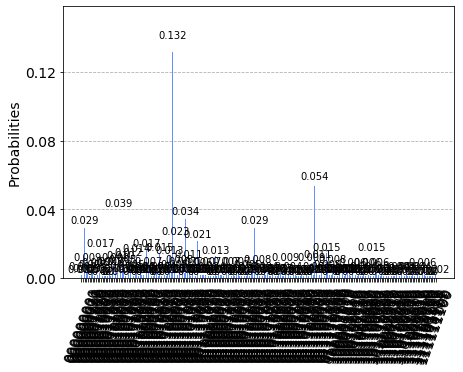

In [16]:
plot_histogram(result['eigenstate'])

[Optional] Checking that the full Hamiltonian made by docplex.get_operator gives the right cost

In [ ]:
from docplex.mp.model import Model
from qiskit.optimization.ising import docplex

# Create an instance of a model and variables
mdl = Model(name='tsp')
x = {(i,p): mdl.binary_var(name='x_{0}_{1}'.format(i,p)) for i in range(n) for p in range(n)}

# Object function
tsp_func = mdl.sum(ins.w[i,j] * x[(i,p)] * x[(j,(p+1)%n)] for i in range(n) for j in range(n) for p in range(n))
mdl.minimize(tsp_func)

# Constrains
for i in range(n):
    mdl.add_constraint(mdl.sum(x[(i,p)] for p in range(n)) == 1)
for p in range(n):
    mdl.add_constraint(mdl.sum(x[(i,p)] for i in range(n)) == 1)

In [ ]:
qubitOp_docplex, offset_docplex = docplex.get_operator(mdl)

In [ ]:
ee = NumPyEigensolver(qubitOp_docplex, k=1)
result = ee.run()

print('energy:', result['energy'])
print('tsp objective:', result['energy'] + offset_docplex)

x = sample_most_likely(result['eigvecs'][0])
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)